In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.util import load

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

from coffea.util import load
from coffea.hist import plot
import numpy as np
import pandas as pd

from pprint import pprint 
hep.style.use(hep.style.ROOT)

/work/dvalsecc/miniconda3/envs/pocket-coffea/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
import json
datasets  = json.load(open("../datasets/backgrounds_MC_ttbar_2018.json"))

In [3]:
filename = datasets["TTToSemiLeptonic_2018"]["files"][0]
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=300000).events()

In [4]:
events

<NanoEventsArray [<event 1:24003:24002014>, ... ] type='300000 * event'>

# btagSF computation

In [5]:
import correctionlib
cset = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/BTV/2018_UL/btagging.json.gz")

In [13]:
corr = cset["deepJet_shape"]

In [14]:
corr.description

'deepJet reshaping scale factors for UL 2018. The scale factors have 8 default uncertainty sources (hf,lf,hfstats1/2,lfstats1/2,cferr1/2). All except the cferr1/2 uncertainties are to be applied to light and b jets. The cferr1/2 uncertainties are to be applied to c jets. hf/lfstats1/2 uncertainties are to be decorrelated between years, the others correlated. Additional jes-varied scale factors are supplied to be applied for the jes variations.'

In [15]:
mask = (events.Jet.pt >= 30) & (abs(events.Jet.eta) < 2.5)

In [16]:
flavour = ak.to_numpy(ak.flatten(events.Jet.hadronFlavour[mask]))
abseta = np.abs(ak.to_numpy(ak.flatten(events.Jet.eta[mask])))
pt = ak.to_numpy(ak.flatten(events.Jet.pt[mask]))
discr = ak.to_numpy(ak.flatten(events.Jet.btagDeepFlavB[mask]))
njet = ak.num(events.Jet[mask])

In [17]:
w = corr.evaluate("central", flavour, abseta, pt, discr)
weight = ak.unflatten(w, njet)

In [18]:
event_weight= ak.prod(weight, axis=-1)

Text(0, 1, 'btag SF')

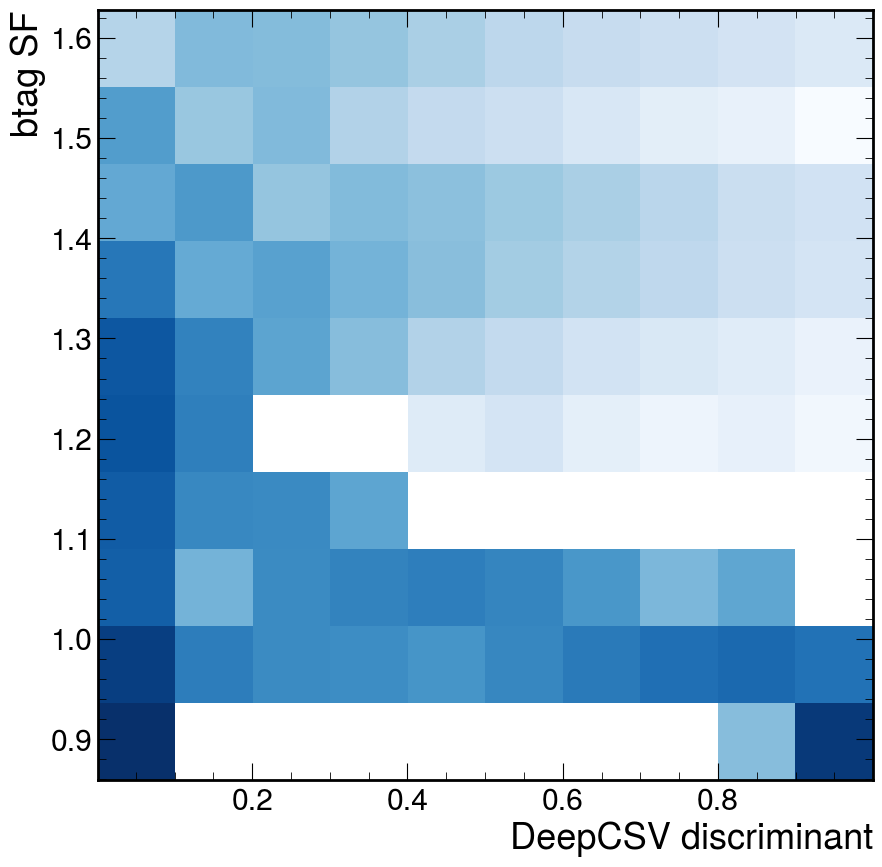

In [19]:
plt.hist2d(discr, w, norm=LogNorm(), cmap="Blues")
plt.xlabel("DeepCSV discriminant")
plt.ylabel("btag SF")

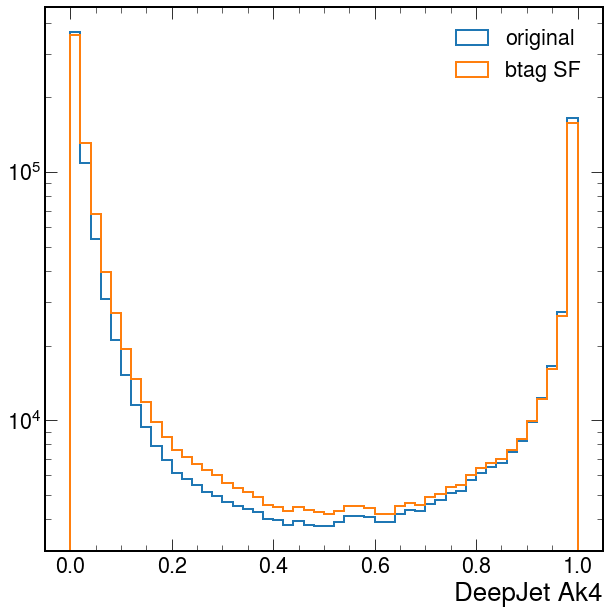

In [31]:
plt.hist(discr, range=(0,1), bins=50, histtype="step",linewidth=2, label="original")
plt.hist(discr, weights=w, range=(0,1), bins=50, histtype="step", linewidth=2,label="btag SF")
plt.legend()
plt.xlabel("DeepJet Ak4")
plt.yscale("log")

(array([571562.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  19468., 442819.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

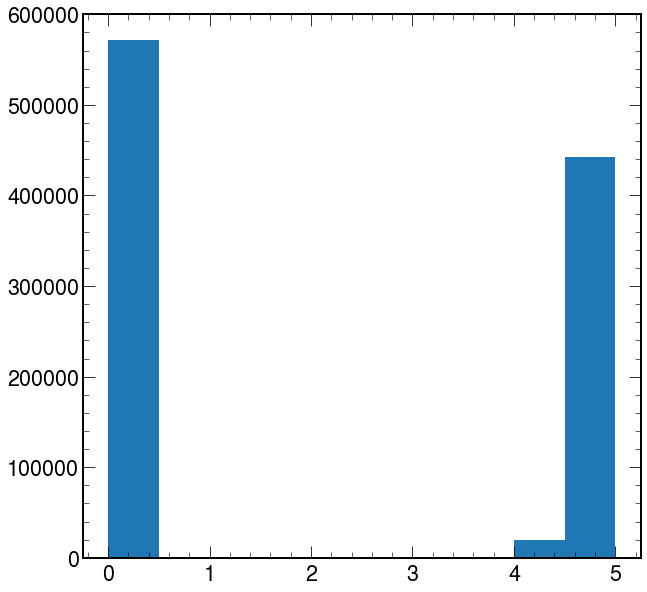

In [32]:
plt.hist(flavour)

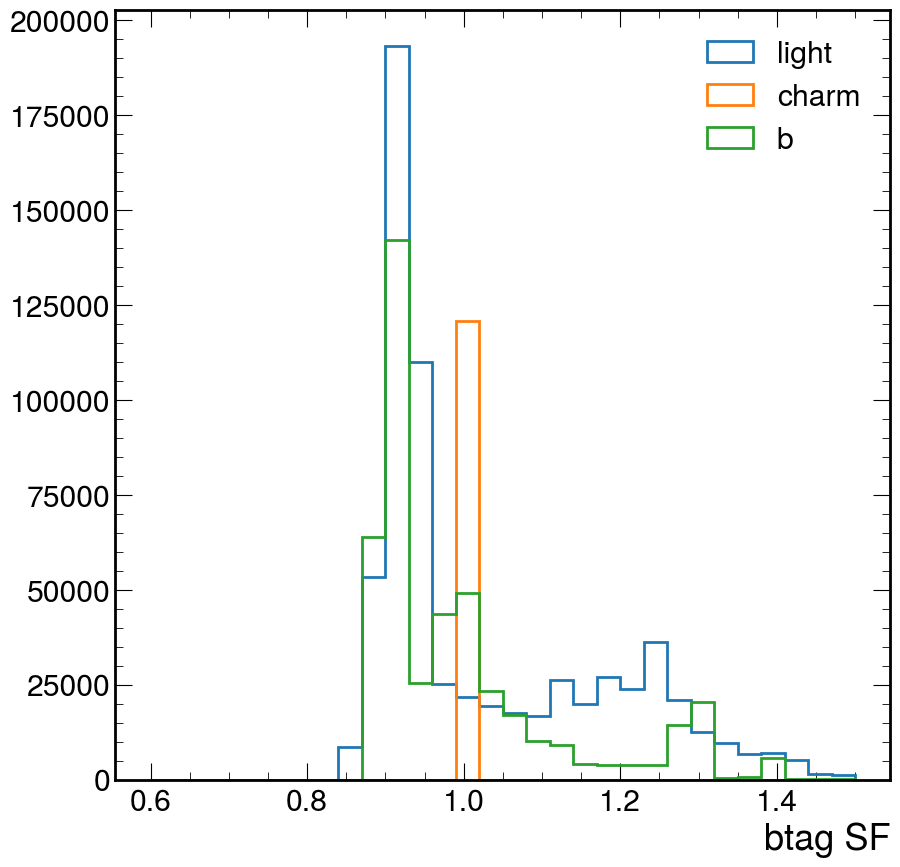

In [20]:
plt.hist(w[flavour==0], bins=30, range=(0.6,1.5),histtype="step",linewidth=2, label="light" )
plt.hist(w[flavour==4], bins=30, range=(0.6,1.5),histtype="step", linewidth=2,label="charm" )
plt.hist(w[flavour==5], bins=30, range=(0.6,1.5),histtype="step", linewidth=2, label="b")
plt.xlabel("btag SF")
plt.legend()

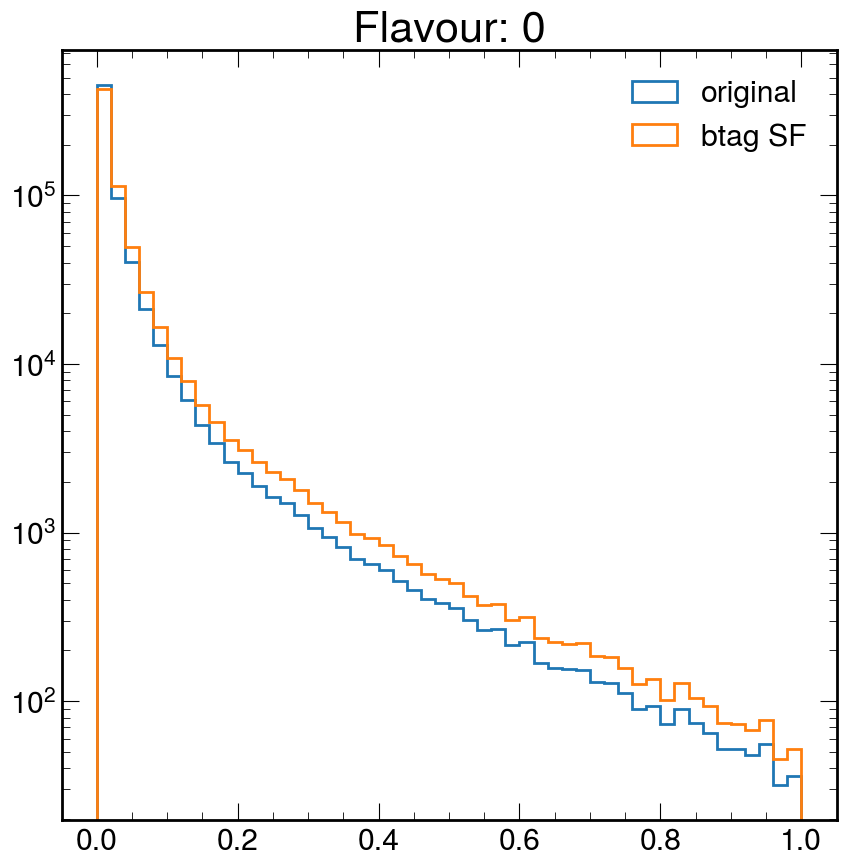

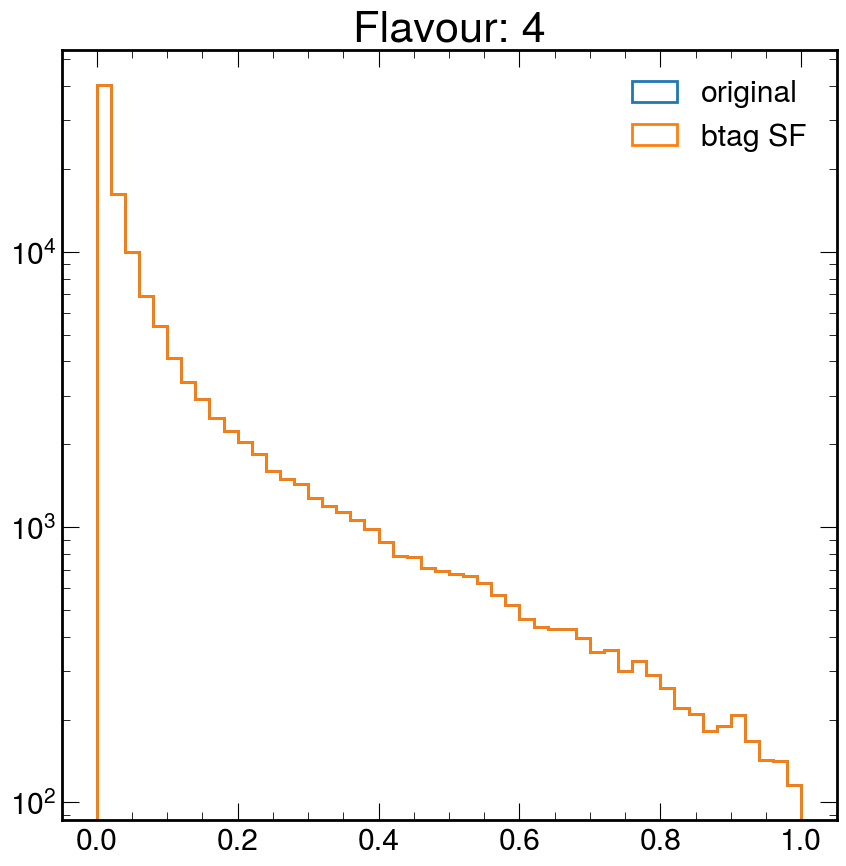

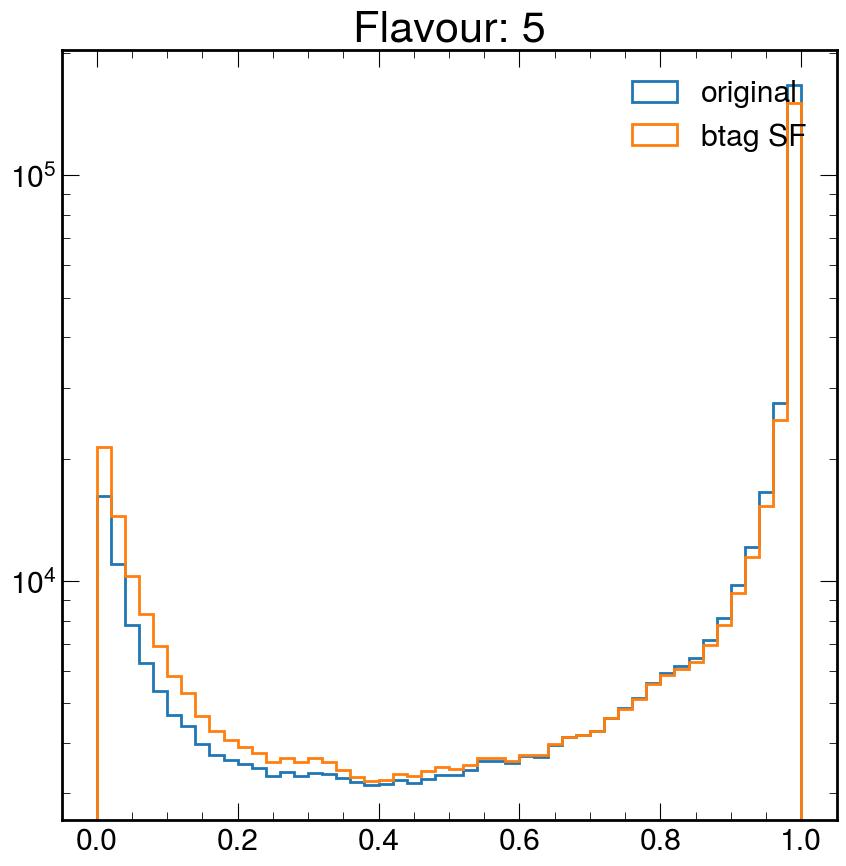

In [21]:
for fl in [0,4,5]:
    mask = flavour==fl
    plt.hist(discr[mask], range=(0,1), bins=50, histtype="step",linewidth=2, label="original")
    plt.hist(discr[mask], weights=w[mask], range=(0,1), bins=50, linewidth=2,histtype="step", label="btag SF")
    plt.title(f"Flavour: {fl}")
    plt.legend()
    plt.yscale("log")
    plt.show()

## Overall normalization pre/post btagSF

Text(1, 0, 'Inclusive N. jets')

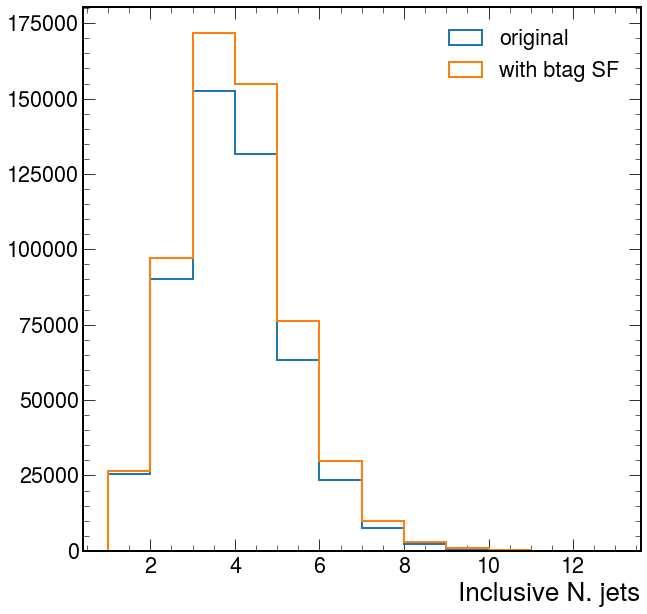

In [116]:
H, *_ = plt.hist(njet, bins=12, range=(1, 13),histtype="step", label="original", linewidth=2)
Hsf, *_  = plt.hist(njet, weights=event_weight, bins=12, range=(1, 13),histtype="step", label="with btag SF", linewidth=2)
plt.legend()
plt.xlabel("Inclusive N. jets" )

In [127]:
import hist

In [156]:
H = (hist.Hist.new
     .StrCat(["original", "btagSF"], name="version")
    .Reg(9, 1, 10, name="njet")
    .Weight())

In [157]:
H.fill(version="original", njet=njet)
H.fill(version="btagSF", njet=njet, weight=event_weight)

Hist(
  StrCategory(['original', 'btagSF'], name='version', label='version'),
  Regular(9, 1, 10, name='njet', label='njet'),
  storage=Weight()) # Sum: WeightedSum(value=1.06616e+06, variance=1.20249e+06) (WeightedSum(value=1.07274e+06, variance=1.20936e+06) with flow)

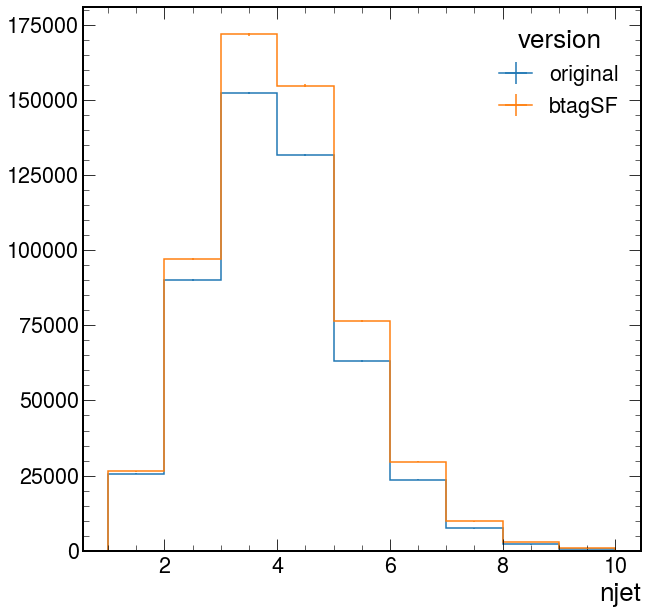

In [158]:
fig, ax = plt.subplots()
H[:, :].plot1d(ax=ax)
ax.legend(title="version")

In [159]:
num = H["original",:].values()
denom = H["btagSF", :].values()
sf = np.where(
    (num>0)&(denom>0), 
    num / denom, 
    1.0)
#

In [160]:
sfhist = hist.Hist(*H.axes[1:], data=sf)

Our SF is now an histogram and we can use it to convert it to correctionlib

In [161]:
sfhist

Hist(Regular(9, 1, 10, name='njet', label='njet'), storage=Double()) # Sum: 7.464676969939082

In [41]:
H.axes

(StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2btag', '3btag', 'btagSF', 'no_btagSF'], growth=True, name='cat', label='Cat'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Regular(25, 0, 25, name='njet', label='$N_{jet}$'))

## SF variation

In [23]:
mask = (events.Jet.pt >= 30) & (abs(events.Jet.eta) < 2.5)
flavour = ak.to_numpy(ak.flatten(events.Jet.hadronFlavour[mask]))
abseta = np.abs(ak.to_numpy(ak.flatten(events.Jet.eta[mask])))
pt = ak.to_numpy(ak.flatten(events.Jet.pt[mask]))
discr = ak.to_numpy(ak.flatten(events.Jet.btagDeepFlavB[mask]))
counts = ak.num(events.Jet[mask])

In [25]:
variation = "cferr1"
cmask = (flavour == 4)
cindex = (np.indices(discr.shape)).flatten()[cmask]
sfup = np.ones_like(discr, dtype=float)
sfdown = np.ones_like(discr, dtype=float)
wup = corr.evaluate(f"up_{variation}", flavour[cmask], abseta[cmask], pt[cmask], discr[cmask])
wdown = corr.evaluate(f"down_{variation}", flavour[cmask], abseta[cmask], pt[cmask], discr[cmask])
sfup[cindex] = wup
sfdown[cindex] = wdown
sfup_out = ak.prod(ak.unflatten(sfup, counts), axis=1)
sfdown_out = ak.prod(ak.unflatten(sfdown, counts), axis=1)

In [26]:
ak.num(counts, axis=0)

300000

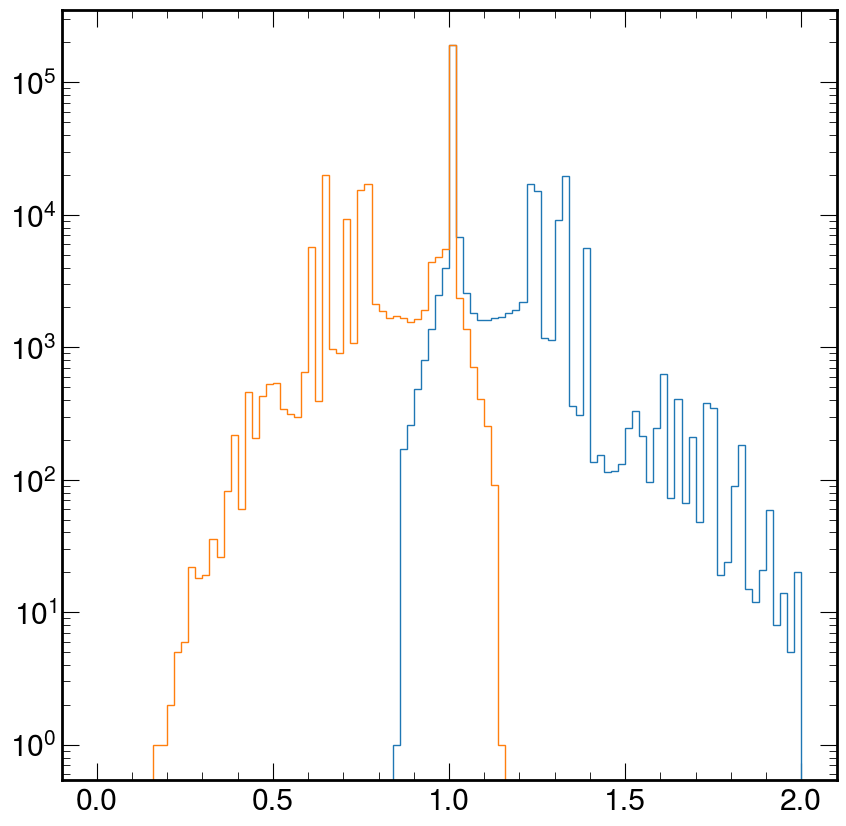

In [27]:
plt.hist(sfup_out, bins=100, histtype="step", range=(0, 2))
plt.hist(sfdown_out, bins=100, histtype="step", range=(0, 2))
plt.yscale("log")

# btagSF on PocketCoffea output

In [100]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v40/output.coffea" 
output = load(filename1)
print(output.keys())

H = output["hist_njet"].to_hist()

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht_bins1', 'hist2d_Njet_Ht_bins2', 'hist2d_Njet_Ht_bins3', 'scale_genweight'])


/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


In [77]:
H

Hist(
  StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
  StrCategory(['2b', '2b_btagSF', '3b', '3b_btagSF', 'btagSF', 'btagSF_calib', 'no_btagSF'], growth=True, name='cat', label='Cat'),
  StrCategory(['2018'], growth=True, name='year', label='Year'),
  Regular(25, 0, 25, name='njet', label='$N_{jet}$'),
  storage=Weight()) # Sum: WeightedSum(value=1.22436e+07, variance=582543)

Text(0.5, 0.98, 'TTToSemileptonic')

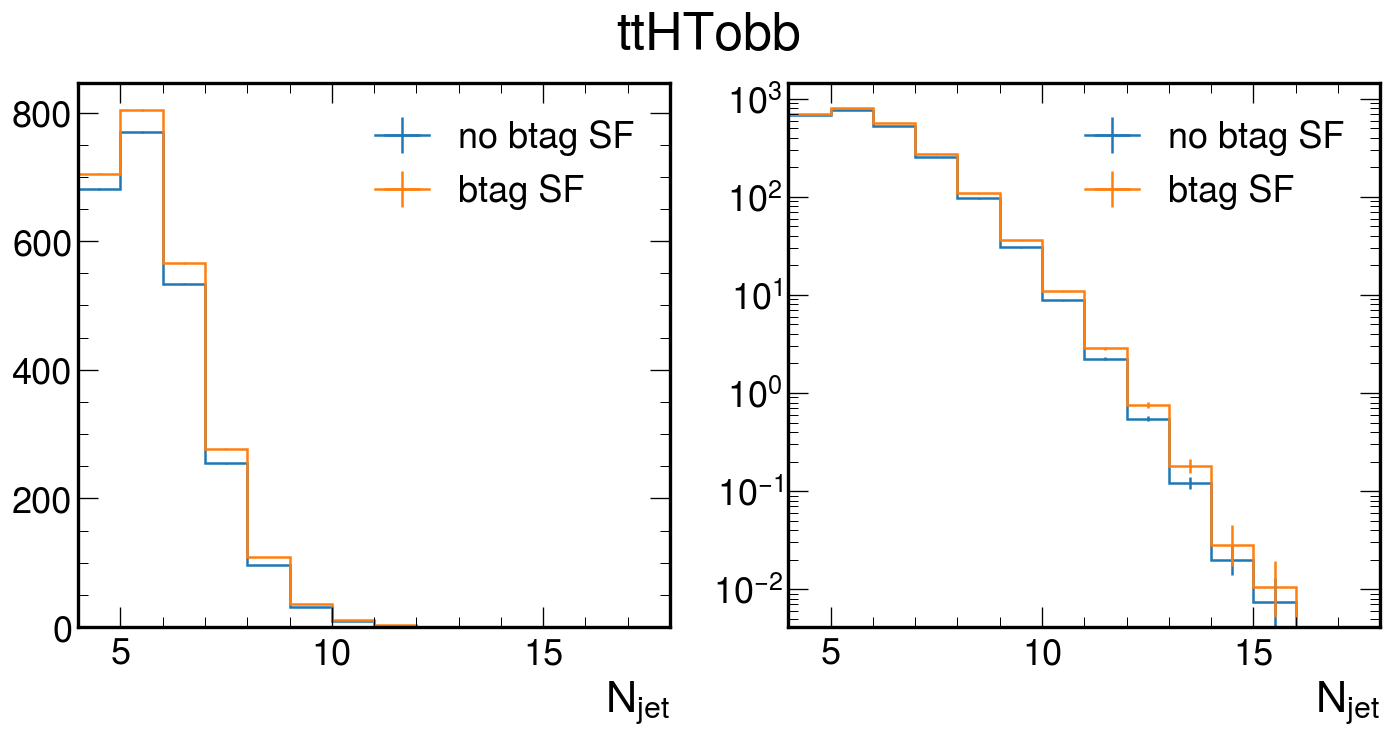

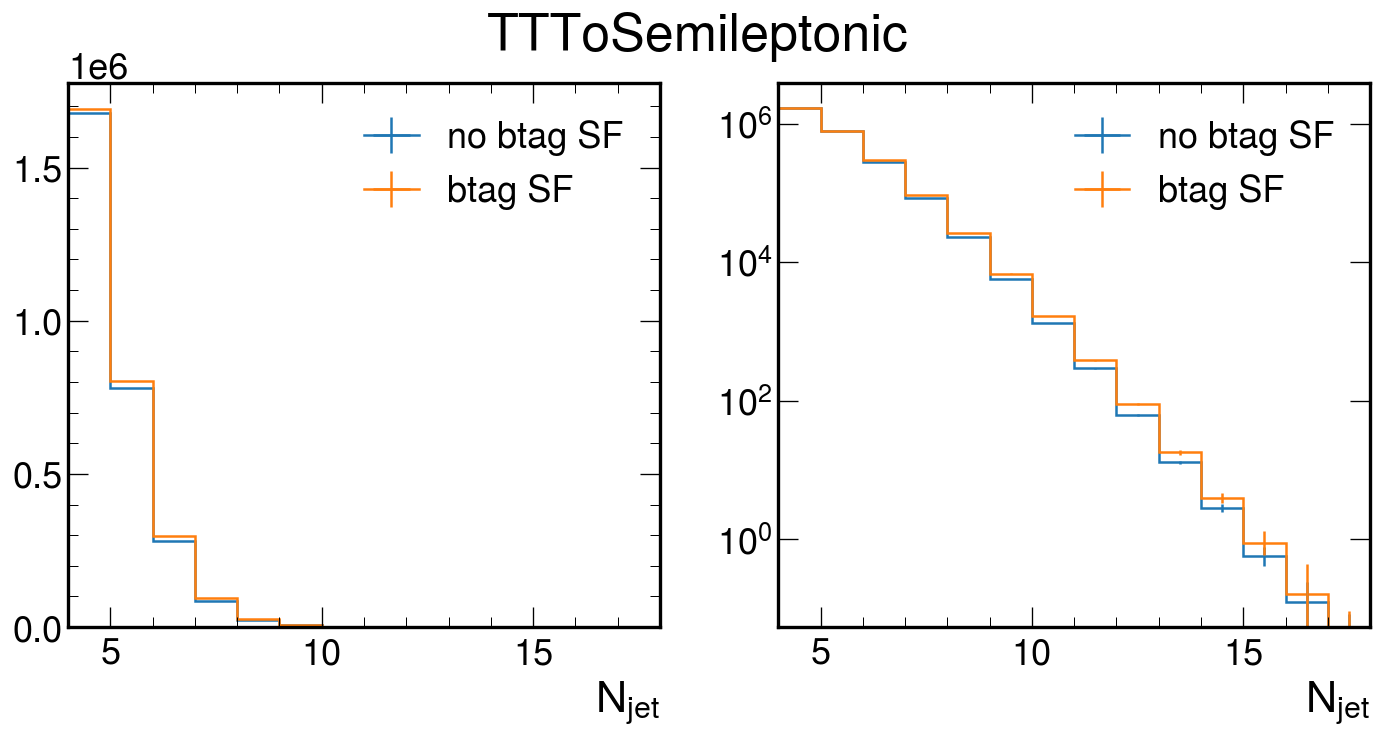

In [61]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()
ax.set_xlim(4,18)

hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
ay.set_xlim(4,18)

fig.suptitle("ttHTobb")

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()
ax.set_xlim(4,18)

hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
ay.set_xlim(4,18)

fig.suptitle("TTToSemileptonic")

# Try to create a correctionlib with multiple categories

In [6]:
num = H[:,"no_btagSF",:,:].values()
denom = H[: , "btagSF",:,:].values()

In [7]:
sf = np.where(  (num>0)&(denom>0), num/denom, 1.0)

/tmp/ipykernel_61368/2570729222.py:1: RuntimeWarning: invalid value encountered in true_divide
  sf = np.where(  (num>0)&(denom>0), num/denom, 1.0)


In [8]:
import hist
sfhist = hist.Hist(H.axes[0],H.axes[2],H.axes[3], data=sf)

In [9]:
sfhist["ttHTobb",'2018',:].values()

array([1.        , 1.        , 1.        , 1.        , 0.96597233,
       0.95729766, 0.9433591 , 0.91900112, 0.88582703, 0.84970417,
       0.80895186, 0.78044002, 0.72922368, 0.66602761, 0.69838301,
       0.70018798, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [10]:
[ax for i, ax in enumerate(sfhist.axes)]

[StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Regular(25, 0, 25, name='njet', label='$N_{jet}$')]

In [12]:
import correctionlib, rich
import correctionlib.convert
# without a name, the resulting object will fail validation
sfhist.name = "btagSF_norm_correction"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "SF to correct the overall normalization after the application of btagSF weights"
# set overflow bins behavior (default is to raise an error when out of bounds)
#clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="btagSF normalization corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("/work/dvalsecc/ttHbb/PocketCoffea/notebooks/btagSF_norm.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
btagSF normalization corrections
📂
└── 📈 btagSF_norm_correction (v0)
    SF to correct the overall normalization after the application of btagSF weights
    Node counts: Category: 3, Binning: 2
    ╭───────────── ▶ input ─────────────╮ ╭─── ▶ input ───╮ ╭───── ▶ input ──────╮
    │ sample (string)                   │ │ year (string) │ │ njet (real)        │
    │ Sample                            │ │ Year          │ │ $N_{jet}$          │
    │ Values: TTToSemiLeptonic, ttHTobb │ │ Values: 2018  │ │ Range: [0.0, 25.0) │
    ╰───────────────────────────────────╯ ╰───────────────╯ ╰────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

# Comparison plots

Text(0.5, 0.98, 'TTToSemileptonic')

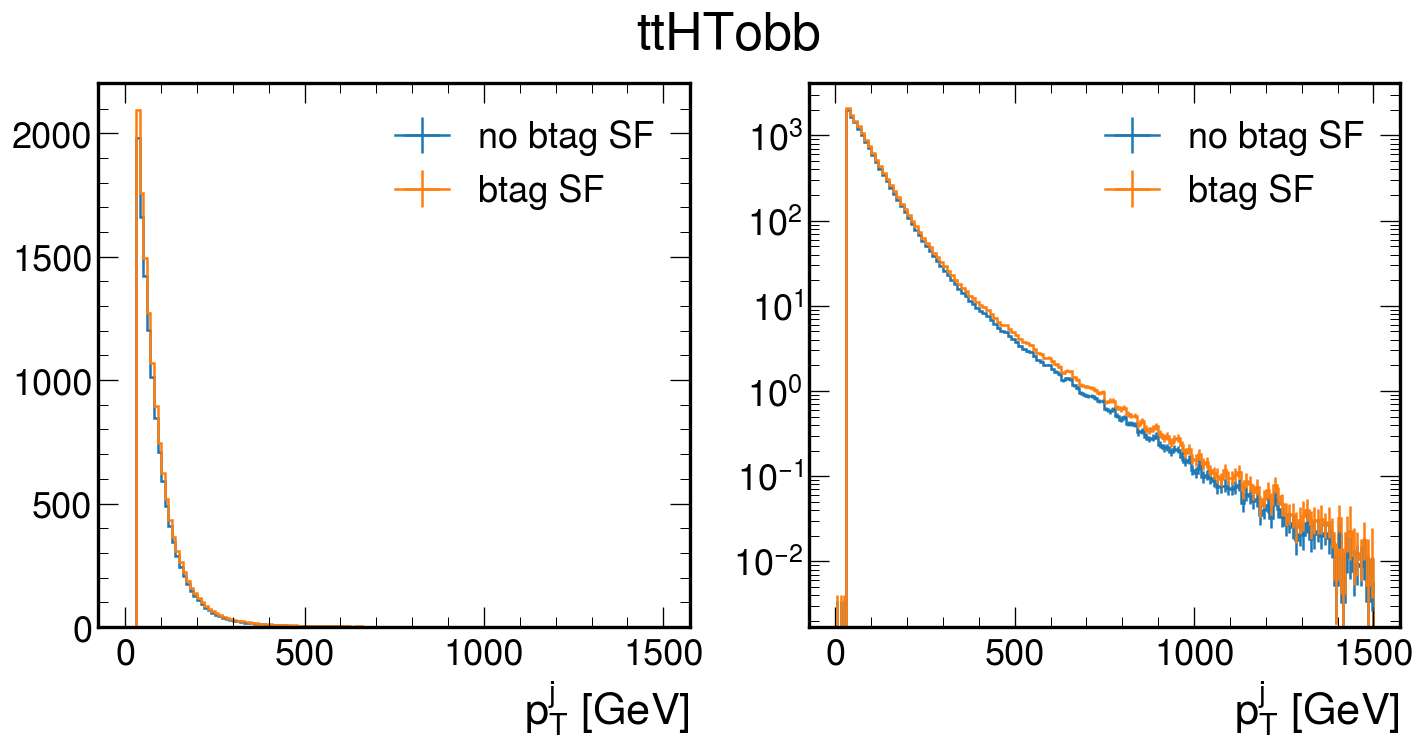

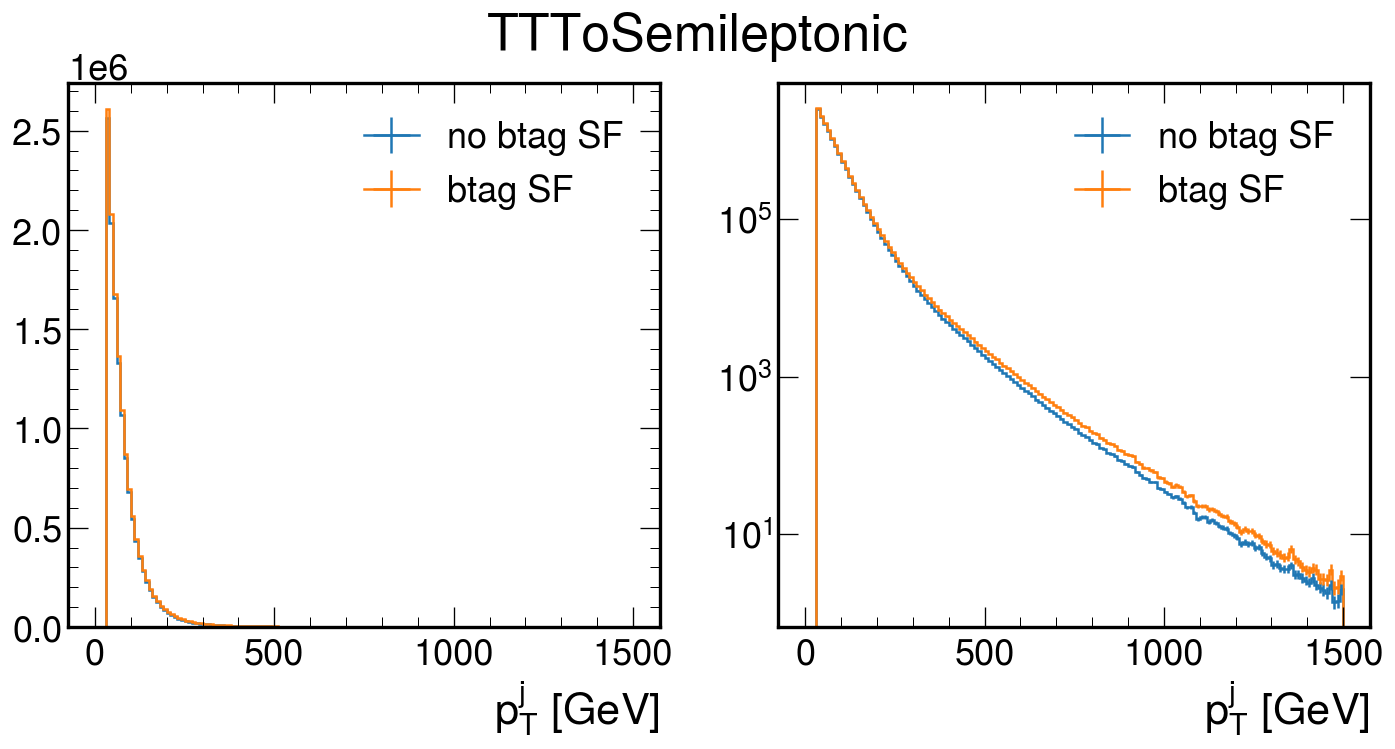

In [67]:
H = output["hist_jet_pt"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")

fig.suptitle("ttHTobb")

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
fig.suptitle("TTToSemileptonic")

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


Text(0.5, 0.98, 'TTToSemileptonic')

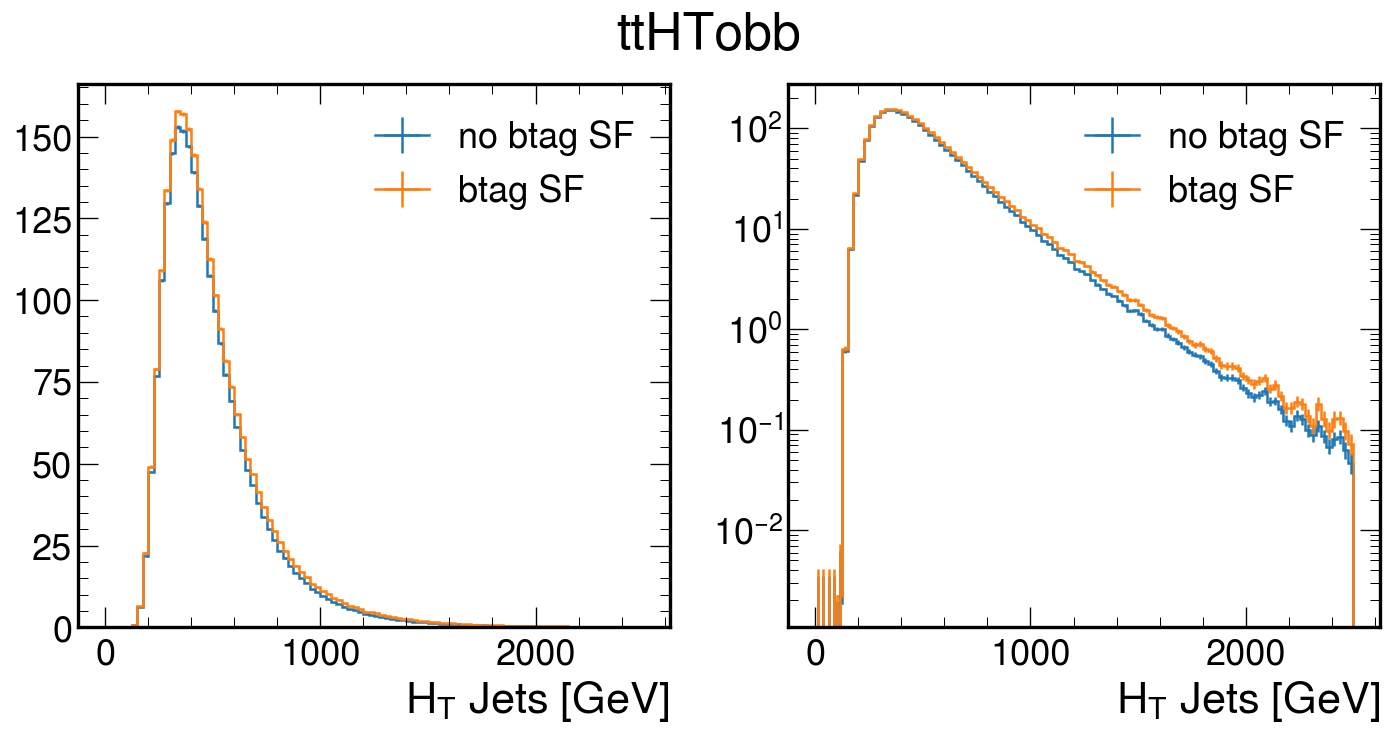

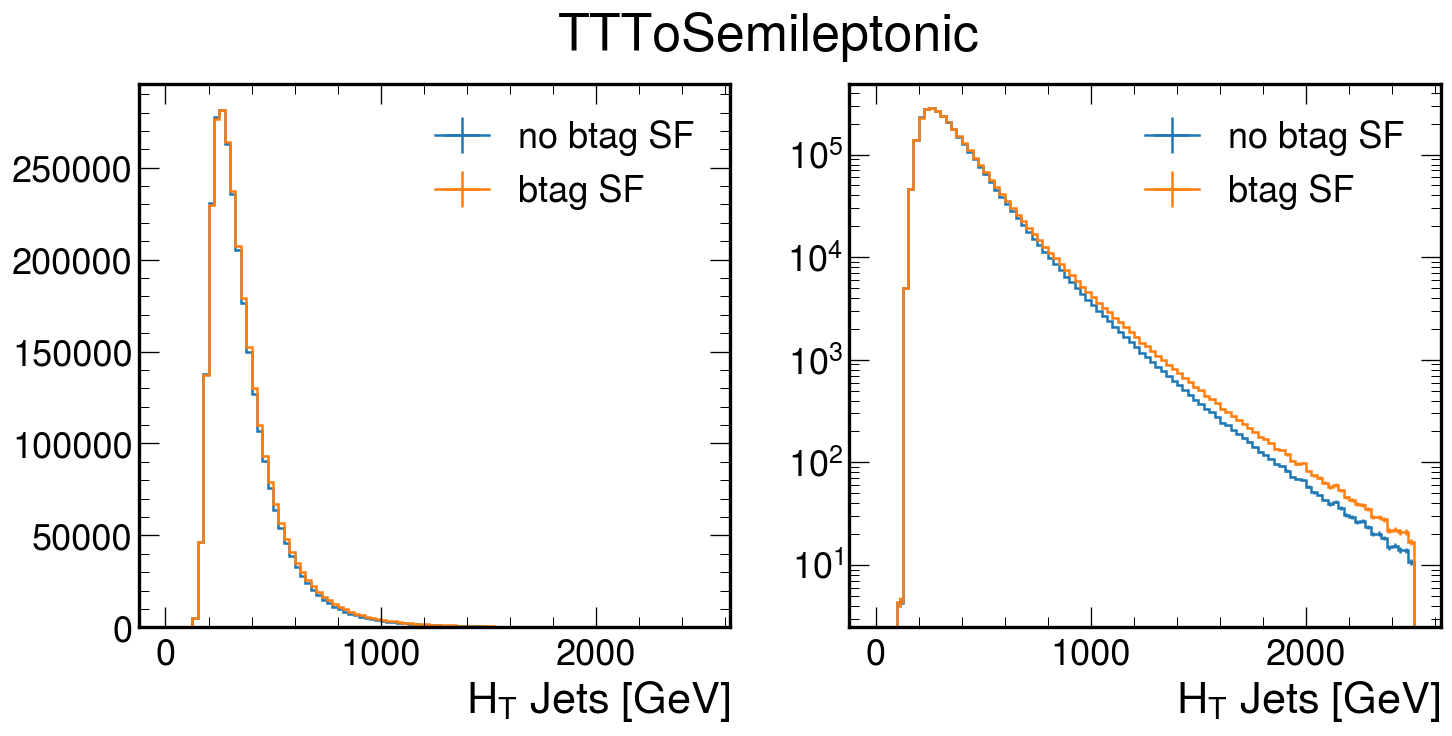

In [30]:
H = output["hist_Ht"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")

fig.suptitle("ttHTobb")

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
fig.suptitle("TTToSemileptonic")

## Ratio plots

In [199]:
def hist_comparison(df, var, shapes,ylog=False, output_folder=None, ):
    '''
    shapes = [ (sample,cat,year, label),] 
    '''
    # os.makedirs(output_folder, exist_ok=True)
    # os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_folder}")
    
    H = df[var].to_hist()
    mmax = np.max(H.values())
    fig = plt.figure(figsize=(8,9), dpi=100)
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    plt.subplots_adjust(wspace=0.3)
    
    axu =  axs[0]
    axd =  axs[1]

    for sample, cat, year, label in shapes:
        hep.histplot(H[sample, cat,year,:], label=label, ax=axu)
        
    if ylog:
        axu.set_yscale("log")
    axu.legend()
    axu.set_xlabel('')
    axu.set_ylabel('Events')
    hep.plot.ylow(axu)
    hep.plot.yscale_legend(axu)

    # Ratios
    sample, cat, year, label = shapes[0]
    nom = H[sample,cat,year,:]
    nomvalues = nom.values()
    nom_sig2 = nom.variances()
    centers = nom.axes[0].centers
    edges = nom.axes[0].edges
    minratio, maxratio = 1000.,0.
    for  sample, cat, year, label in shapes[:]:
        h = H[sample,cat,year,:]
        h_val = h.values()
        h_sig2 = h.variances()
        
        err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
        r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
        m, M = np.min(r), np.max(r)
        if m < minratio: minratio = m
        if M > maxratio: maxratio = M
        axd.errorbar(centers, r, xerr=0, yerr=err, label=label,
                     fmt=".", linestyle='none', elinewidth=1)
       
    axd.legend(ncol=3, fontsize='xx-small')
    hep.plot.yscale_legend(axd)
    axd.set_xlabel(nom.axes[0].label)
    axd.set_ylim(0.8*minratio, 1.2*maxratio)
    axd.set_ylabel("ratio")
    axd.grid(which="both",axis="y")
    
    axu.text(0.5, 1.025, "test tewst", transform=axu.transAxes, fontsize="x-small")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axu) 
    

/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


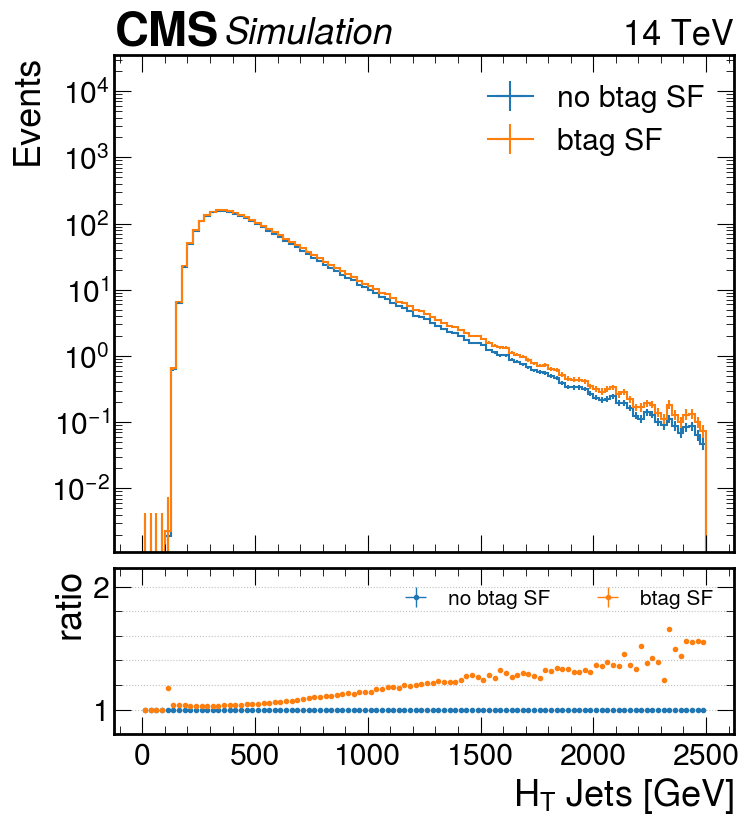

In [79]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


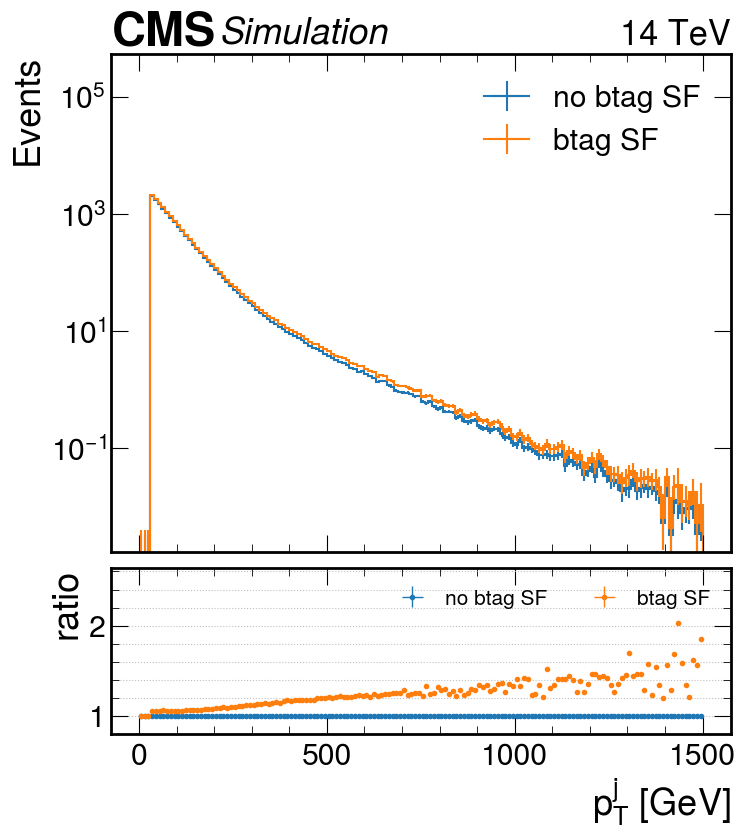

In [80]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


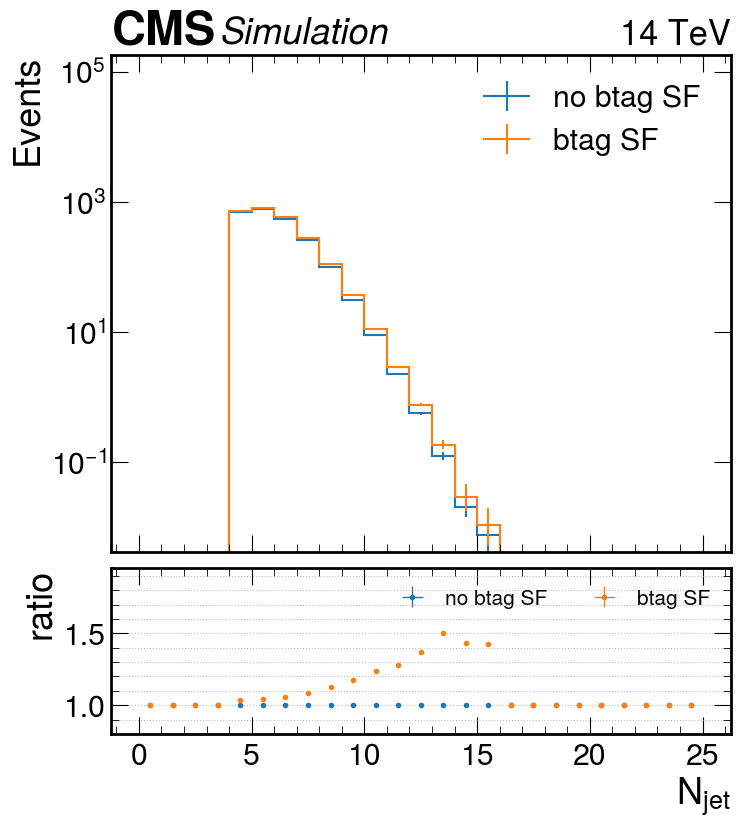

In [98]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


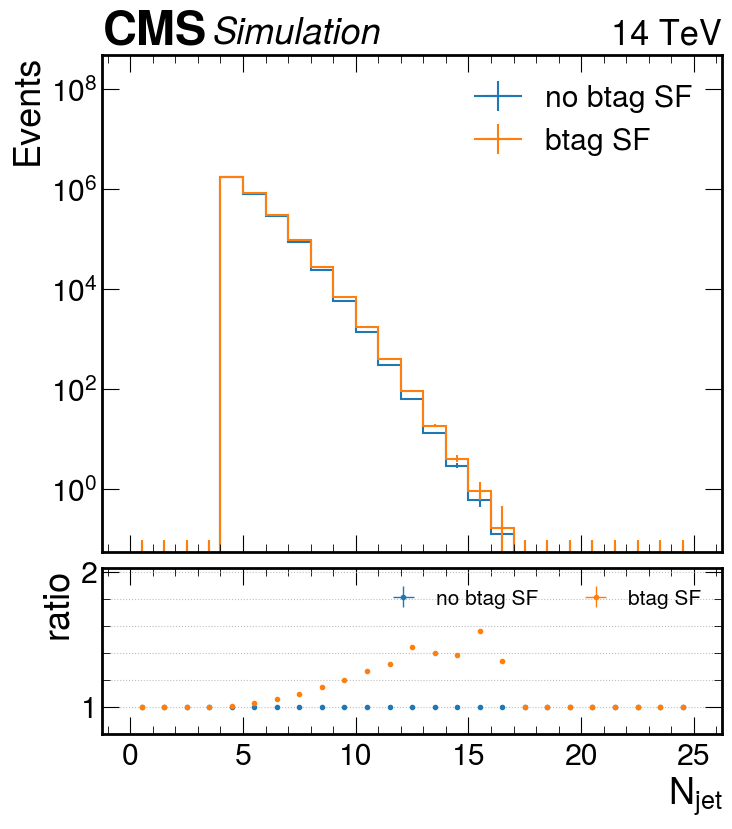

In [99]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


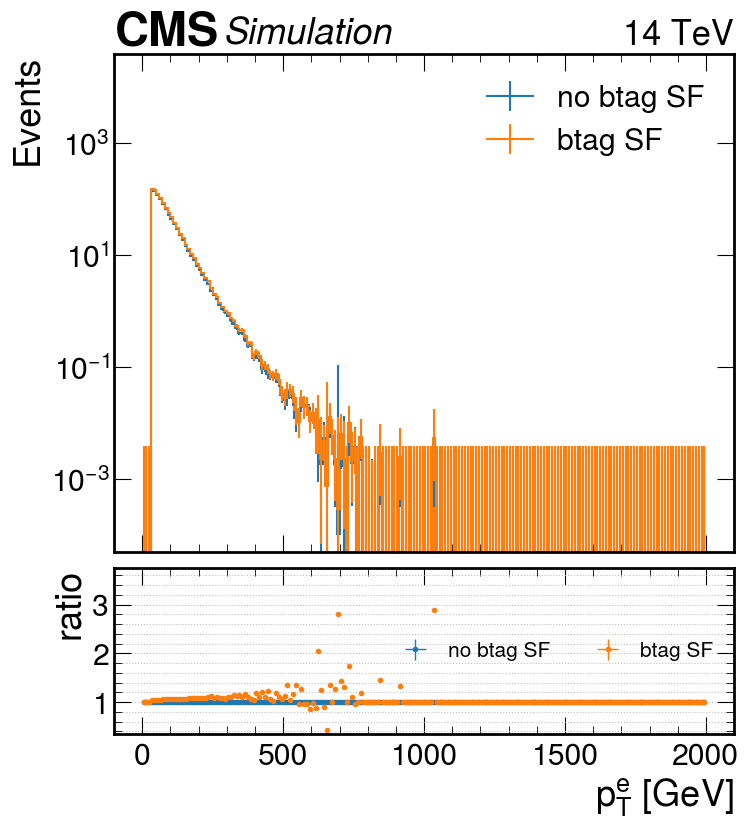

In [84]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_electron_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


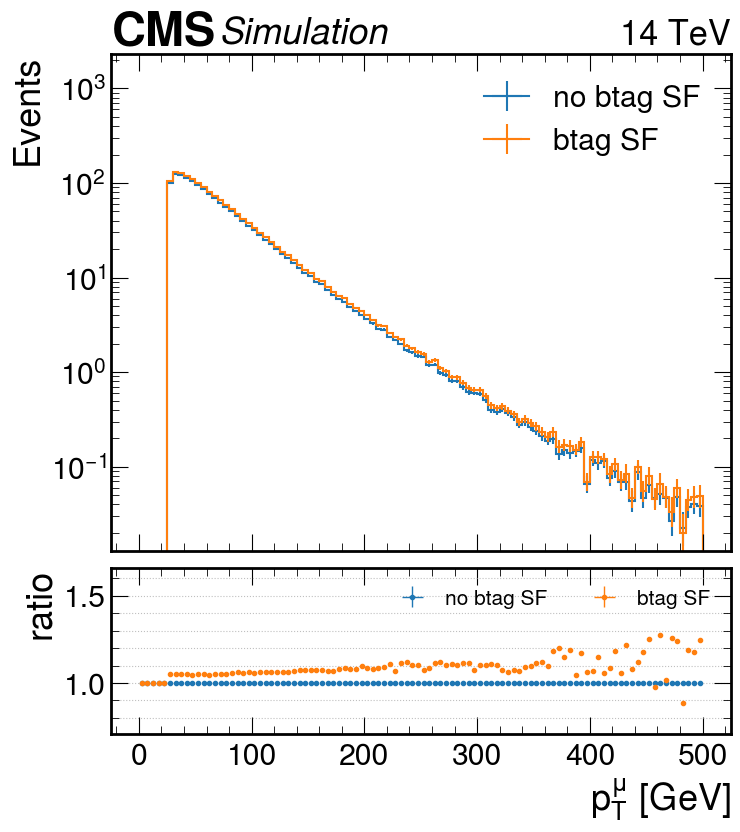

In [85]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_muon_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


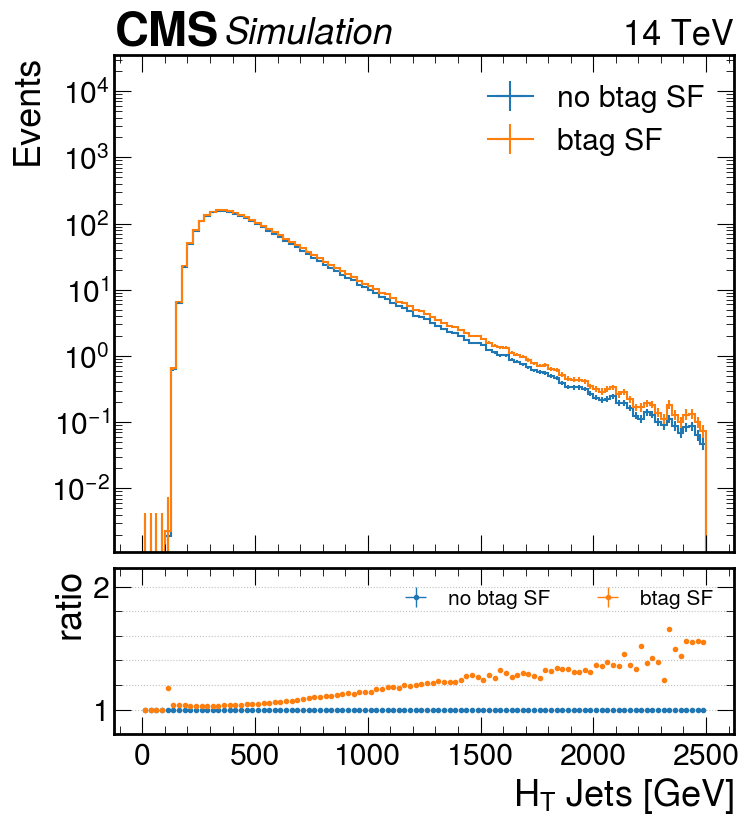

In [86]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


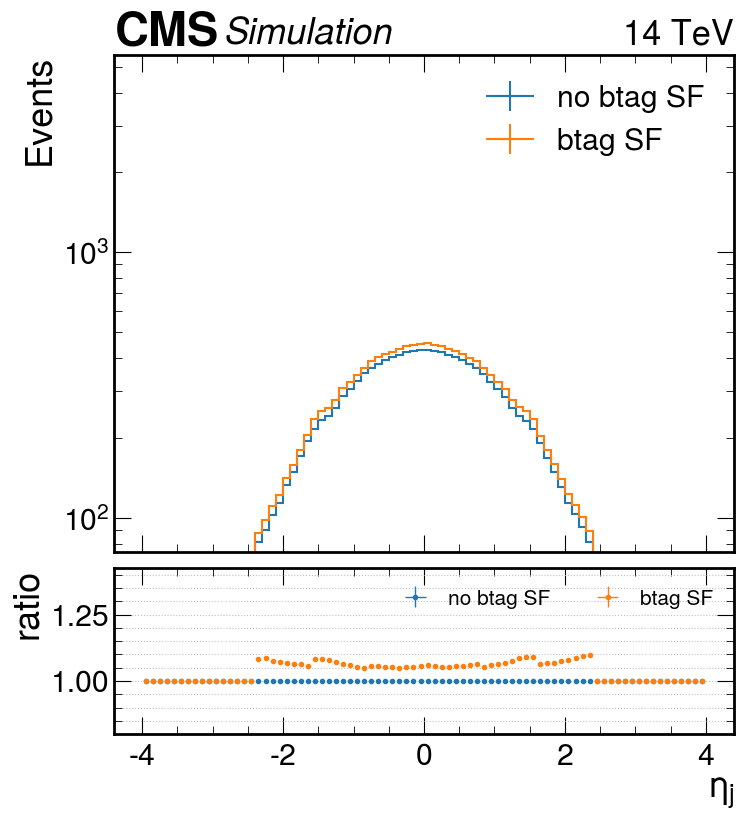

In [87]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

# 2D SF with Jet $H_T$ and $N_{jets}$

In [ ]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v40/output.coffea" 
output = load(filename1)
print(output.keys())


Text(0.5, 1.0, 'btagSF')

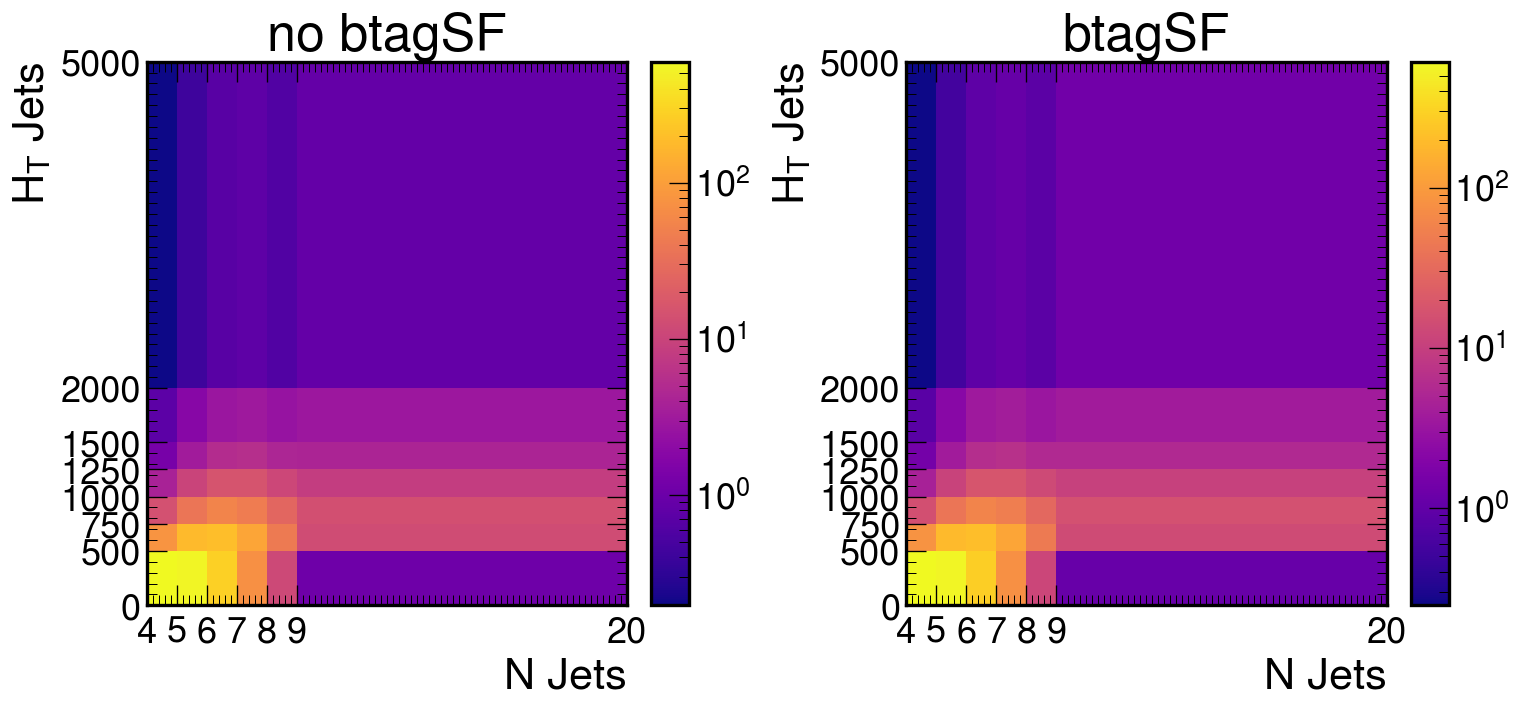

In [101]:
A = output["hist2d_Njet_Ht_bins1"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
plt.subplots_adjust(wspace=0.4)
hep.hist2dplot(A['ttHTobb','no_btagSF','2018',:,:], cmap="plasma", ax=ax, cmin=0.001, norm=LogNorm())
ax.set_title("no btagSF")
hep.hist2dplot(A['ttHTobb','btagSF','2018',:
                 ,:], cmap="plasma", ax=ay, cmin=0.001,norm=LogNorm())
ay.set_title("btagSF")

Text(0.5, 1.0, 'btagSF')

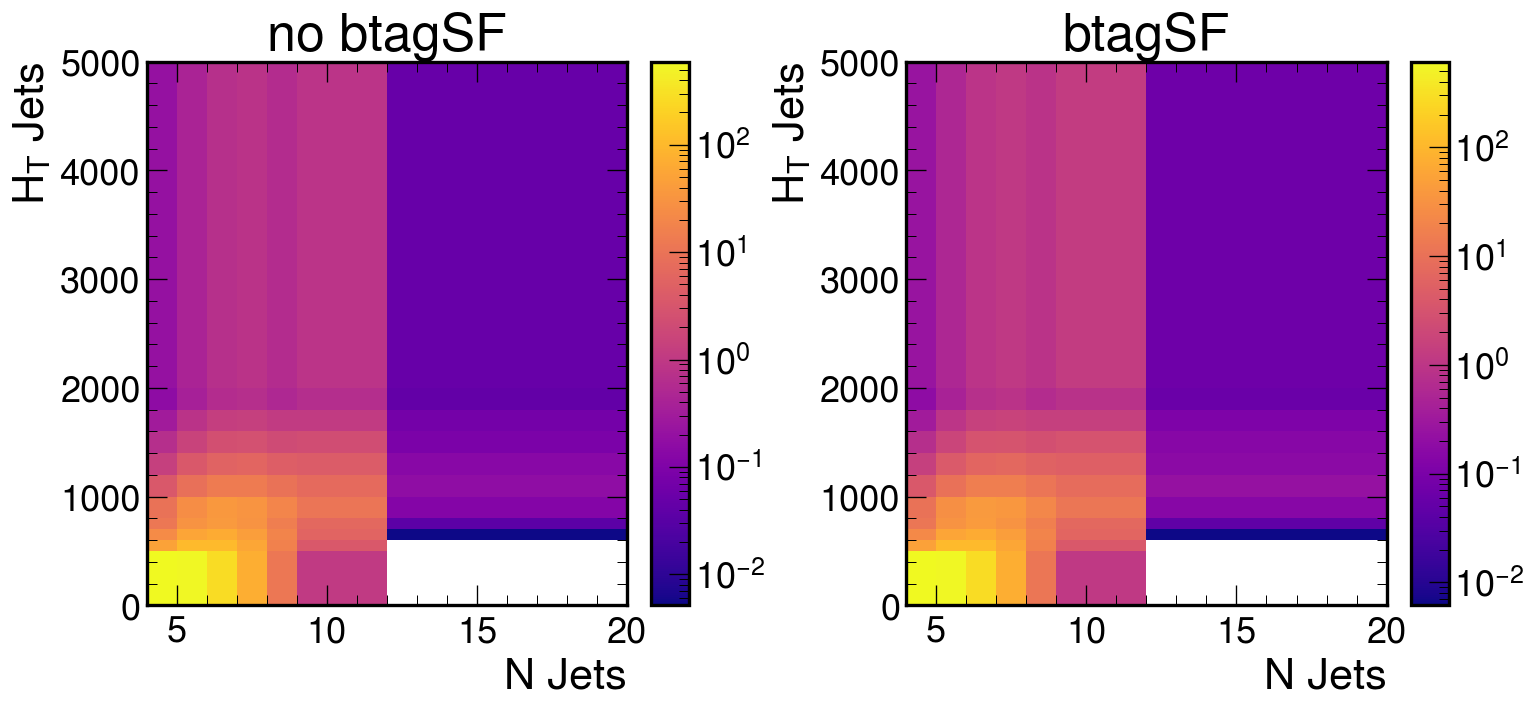

In [102]:
A = output["hist2d_Njet_Ht_bins2"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
plt.subplots_adjust(wspace=0.4)
hep.hist2dplot(A['ttHTobb','no_btagSF','2018',:,:], cmap="plasma", ax=ax, cmin=0.001, norm=LogNorm())
ax.set_title("no btagSF")
hep.hist2dplot(A['ttHTobb','btagSF','2018',:
                 ,:], cmap="plasma", ax=ay, cmin=0.001,norm=LogNorm())
ay.set_title("btagSF")

Text(0.5, 1.0, 'btagSF')

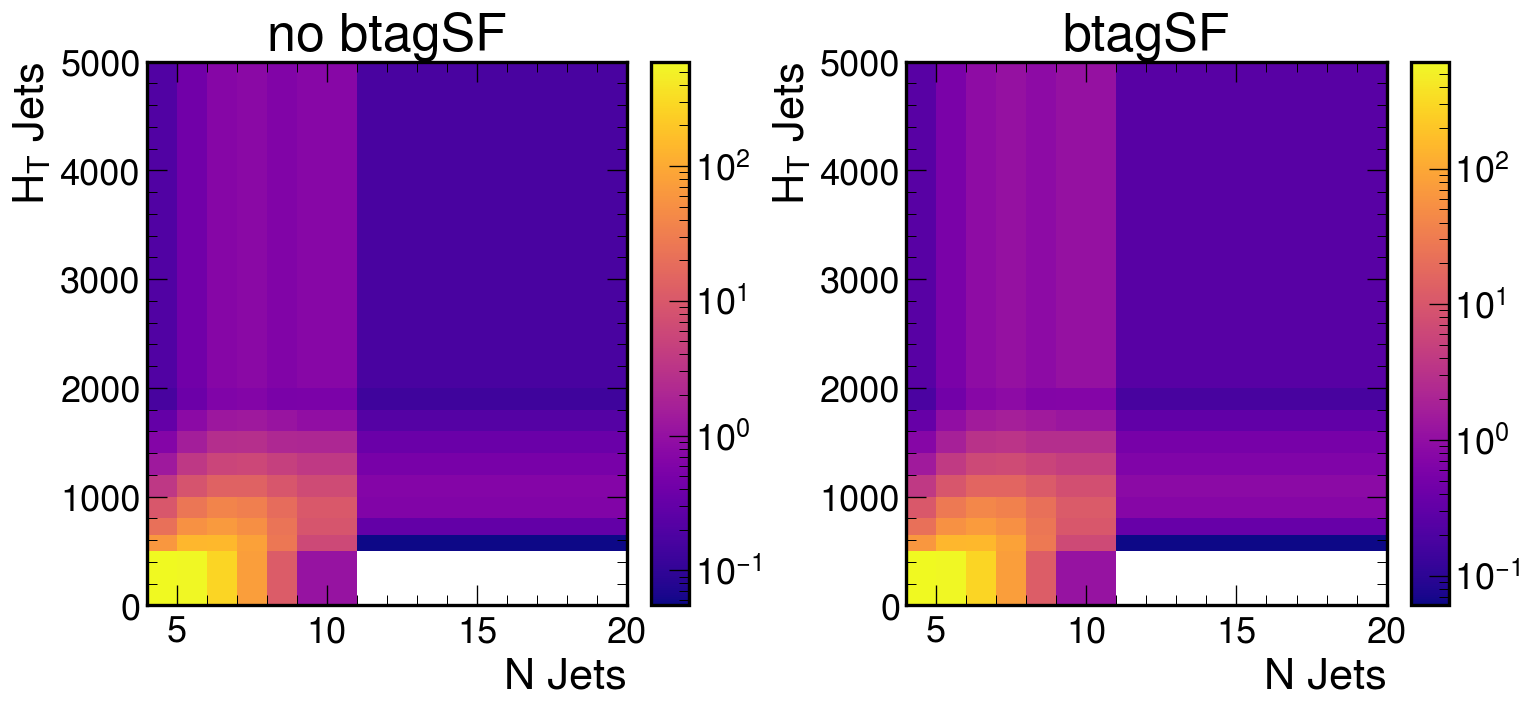

In [103]:
A = output["hist2d_Njet_Ht_bins3"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
plt.subplots_adjust(wspace=0.4)
hep.hist2dplot(A['ttHTobb','no_btagSF','2018',:,:], cmap="plasma", ax=ax, cmin=0.001, norm=LogNorm())
ax.set_title("no btagSF")
hep.hist2dplot(A['ttHTobb','btagSF','2018',:
                 ,:], cmap="plasma", ax=ay, cmin=0.001,norm=LogNorm())
ay.set_title("btagSF")

/tmp/ipykernel_51161/359820697.py:10: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/359820697.py:12: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/359820697.py:12: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/359820697.py:12: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


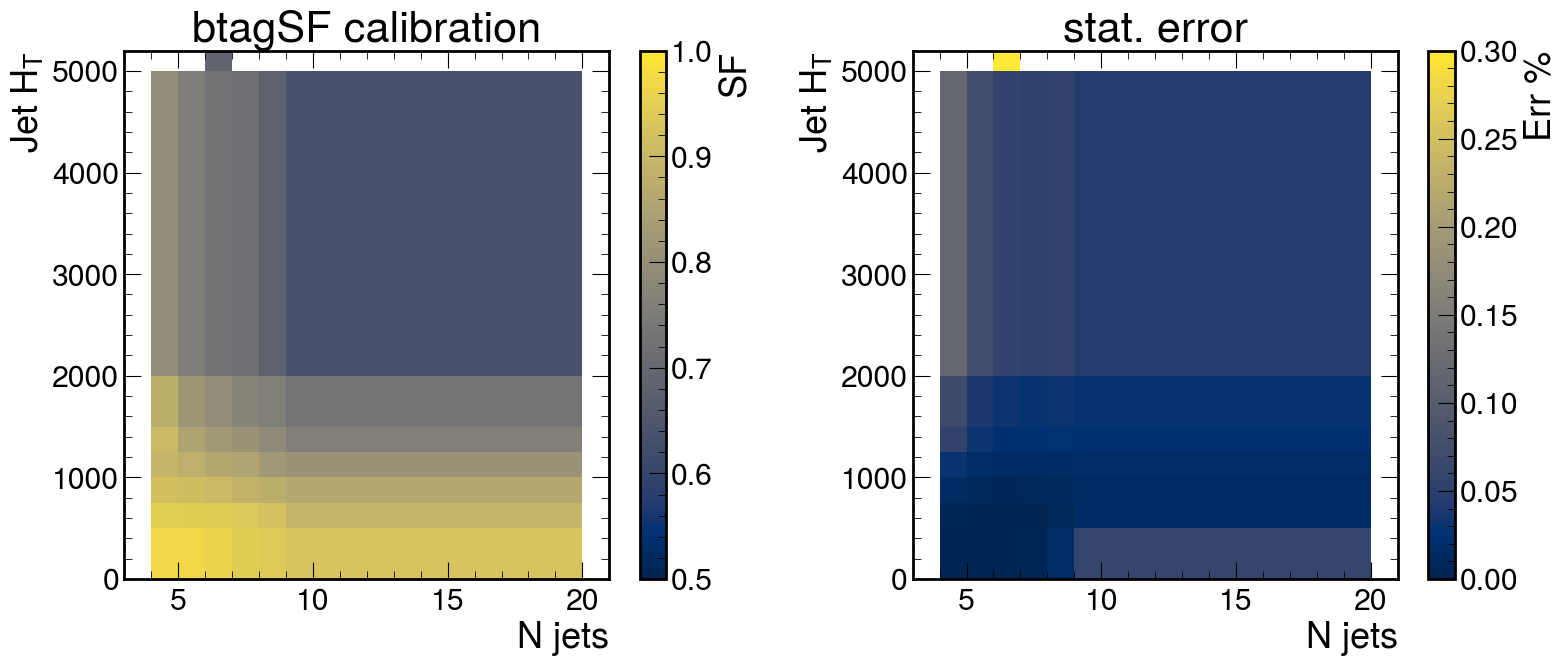

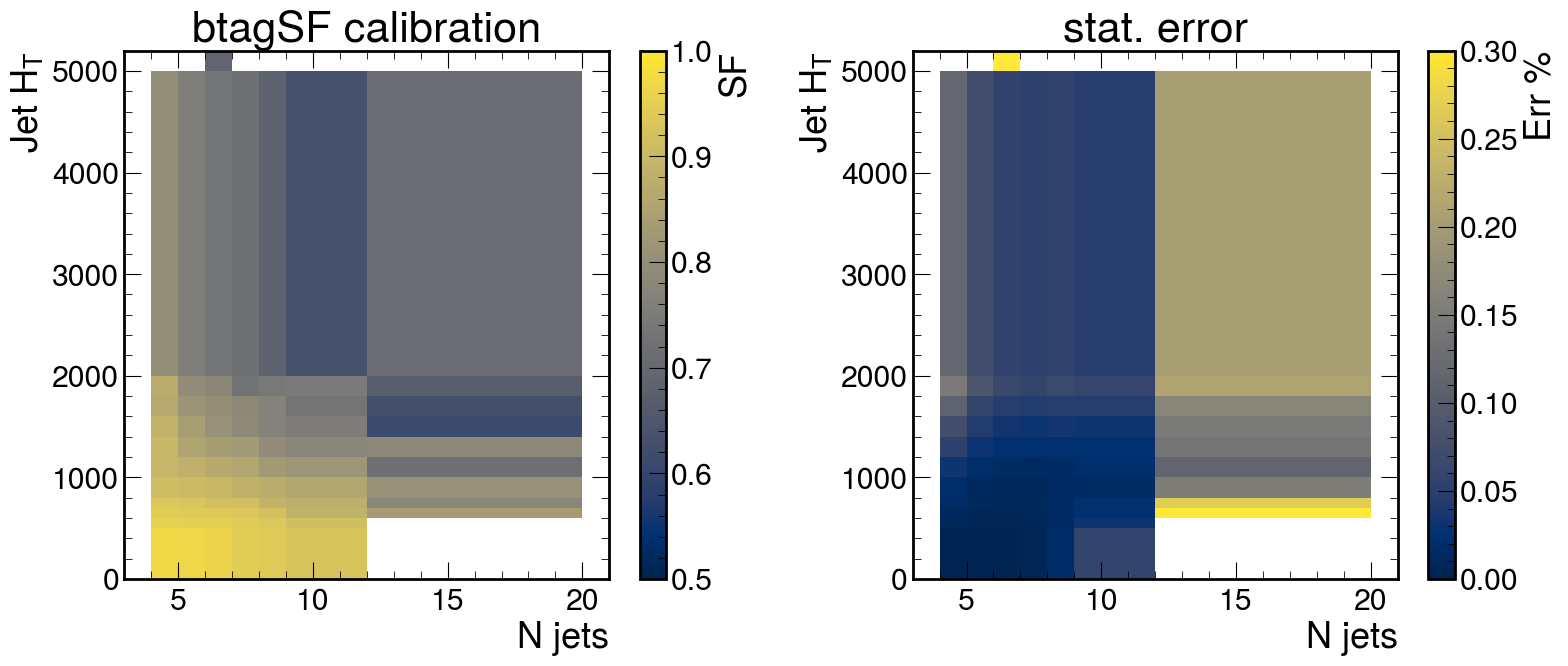

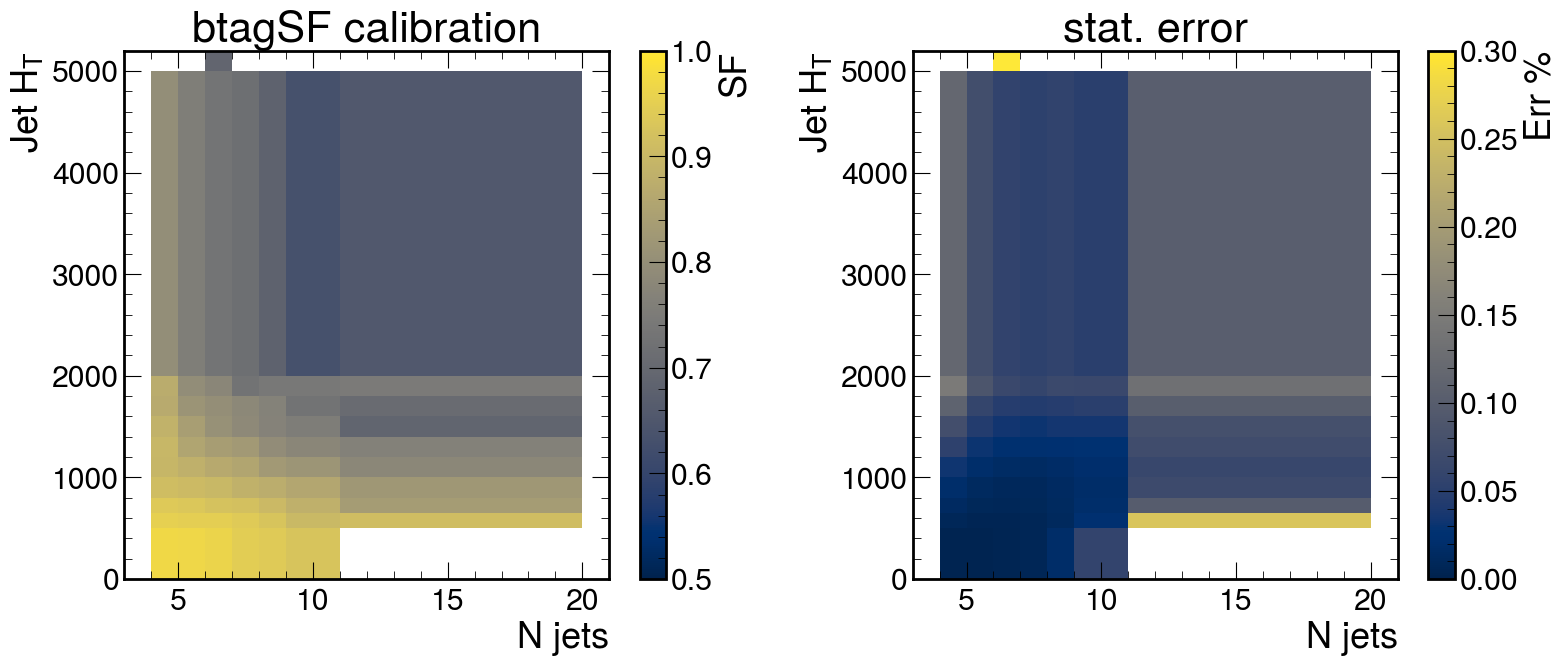

In [104]:
for i in ["bins1","bins2","bins3"]:

    A = output["hist2d_Njet_Ht_"+i].to_hist()

    w_num, x, y = A['ttHTobb','no_btagSF','2018',:,:].to_numpy(flow=True)
    num_var = A['ttHTobb','no_btagSF','2018',:,:].variances(flow=True)
    w_denom, x, y = A['ttHTobb','btagSF','2018',:,:].to_numpy(flow=True)
    denom_var = A['ttHTobb','btagSF','2018',:,:].variances(flow=True)

    ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
    ratio_err =  np.where( (w_denom>0)&(w_num>0),
                          np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                          0.)

    x_plot = x
    y_plot = y
    x_plot[-1] = x_plot[-2]+1
    y_plot[-1] = y_plot[-2]+200
    x_plot[0] = x_plot[1]-1 
    y_plot[0] = -1

    fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
    plt.subplots_adjust(wspace=0.3)

    ax.set_title("btagSF calibration")
    I = ax.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio.T, ratio.T==1.),vmax=1, vmin=0.5, cmap="cividis")
    plt.colorbar(I, ax=ax, label="SF")
    ax.set_xlabel("N jets")
    ax.set_ylabel("Jet $H_T$")

    ay.set_title("stat. error")
    I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.3, vmin=0, cmap="cividis")
    plt.colorbar(I, ax=ay, label="Err %")
    ay.set_xlabel("N jets")
    ay.set_ylabel("Jet $H_T$")

In [8]:
h.axes

(StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2btag', '3btag', 'btagSF', 'no_btagSF'], growth=True, name='cat', label='Cat'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Variable([4, 5, 6, 7, 8, 9, 17], name='Njet', label='N Jets'),
 Variable([0, 500, 750, 1000, 1250, 1500, 2000], name='Ht', label='$H_T$ Jets'))

In [9]:
h = A
sfhist = hist.Hist(h.axes[0],h.axes[2],h.axes[3], data=ratio)

TypeError: label must be a string

# Correctionlib for systematics

In [118]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v40/output.coffea" 
output = load(filename1)
output.keys()

A = output["hist2d_Njet_Ht_bins3"].to_hist()

In [119]:
w_num,  _,_, x, y = A[:,'no_btagSF',:,:,:].to_numpy(flow=True)
num_var = A[:,'no_btagSF',:,:,:].variances(flow=True)
w_denom,  _,_, x, y = A[:, 'btagSF',:,:,:].to_numpy(flow=True)
denom_var = A[:,'no_btagSF',:,:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)
import hist
sfhist = hist.Hist(A.axes[0],A.axes[2],A.axes[3],A.axes[4], data=ratio)

/tmp/ipykernel_51161/3152328602.py:6: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/3152328602.py:8: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/3152328602.py:8: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/3152328602.py:8: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


In [120]:
sfhist.axes

(StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Variable([4, 5, 6, 7, 8, 9, 11, 20], name='Njet', label='N Jets'),
 Variable([0, 500, 650, 800, 1000, 1200, 1400, 1600, 1800, 2000, 5000], name='Ht', label='$H_T$ Jets'))

In [121]:
sfhist["TTToSemiLeptonic","2018",:,:,]

Hist(
  Variable([4, 5, 6, 7, 8, 9, 11, 20], name='Njet', label='N Jets'),
  Variable([0, 500, 650, 800, 1000, 1200, 1400, 1600, 1800, 2000, 5000], name='Ht', label='$H_T$ Jets'),
  storage=Double()) # Sum: 56.08204335003068 (93.84070326975485 with flow)

In [194]:
sfhist["TTToSemiLeptonic","2018",:,:,].variances()

array([[0.99833996, 0.95062897, 0.91399533, 0.87682145, 0.83763145,
        0.80594588, 0.78349166, 0.76428802, 0.74178923, 0.71707841],
       [0.98561605, 0.94924021, 0.9122568 , 0.8729148 , 0.83044893,
        0.79570778, 0.76582027, 0.74875633, 0.73306547, 0.69911406],
       [0.96808433, 0.9421298 , 0.90911095, 0.86835726, 0.82474992,
        0.78927955, 0.75890152, 0.73362224, 0.71282821, 0.68561377],
       [0.94600924, 0.92883912, 0.90040357, 0.86082238, 0.82057451,
        0.77807016, 0.74862432, 0.72247052, 0.69094136, 0.65716096],
       [0.92255624, 0.90843053, 0.88658228, 0.85132216, 0.8077413 ,
        0.77119645, 0.7376424 , 0.70099483, 0.68181315, 0.63939799],
       [0.89346016, 0.88320383, 0.86586598, 0.83389232, 0.79491053,
        0.75574707, 0.71551412, 0.70291158, 0.65881642, 0.63081709],
       [0.9379377 , 0.80782956, 0.86310862, 0.79432248, 0.77450569,
        0.74333226, 0.69168342, 0.66015151, 0.61739054, 0.61942046]])

In [112]:
import correctionlib, rich
import correctionlib.convert
# without a name, the resulting object will fail validation
sfhist.name = "btagSF_norm_correction"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "SF to correct the overall normalization after the application of btagSF weights"

# set overflow bins behavior (default is to raise an error when out of bounds)

for sample_cat in clibcorr.data.content:
    for year_cat in sample_cat.value.content:
        year_cat.value.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="btagSF normalization corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("/work/dvalsecc/ttHbb/PocketCoffea/PocketCoffea/parameters/btag_SF_calibration/btagSF_calibration_allyears_v2.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
btagSF normalization corrections
📂
└── 📈 btagSF_norm_correction (v0)
    SF to correct the overall normalization after the application of btagSF weights
    Node counts: Category: 3, MultiBinning: 2
    ╭───────────── ▶ input ─────────────╮ ╭───────────── ▶ input ─────────────╮
    │ sample (string)                   │ │ year (string)                     │
    │ Sample                            │ │ Year                              │
    │ Values: TTToSemiLeptonic, ttHTobb │ │ Values: 2018                      │
    ╰───────────────────────────────────╯ ╰───────────────────────────────────╯
    ╭───────────── ▶ input ─────────────╮ ╭───────────── ▶ input ─────────────╮
    │ Njet (real)                       │ │ Ht (real)                         │
    │ N Jets                            │ │ $H_T$ Jets                        │
    │ Range: [4.0, 20.0), overflow ok   │ │ Range: [0.0, 5000.0), overflow ok │
    ╰───────────────────────────────────╯ ╰───────────────────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

## Testing the evaluation

In [113]:
cset = correctionlib.CorrectionSet.from_file("/work/dvalsecc/ttHbb/PocketCoffea/PocketCoffea/parameters/btag_SF_calibration/btagSF_calibration_allyears_v2.json")
corr = cset["btagSF_norm_correction"]

In [114]:
Njet = np.array([4,6,8,9,10])
Ht = np.array([500.,1000.,514.,124.,36.])

In [115]:
corr.evaluate("ttHTobb", "2018",Njet,Ht)

array([0.9519474 , 0.86546484, 0.92600897, 0.92651374, 0.92651374])

# Validation in PocketCoffea

In [126]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v32/output.coffea" 
output = load(filename1)
print(output.keys())

A = output["hist2d_Njet_Ht"].to_hist()

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht', 'scale_genweight'])


/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


In [127]:
A

Hist(
  StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
  StrCategory(['2b', '2b_btagSF', '2b_btagSF_calib', '3b', '3b_btagSF', '3b_btagSF_calib', 'btagSF', 'btagSF_calib', 'no_btagSF'], growth=True, name='cat', label='Cat'),
  StrCategory(['2018'], growth=True, name='year', label='Year'),
  Variable([4, 5, 6, 7, 8, 9, 17], name='Njet', label='N Jets'),
  Variable([0, 500, 750, 1000, 1250, 1500, 2000], name='Ht', label='$H_T$ Jets'),
  storage=Weight()) # Sum: WeightedSum(value=1.38922e+07, variance=673772) (WeightedSum(value=1.38969e+07, variance=674061) with flow)

/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


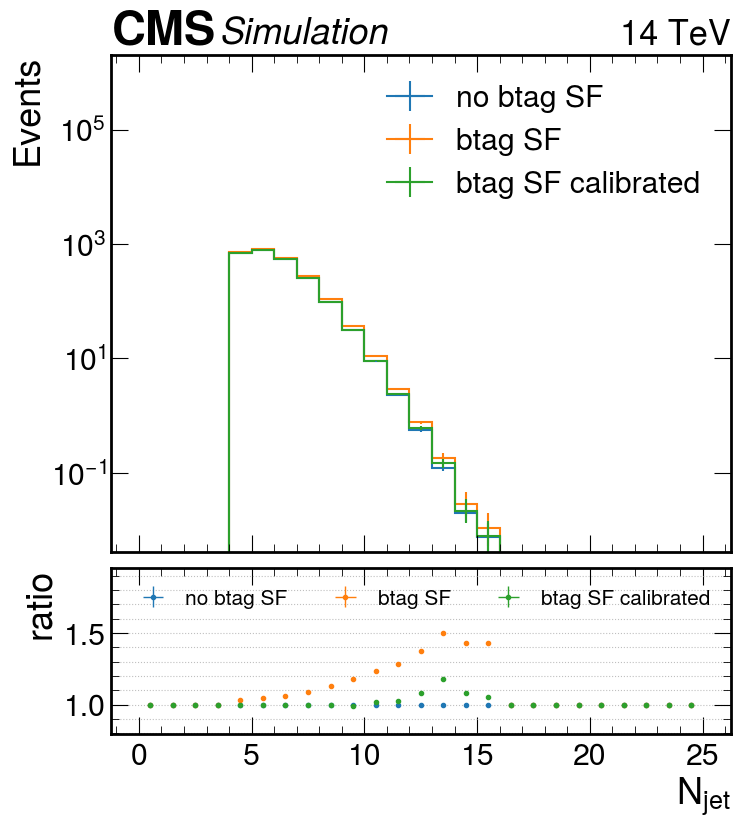

In [128]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


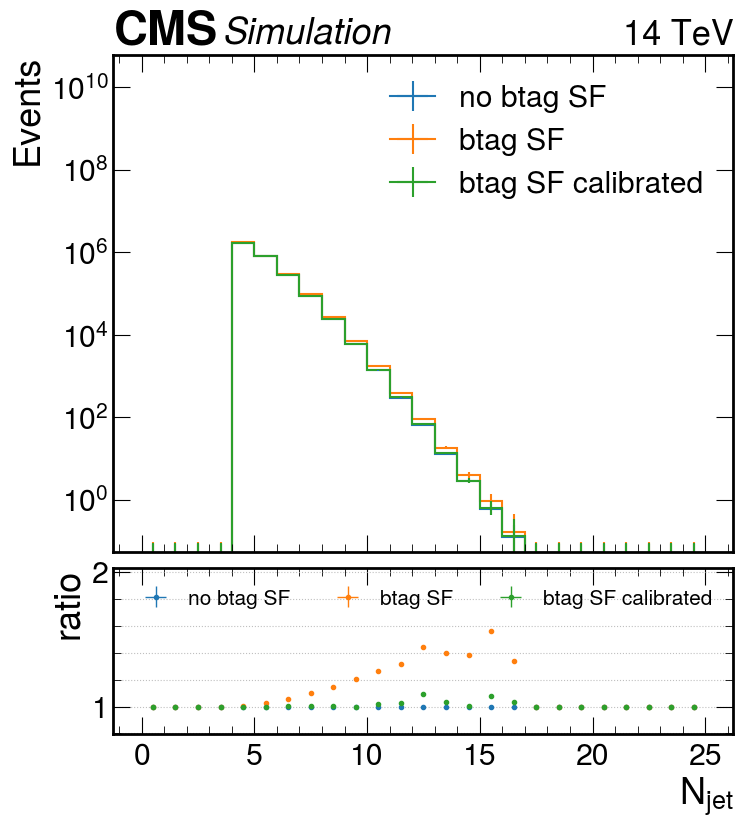

In [64]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


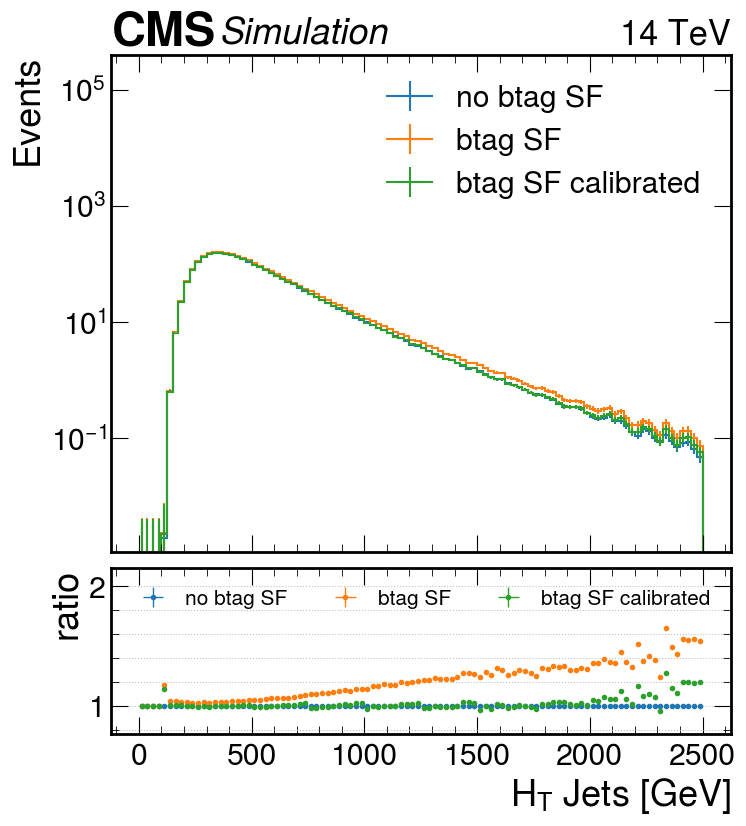

In [65]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


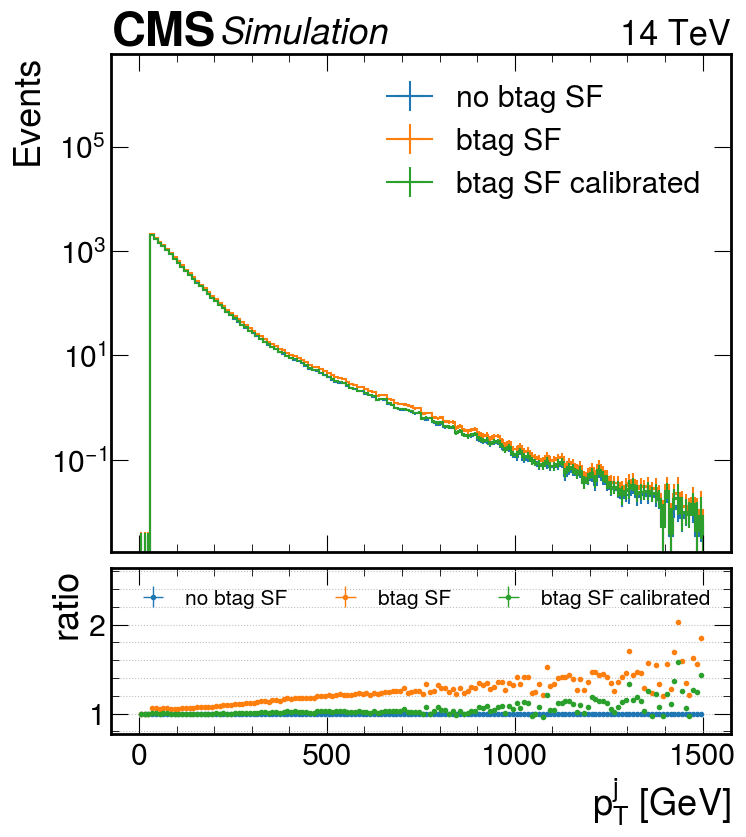

In [66]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


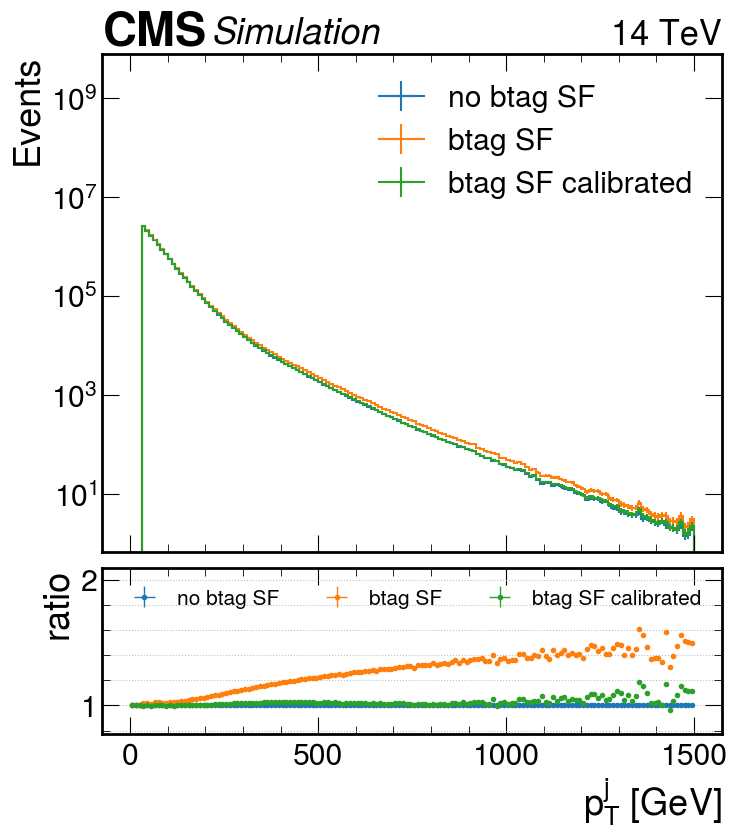

In [67]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


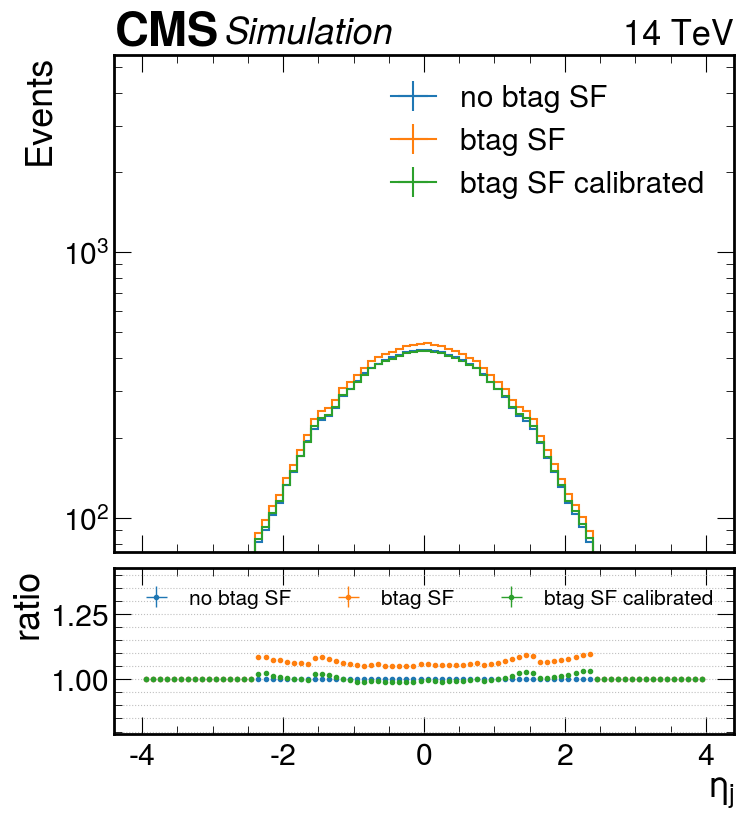

In [68]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


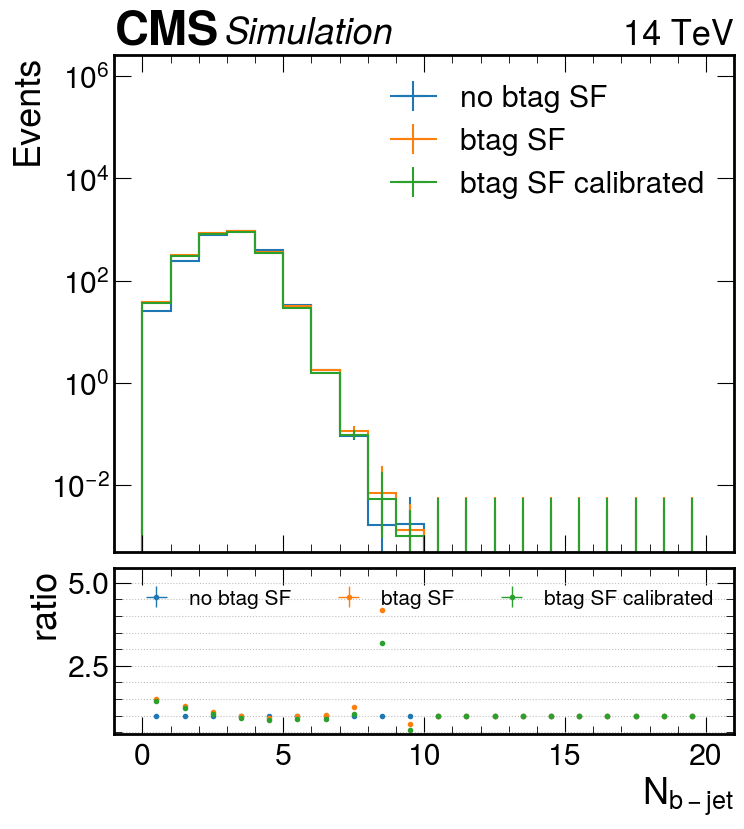

In [71]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_nbjet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


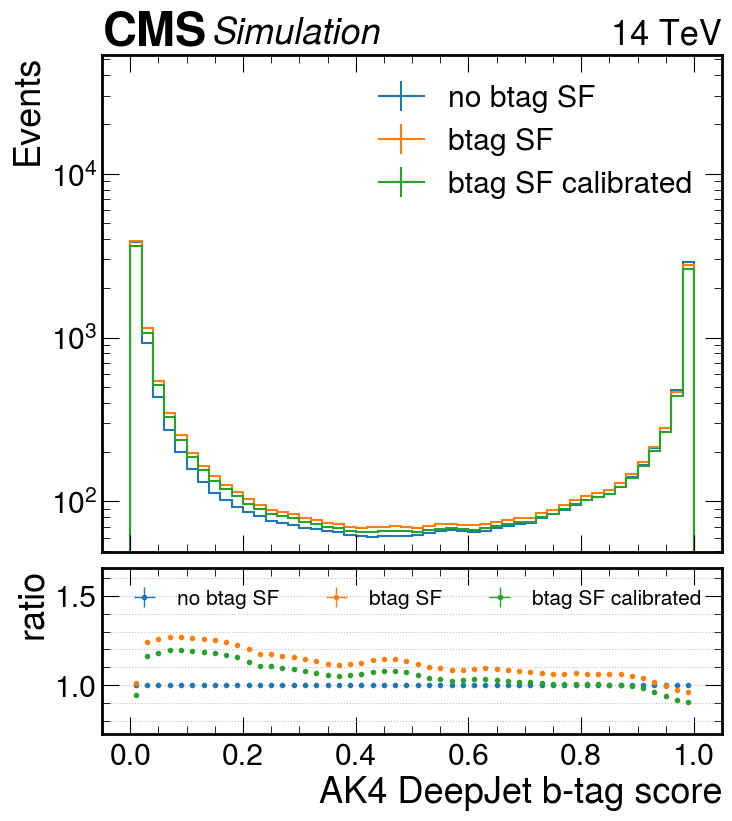

In [69]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


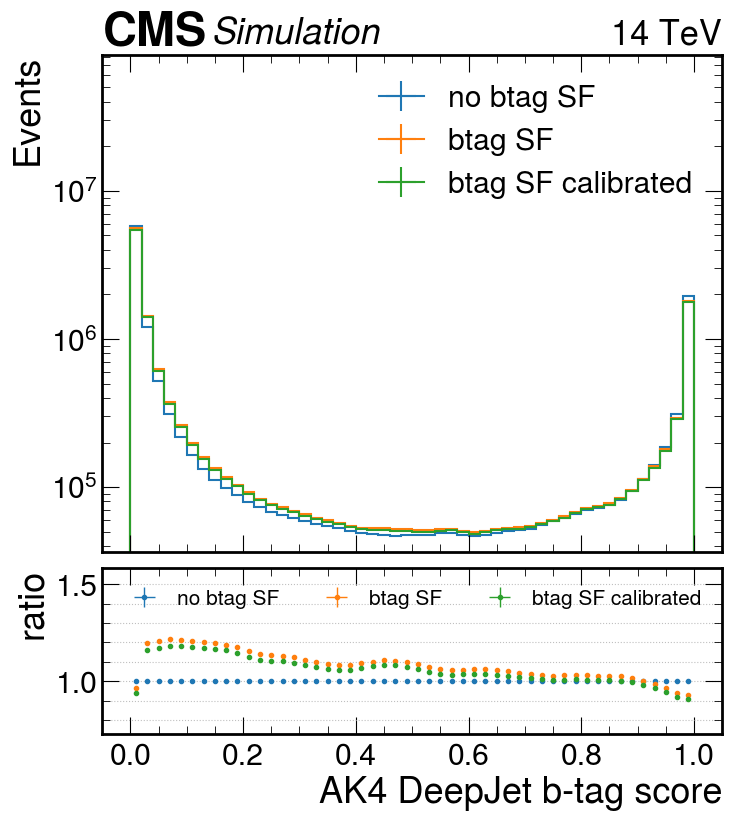

In [70]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

/tmp/ipykernel_51161/2257993790.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/2257993790.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2257993790.py:10: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2257993790.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


Text(0, 1, 'Jet $H_T$')

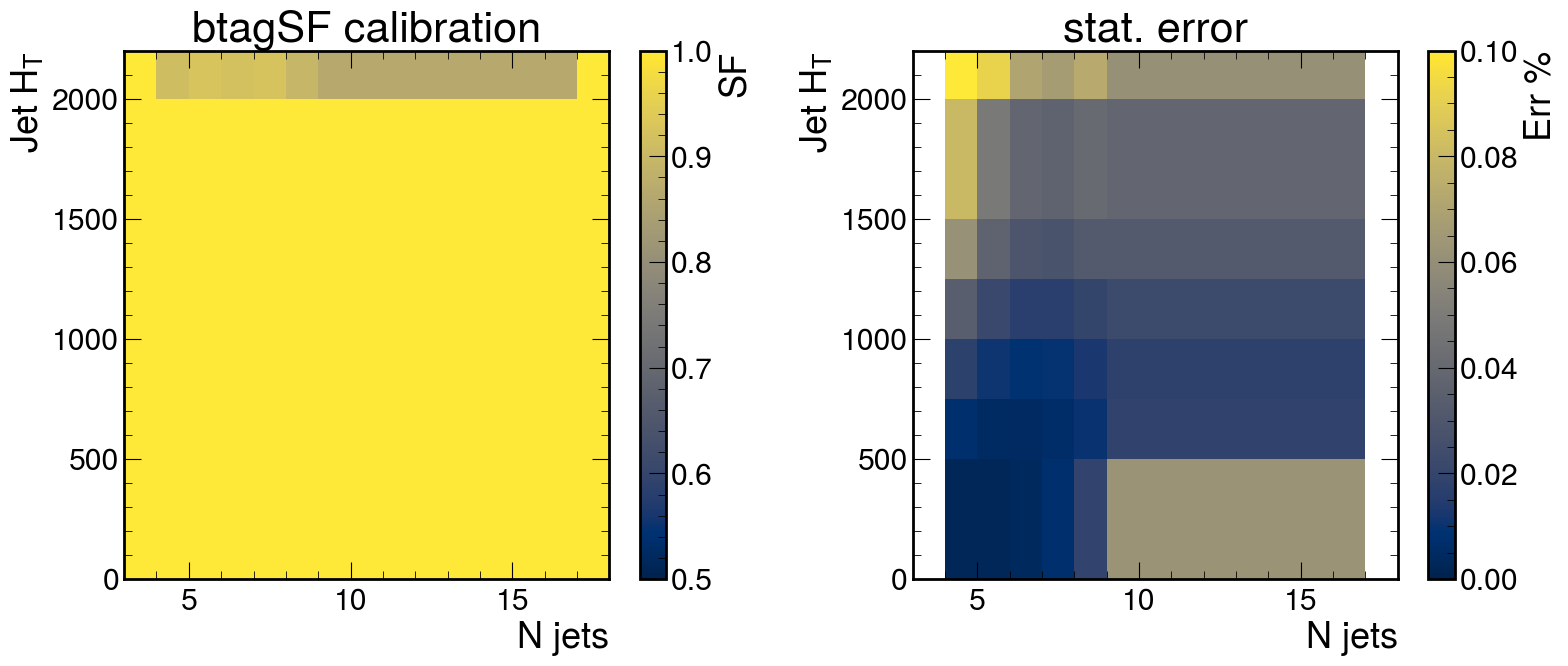

In [59]:
A = output["hist2d_Njet_Ht"].to_hist()

w_num, x, y = A['ttHTobb','no_btagSF','2018',:,:].to_numpy(flow=True)
num_var = A['ttHTobb','no_btagSF','2018',:,:].variances(flow=True)
w_denom, x, y = A['ttHTobb','btagSF_calib','2018',:,:].to_numpy(flow=True)
denom_var = A['ttHTobb','btagSF_calib','2018',:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

x_plot = x
y_plot = y
x_plot[-1] = x_plot[-2]+1
y_plot[-1] = y_plot[-2]+200
x_plot[0] = x_plot[1]-1 
y_plot[0] = -1

fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
plt.subplots_adjust(wspace=0.3)

ax.set_title("btagSF calibration")
I = ax.pcolormesh(x_plot,y_plot, ratio.T,vmax=1, vmin=0.5, cmap="cividis")
plt.colorbar(I, ax=ax, label="SF")
ax.set_xlabel("N jets")
ax.set_ylabel("Jet $H_T$")

ay.set_title("stat. error")
I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.10, vmin=0, cmap="cividis")
plt.colorbar(I, ax=ay, label="Err %")
ay.set_xlabel("N jets")
ay.set_ylabel("Jet $H_T$")

## Validation with correction from smaller bins

In [129]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v43/output.coffea" 
output = load(filename1)
print(output.keys())


dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht_bins1', 'hist2d_Njet_Ht_bins3', 'scale_genweight'])


/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/1429477823.py:42: RuntimeWarning: divide by zero encountered in true_divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_51161/1429477823.py:42: RuntimeWarning: invalid value encountered in multiply
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_51161/1429477823.py:42: RuntimeWarning: invalid value encountered in true_divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_51161/1429477823.py:43: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


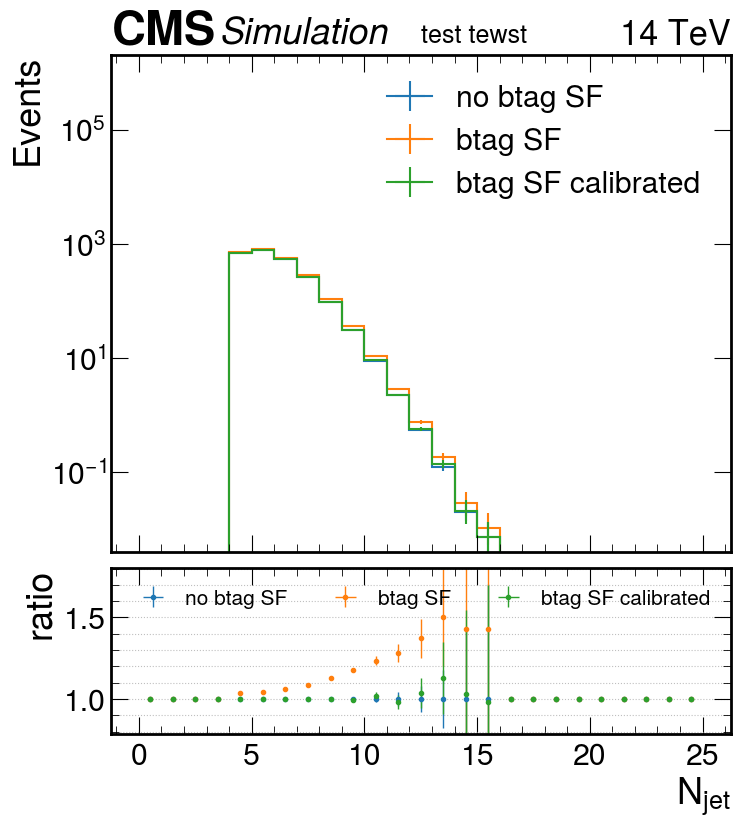

In [200]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


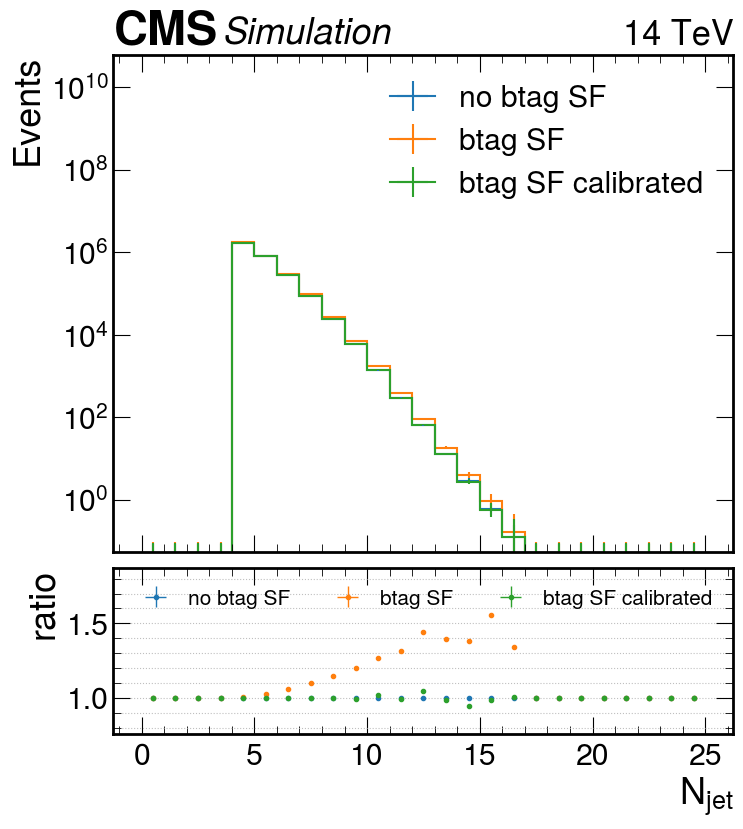

In [143]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


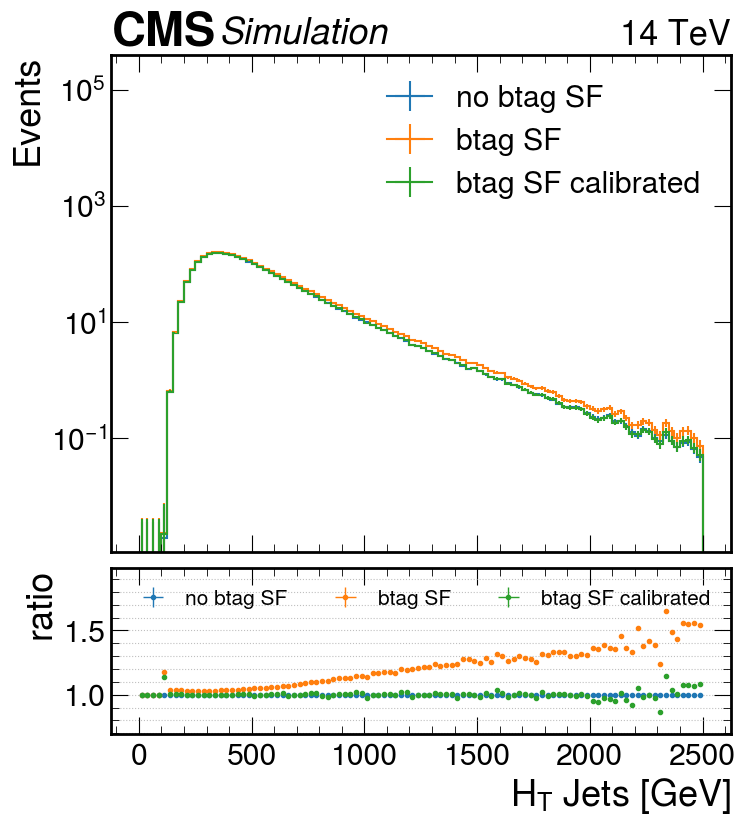

In [144]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


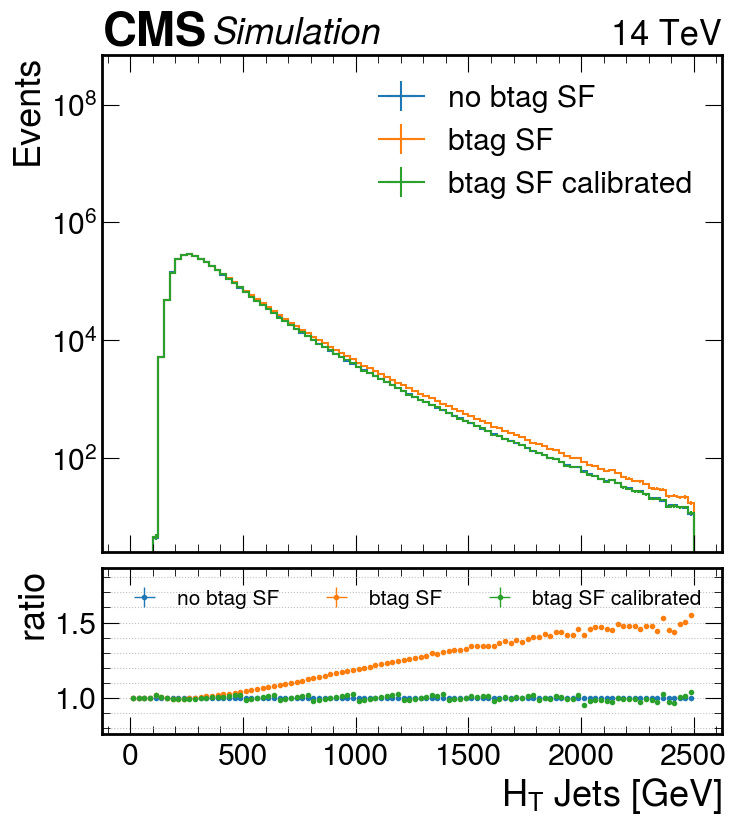

In [145]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


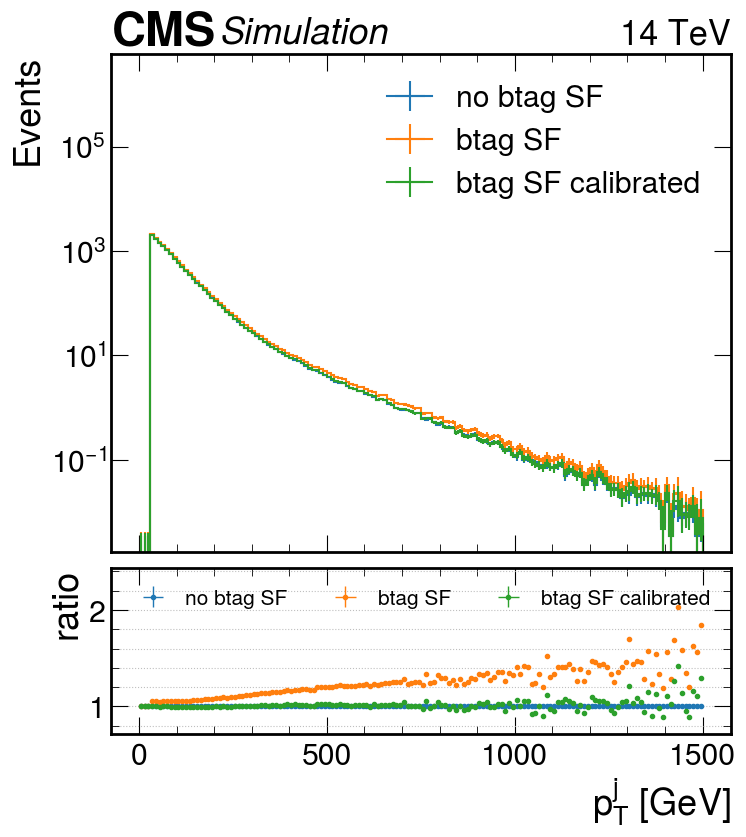

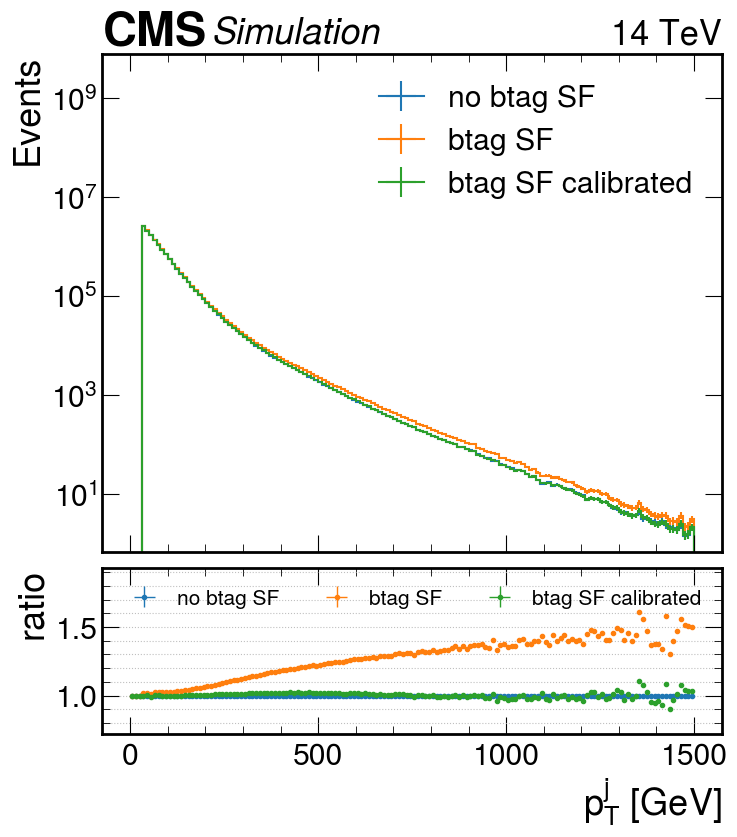

In [146]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


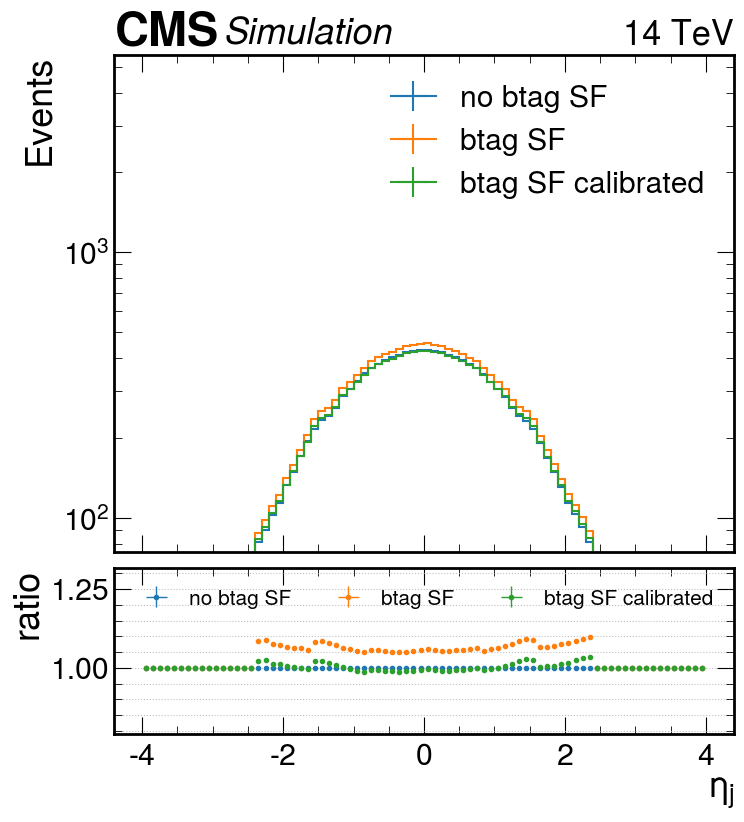

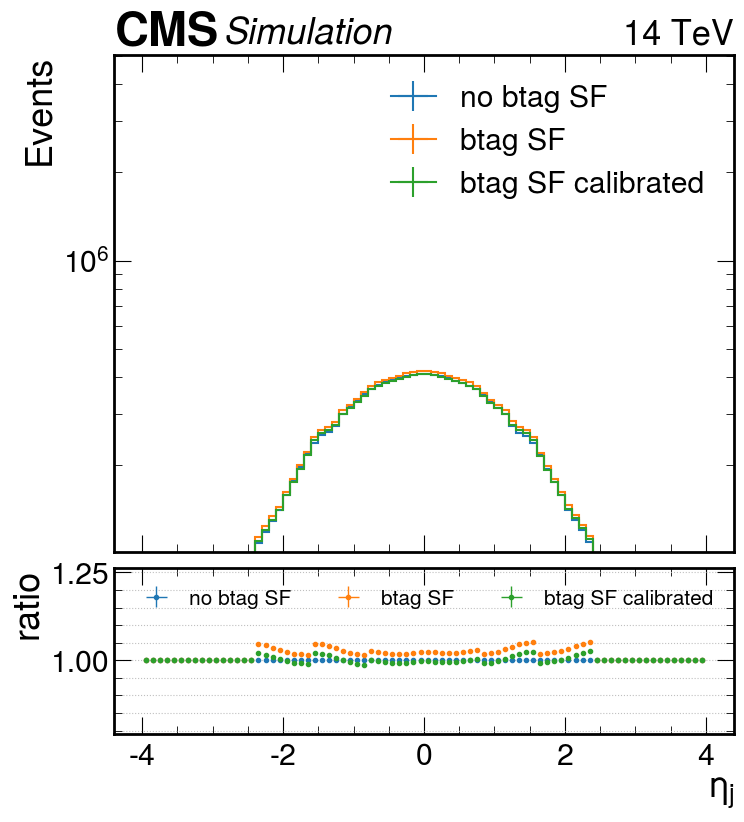

In [147]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


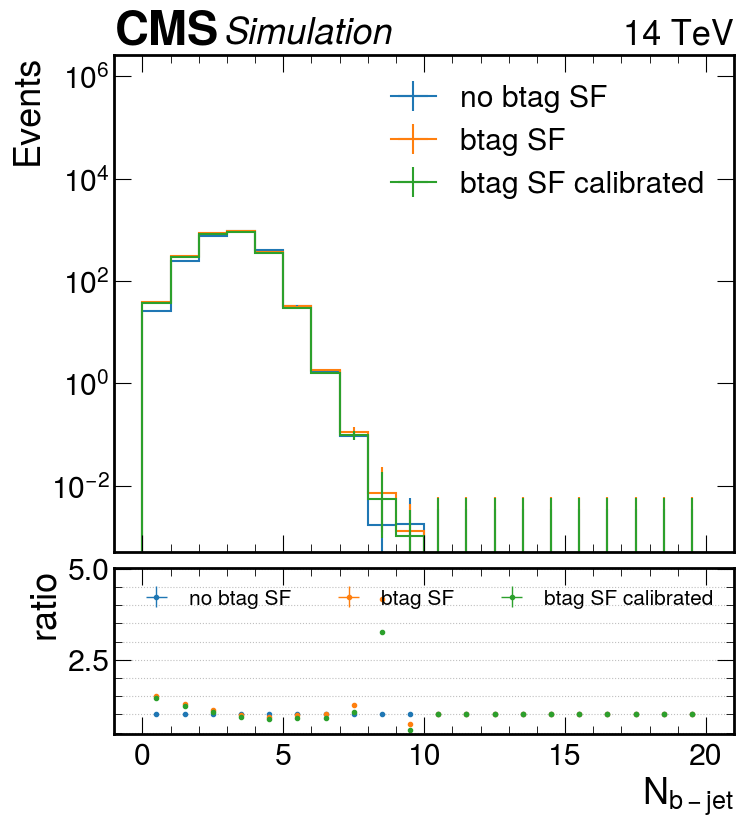

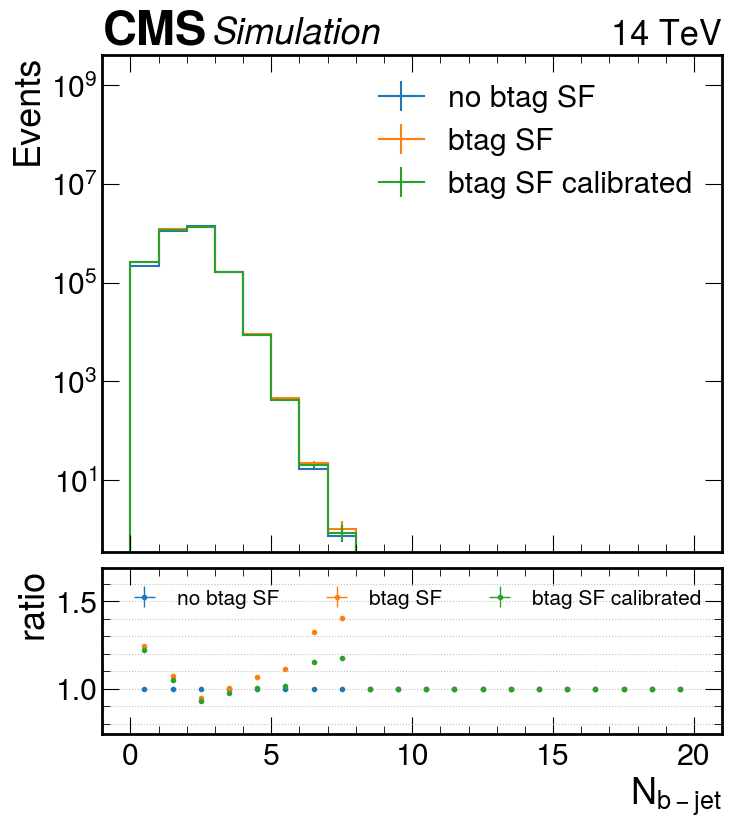

In [148]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_nbjet", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_nbjet", shapes, ylog=True)

In [185]:
a = output["hist_njet"]

In [191]:
list(a.axes()[0])


TypeError: Expected a StringBin object, got: 0

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


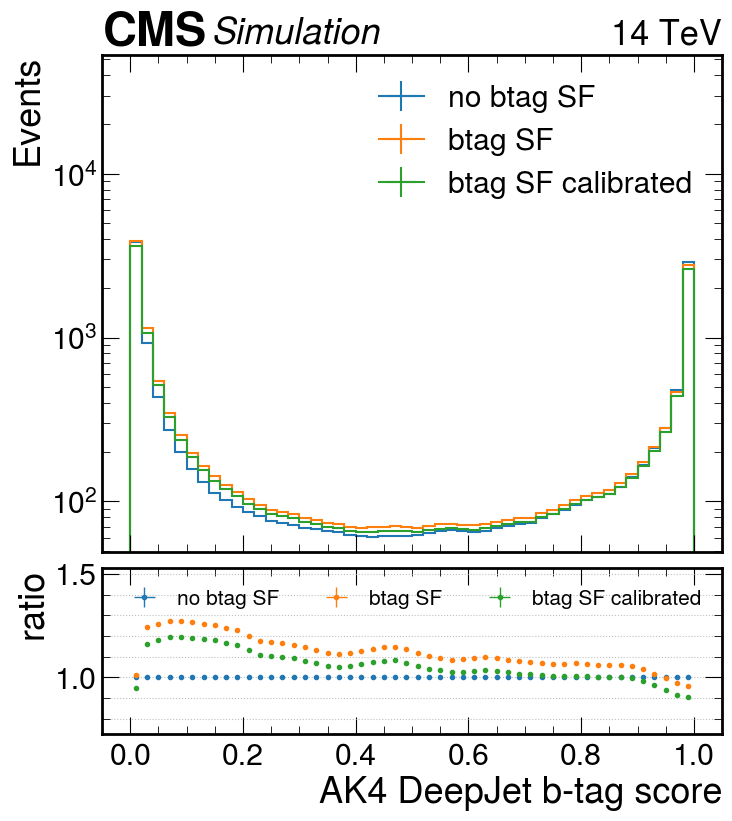

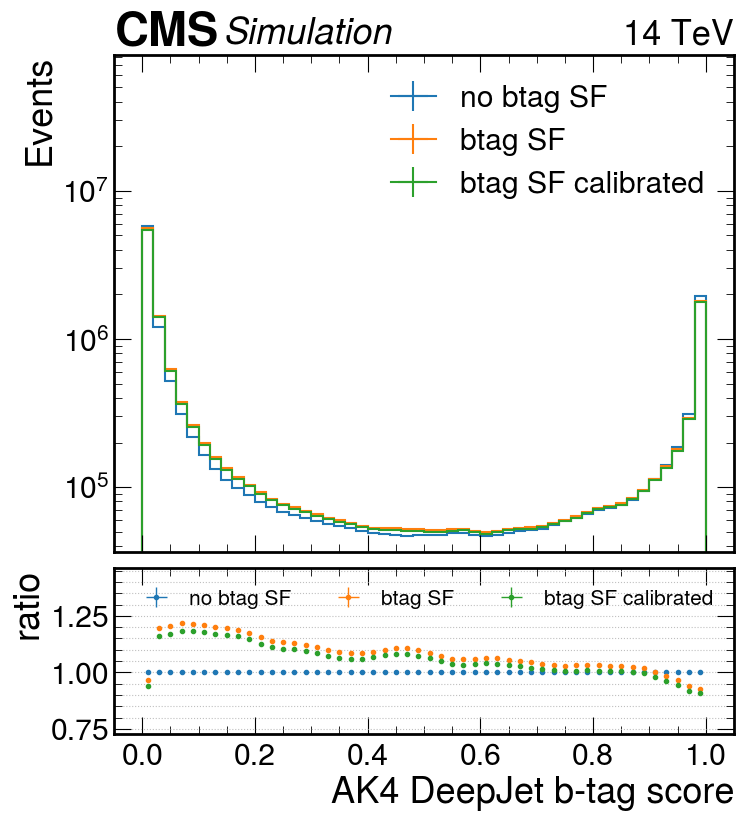

In [152]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/1266912771.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/1266912771.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/1266912771.py:10: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/1266912771.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


Text(0, 1, 'Jet $H_T$')

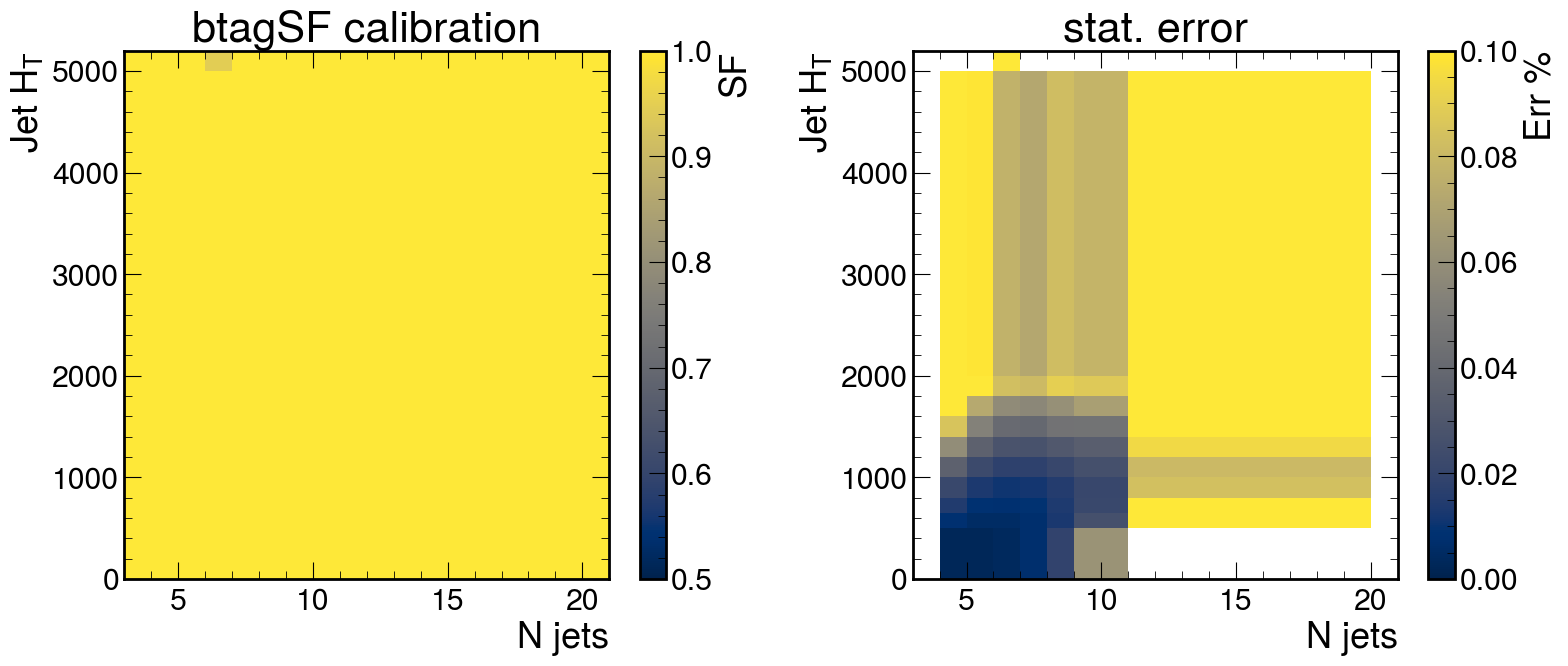

In [150]:
A = output["hist2d_Njet_Ht_bins3"].to_hist()

w_num, x, y = A['ttHTobb','no_btagSF','2018',:,:].to_numpy(flow=True)
num_var = A['ttHTobb','no_btagSF','2018',:,:].variances(flow=True)
w_denom, x, y = A['ttHTobb','btagSF_calib','2018',:,:].to_numpy(flow=True)
denom_var = A['ttHTobb','btagSF_calib','2018',:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

x_plot = x
y_plot = y
x_plot[-1] = x_plot[-2]+1
y_plot[-1] = y_plot[-2]+200
x_plot[0] = x_plot[1]-1 
y_plot[0] = -1

fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
plt.subplots_adjust(wspace=0.3)

ax.set_title("btagSF calibration")
I = ax.pcolormesh(x_plot,y_plot, ratio.T,vmax=1, vmin=0.5, cmap="cividis")
plt.colorbar(I, ax=ax, label="SF")
ax.set_xlabel("N jets")
ax.set_ylabel("Jet $H_T$")

ay.set_title("stat. error")
I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.10, vmin=0, cmap="cividis")
plt.colorbar(I, ax=ay, label="Err %")
ay.set_xlabel("N jets")
ay.set_ylabel("Jet $H_T$")

/tmp/ipykernel_51161/2468427268.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/2468427268.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2468427268.py:10: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2468427268.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


Text(0, 1, 'Jet $H_T$')

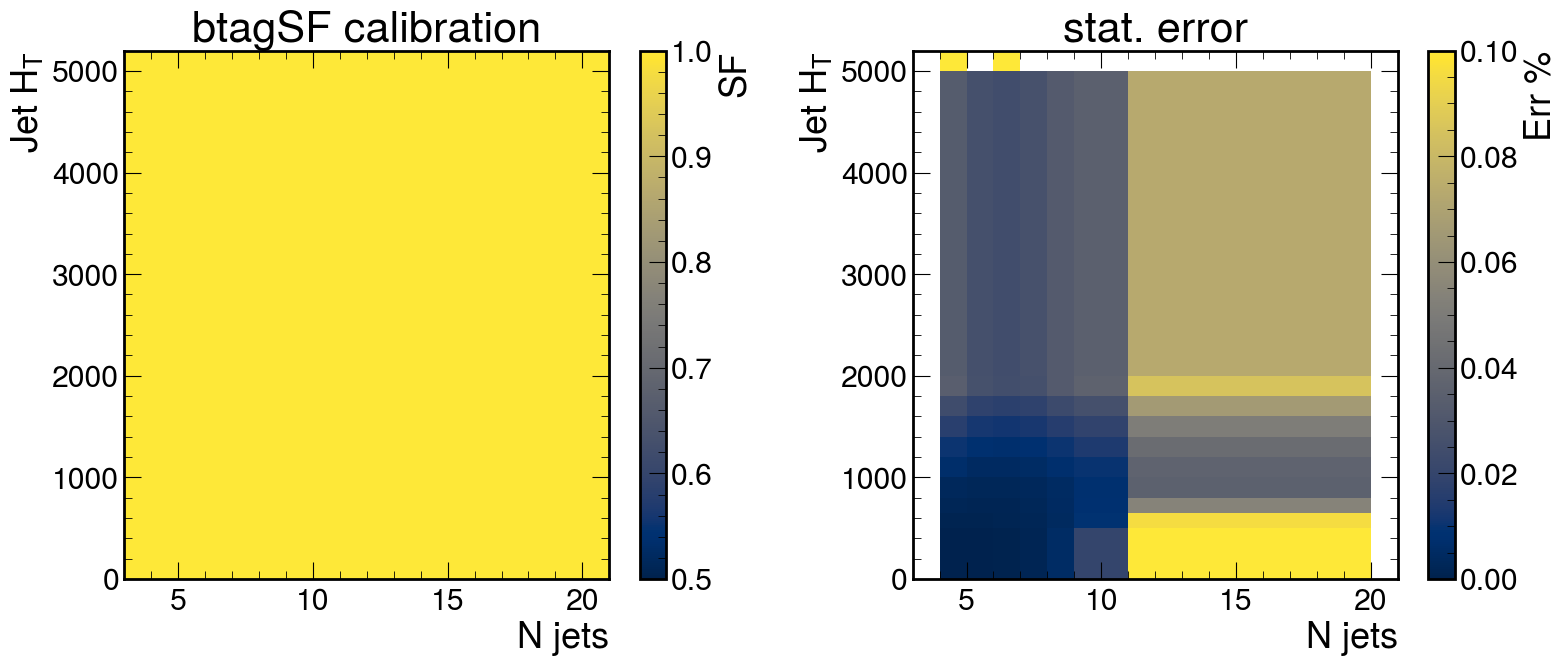

In [140]:
A = output["hist2d_Njet_Ht_bins3"].to_hist()

w_num, x, y = A['TTToSemiLeptonic','no_btagSF','2018',:,:].to_numpy(flow=True)
num_var = A['TTToSemiLeptonic','no_btagSF','2018',:,:].variances(flow=True)
w_denom, x, y = A['TTToSemiLeptonic','btagSF_calib','2018',:,:].to_numpy(flow=True)
denom_var = A['TTToSemiLeptonic','btagSF_calib','2018',:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

x_plot = x
y_plot = y
x_plot[-1] = x_plot[-2]+1
y_plot[-1] = y_plot[-2]+200
x_plot[0] = x_plot[1]-1 
y_plot[0] = -1

fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
plt.subplots_adjust(wspace=0.3)

ax.set_title("btagSF calibration")
I = ax.pcolormesh(x_plot,y_plot, ratio.T,vmax=1, vmin=0.5, cmap="cividis")
plt.colorbar(I, ax=ax, label="SF")
ax.set_xlabel("N jets")
ax.set_ylabel("Jet $H_T$")

ay.set_title("stat. error")
I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.10, vmin=0, cmap="cividis")
plt.colorbar(I, ax=ay, label="Err %")
ay.set_xlabel("N jets")
ay.set_ylabel("Jet $H_T$")

# Compare with new hist UL BPOG files (12/09/2022)

In [83]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v43_final/output.coffea" 
output0 = load(filename1)
print(output0.keys())

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht_bins1', 'hist2d_Njet_Ht_bins3', 'scale_genweight'])


In [84]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_hist_oldbtagfile/output.coffea" 
output = load(filename1)
print(output.keys())

dict_keys(['sum_genweights', 'sumw', 'cutflow', 'seed_chunk', 'variables', 'columns', 'processing_metadata', 'scale_genweight'])


In [85]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_hist_v08/output.coffea" 
output2 = load(filename1)
print(output.keys())

dict_keys(['sum_genweights', 'sumw', 'cutflow', 'seed_chunk', 'variables', 'columns', 'processing_metadata', 'scale_genweight'])


In [86]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffeaReference/output/btagSF_calibration_hist_oldbtagfile_oldcode/output.coffea" 
output3 = load(filename1)
print(output3.keys())

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht_bins1', 'hist2d_Njet_Ht_bins3', 'scale_genweight'])


In [139]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_hist_newbtagfile_nojetpuid/output.coffea" 
output4 = load(filename1)
print(output4.keys())

dict_keys(['sum_genweights', 'sumw', 'cutflow', 'seed_chunk', 'variables', 'columns', 'processing_metadata', 'scale_genweight'])


In [203]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffeaReference/output/btagSF_calibration_sep1code_newbtagsffile/output.coffea" 
output_sep1 = load(filename1)
print(output4.keys())


dict_keys(['sum_genweights', 'sumw', 'cutflow', 'seed_chunk', 'variables', 'columns', 'processing_metadata', 'scale_genweight'])


In [220]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffeaReference/output/btagSF_calibration_sep1code_veryoldbtagsffile/output.coffea" 
output_sep1_oldfile = load(filename1)
print(output4.keys())

dict_keys(['sum_genweights', 'sumw', 'cutflow', 'seed_chunk', 'variables', 'columns', 'processing_metadata', 'scale_genweight'])


In [223]:
h_original = output0["hist_jet_pt"].to_hist()
h_new_oldfile = output["variables"]["jet_pt"]['ttHTobb']
h_new_newfile = output2["variables"]["jet_pt"]['ttHTobb']
h_new_nojetput = output4["variables"]["jet_pt"]['ttHTobb']
h_orig_redo = output3["hist_jet_pt"].to_hist()
h_orig_redo_sep1commit = output_sep1["hist_jet_pt"].to_hist()
h_orig_redo_sep1commit_oldfile = output_sep1_oldfile["hist_jet_pt"].to_hist()

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


In [161]:
output4["cutflow"]

{'initial': {'ttHTobb': 9668000, 'TTToSemiLeptonic': 476408000},
 'skim': {'ttHTobb': 2295568, 'TTToSemiLeptonic': 181939487},
 'presel': {'ttHTobb': 1358248, 'TTToSemiLeptonic': 64817039},
 'no_btagSF': {'ttHTobb': 1358248.0, 'TTToSemiLeptonic': 64817039.0},
 'btagSF': {'ttHTobb': 1358248.0, 'TTToSemiLeptonic': 64817039.0}}

In [162]:
output3["cutflow"]

{'no_btagSF': defaultdict_accumulator(int,
                         {'ttHTobb': 1358248, 'TTToSemiLeptonic': 64817039}),
 'btagSF': defaultdict_accumulator(int,
                         {'ttHTobb': 1358248, 'TTToSemiLeptonic': 64817039}),
 'btagSF_calib': defaultdict_accumulator(int,
                         {'ttHTobb': 1358248, 'TTToSemiLeptonic': 64817039}),
 '2b': defaultdict_accumulator(int,
                         {'ttHTobb': 1208252, 'TTToSemiLeptonic': 35349755}),
 '3b': defaultdict_accumulator(int,
                         {'ttHTobb': 777621, 'TTToSemiLeptonic': 3901337}),
 '2b_btagSF': defaultdict_accumulator(int,
                         {'ttHTobb': 1208252, 'TTToSemiLeptonic': 35349755}),
 '3b_btagSF': defaultdict_accumulator(int,
                         {'ttHTobb': 777621, 'TTToSemiLeptonic': 3901337}),
 'initial': defaultdict_accumulator(int,
                         {'ttHTobb': 9668000, 'TTToSemiLeptonic': 476408000}),
 'skim': defaultdict_accumulator(int,
             

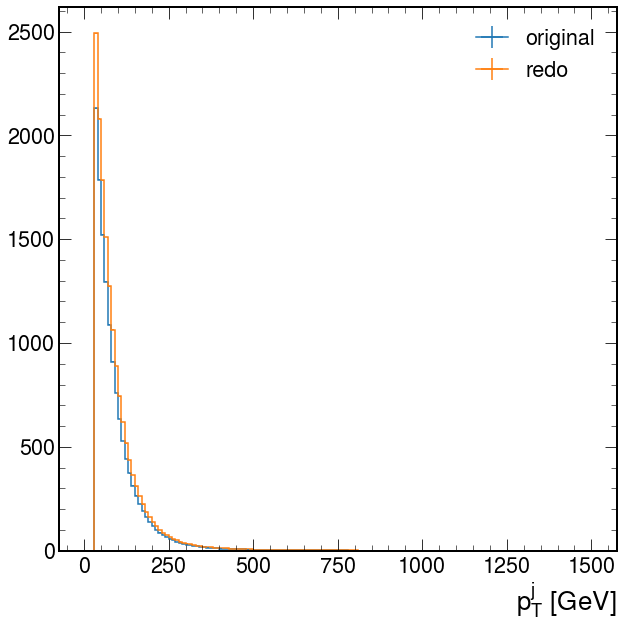

In [94]:
hep.histplot(h_original["ttHTobb", "btagSF", "2018",:], label="original")
hep.histplot(h_orig_redo["ttHTobb", "btagSF", "2018",:], label="redo")
plt.legend()

(0.0, 300.0)

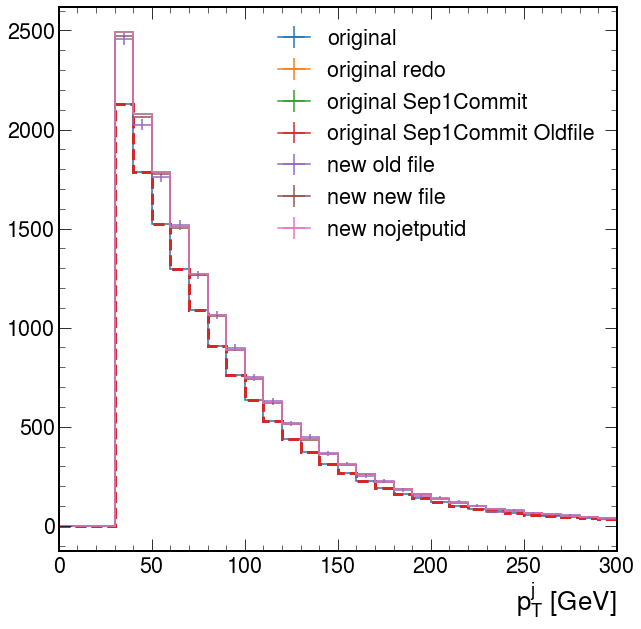

In [225]:
hep.histplot(h_original["ttHTobb", "btagSF", "2018",:], label="original")
hep.histplot(h_orig_redo["ttHTobb", "btagSF", "2018",:], label="original redo")
hep.histplot(h_orig_redo_sep1commit["ttHTobb", "btagSF", "2018",:], label="original Sep1Commit")
hep.histplot(h_orig_redo_sep1commit_oldfile["ttHTobb", "btagSF", "2018",:], label="original Sep1Commit Oldfile", linewidth=3, linestyle="dashed")
hep.histplot(h_new_oldfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new old file")
hep.histplot(h_new_newfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new new file")
hep.histplot(h_new_nojetput[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new nojetputid")
#plt.yscale("log")
plt.legend()
plt.xlim(0, 300)

(0.0, 300.0)

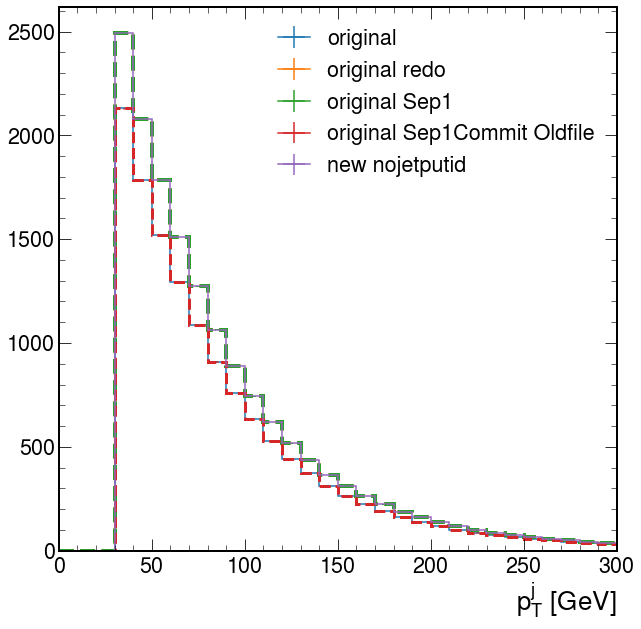

In [227]:
hep.histplot(h_original["ttHTobb", "btagSF", "2018",:], label="original")
hep.histplot(h_orig_redo["ttHTobb", "btagSF", "2018",:], label="original redo", linewidth=4, linestyle="dashed")
hep.histplot(h_orig_redo_sep1commit["ttHTobb", "btagSF", "2018",:], label="original Sep1", linewidth=4, linestyle="dashed")
hep.histplot(h_orig_redo_sep1commit_oldfile["ttHTobb", "btagSF", "2018",:], label="original Sep1Commit Oldfile", linewidth=3, linestyle="dashed")
#hep.histplot(h_new_oldfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new old file")
#hep.histplot(h_new_newfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new new file")
hep.histplot(h_new_nojetput[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new nojetputid")
#plt.yscale("log")
plt.legend()
plt.xlim(0, 300)

(0.0, 300.0)

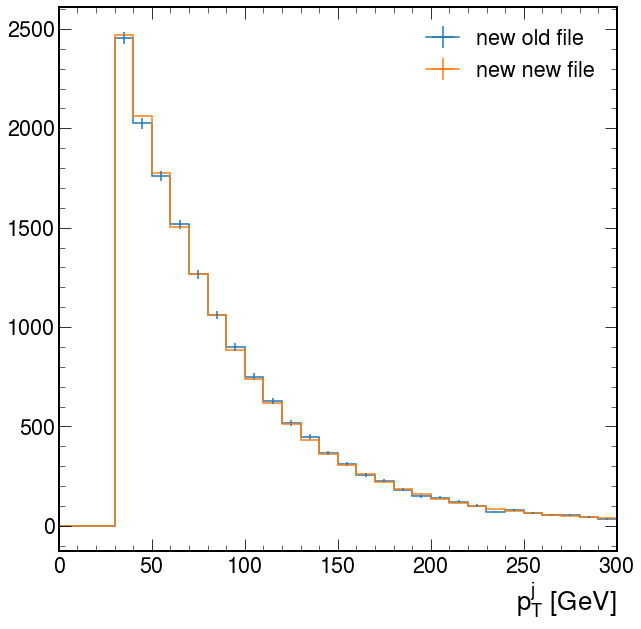

In [151]:
#hep.histplot(h_original["ttHTobb", "btagSF", "2018",:], label="original")
#hep.histplot(h_orig_redo["ttHTobb", "btagSF", "2018",:], label="original redo", linewidth=4, linestyle="dashed")
hep.histplot(h_new_oldfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new old file")
hep.histplot(h_new_newfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new new file")
hep.histplot(h_orig_redo_sep1commit_oldfile["ttHTobb", "btagSF", "2018",:], label="original Sep1Commit Oldfile", linewidth=3, linestyle="dashed")
#hep.histplot(h_new_nojetput[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new nojetputid")
#plt.yscale("log")
plt.legend()
plt.xlim(0, 300)

In [262]:
h_original = output0["hist_njet"].to_hist()
h_new_oldfile = output["variables"]["nJets"]['TTToSemiLeptonic']
h_new_newfile = output2["variables"]["nJets"]['TTToSemiLeptonic']
h_new_nojetput = output4["variables"]["nJets"]['TTToSemiLeptonic']
h_orig_redo = output3["hist_njet"].to_hist()
h_orig_redo_sep1commit = output_sep1["hist_njet"].to_hist()
h_orig_redo_sep1commit_oldfile = output_sep1_oldfile["hist_njet"].to_hist()

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


In [171]:
h_orig_redo["ttHTobb", "btagSF", "2018",sum]

WeightedSum(value=2971.66, variance=7.6357)

In [197]:
output0["sumw"]

{'no_btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2418.5904766973254,
                          'TTToSemiLeptonic': 2906155.995721682}),
 'btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2554.5479264191567,
                          'TTToSemiLeptonic': 2968541.3660247503}),
 'btagSF_calib': defaultdict_accumulator(float,
                         {'ttHTobb': 2418.5905817508606,
                          'TTToSemiLeptonic': 2906155.976797107}),
 '2b': defaultdict_accumulator(float,
                         {'ttHTobb': 2150.157092703085,
                          'TTToSemiLeptonic': 1584013.521089998}),
 '3b': defaultdict_accumulator(float,
                         {'ttHTobb': 1381.8292407112867,
                          'TTToSemiLeptonic': 174946.20116611302}),
 '2b_btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2201.9737183326624,
                          'TTToSemiLeptonic': 1513102.232581582}),

In [198]:
output3["sumw"]

{'no_btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2418.590476697325,
                          'TTToSemiLeptonic': 2906155.9957216824}),
 'btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2971.6589647574997,
                          'TTToSemiLeptonic': 3319562.8105528294}),
 'btagSF_calib': defaultdict_accumulator(float,
                         {'ttHTobb': 2418.590476697325,
                          'TTToSemiLeptonic': 2906155.9957216824}),
 '2b': defaultdict_accumulator(float,
                         {'ttHTobb': 2150.1570927030853,
                          'TTToSemiLeptonic': 1584013.5210899978}),
 '3b': defaultdict_accumulator(float,
                         {'ttHTobb': 1381.8292407112865,
                          'TTToSemiLeptonic': 174946.20116611294}),
 '2b_btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2559.236203369995,
                          'TTToSemiLeptonic': 1685484.8529318743}

In [172]:
output4["sumw"]

{'no_btagSF': {'ttHTobb': 2418.5902816094303,
  'TTToSemiLeptonic': 2906156.0727804094},
 'btagSF': {'ttHTobb': 2971.6587250580974,
  'TTToSemiLeptonic': 3319562.8985733227}}

In [204]:
output_sep1["sumw"]

{'no_btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2418.590476697325,
                          'TTToSemiLeptonic': 2906155.9957216824}),
 'btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2971.6589647574997,
                          'TTToSemiLeptonic': 3319562.8105528294}),
 'btagSF_calib': defaultdict_accumulator(float,
                         {'ttHTobb': 2418.590476697325,
                          'TTToSemiLeptonic': 2906155.9957216824}),
 '2b': defaultdict_accumulator(float,
                         {'ttHTobb': 2150.1570927030853,
                          'TTToSemiLeptonic': 1584013.5210899978}),
 '3b': defaultdict_accumulator(float,
                         {'ttHTobb': 1381.8292407112865,
                          'TTToSemiLeptonic': 174946.20116611294}),
 '2b_btagSF': defaultdict_accumulator(float,
                         {'ttHTobb': 2559.236203369995,
                          'TTToSemiLeptonic': 1685484.8529318743}

In [214]:
sum_original = h_original['ttHTobb', 'btagSF', '2018',:].values().sum()
sum_original_redo = h_orig_redo['ttHTobb', 'btagSF', '2018',:].values().sum()
sum_new = h_new_nojetput['btagSF', 'nominal','2018',:].values().sum()
sum_sep1 =h_orig_redo_sep1commit['ttHTobb', 'btagSF', '2018',:].values().sum()

In [263]:
ratio = h_new_nojetput['btagSF', 'nominal','2018',:].values().sum() / h_orig_redo_sep1commit_oldfile['TTToSemiLeptonic', 'btagSF', '2018',:].values().sum()

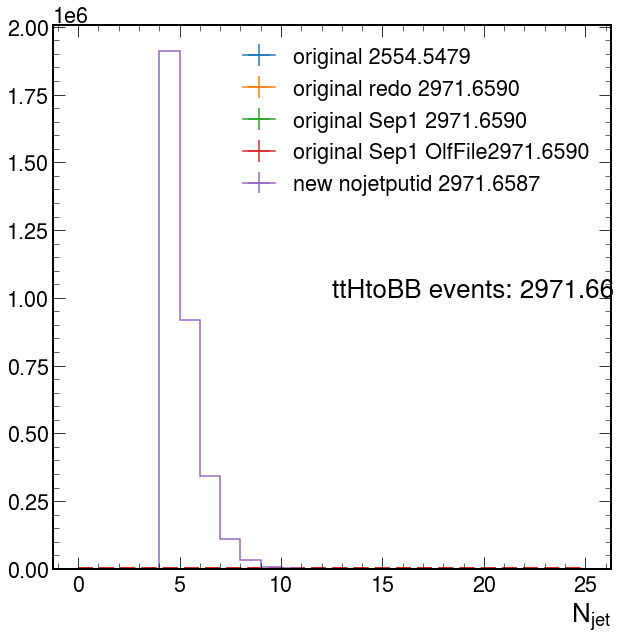

In [264]:
hep.histplot(h_original["ttHTobb", "btagSF", "2018",:], label=f"original {sum_original:.4f}")
hep.histplot(h_orig_redo["ttHTobb", "btagSF", "2018",:], label=f"original redo {sum_original_redo:.4f}", linewidth=4, linestyle="dashed")
hep.histplot(h_orig_redo_sep1commit["ttHTobb", "btagSF", "2018",:], label=f"original Sep1 {sum_sep1:.4f}", linewidth=4, linestyle="dashed")
hep.histplot(h_orig_redo_sep1commit_oldfile["ttHTobb", "btagSF", "2018",:], label=f"original Sep1 OlfFile{sum_sep1:.4f}", linewidth=4, linestyle="dashed")
#hep.histplot(h_new_oldfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new old file")
#hep.histplot(h_new_newfile[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label="new new file")
hep.histplot(h_new_nojetput[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label=f"new nojetputid {sum_new:.4f}")
plt.text(0.5,0.5, f"ttHtoBB events: 2971.66",transform=plt.gca().transAxes)
#plt.yscale("log")
plt.legend()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

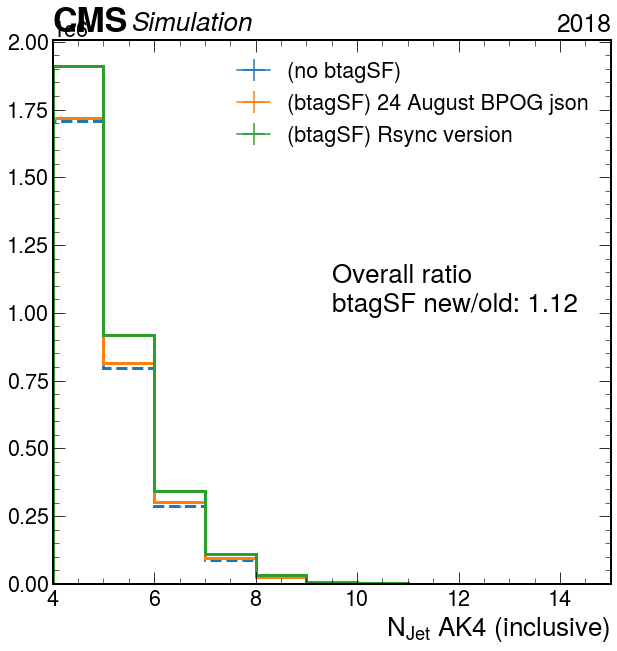

In [265]:
hep.histplot(h_orig_redo_sep1commit_oldfile["TTToSemiLeptonic", "no_btagSF", "2018",:], label=f"(no btagSF)", linewidth=3, linestyle="dashed")
hep.histplot(h_orig_redo_sep1commit_oldfile["TTToSemiLeptonic", "btagSF", "2018",:], label=f"(btagSF) 24 August BPOG json", linewidth=3,)

hep.histplot(h_new_nojetput[{"cat":"btagSF", "year":"2018","variation":"nominal"}], label=f"(btagSF) Rsync version", linewidth=3)
plt.text(0.5,0.5, f"Overall ratio\nbtagSF new/old: {ratio:.2f}",transform=plt.gca().transAxes)
#plt.yscale("log")
plt.xlim(4, 15)
plt.legend()
plt.xlabel("$N_{Jet}$ AK4 (inclusive)")
hep.cms.label(rlabel="2018")
#plt.savefig("output/check_btagsf_change.png")

In [37]:
h1["ttHTobb","btagSF",'2018',:].to_hist()

Hist(
  StrCategory(['ttHTobb'], growth=True, name='sample', label='Sample'),
  StrCategory(['btagSF'], growth=True, name='cat', label='Cat'),
  StrCategory(['2018'], growth=True, name='year', label='Year'),
  Regular(25, 0, 25, name='njet', label='$N_{jet}$'),
  storage=Weight()) # Sum: WeightedSum(value=2554.55, variance=5.6632)

In [36]:
h2[{"cat":"btagSF", "year":"2018"}].values() / h1["ttHTobb","btagSF",'2018',:].to_hist()

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [38]:
np.array([8.11127285e+02, 9.43414862e+02, 6.74039926e+02, 3.33574996e+02,
        1.31671517e+02, 4.38486856e+01, 1.33033234e+01, 3.44249676e+00,
        9.13267681e-01, 2.16017993e-01]) / np.array([7.17000440e+02, 8.17432498e+02, 5.75611756e+02, 2.82004668e+02,
        1.10757264e+02, 3.67451539e+01, 1.10879596e+01, 2.91926674e+00,
        7.64383372e-01, 1.85125961e-01])

array([1.13127864, 1.15411959, 1.1709975 , 1.18287048, 1.18882963,
       1.19331887, 1.19979905, 1.17923337, 1.19477701, 1.16687034])

In [106]:
events

<NanoEventsArray [<event 1:694:693011>, ... ] type='300000 * event'>

In [107]:
jets = events.Jet

In [133]:
mask = ( (jets.pt < 50) & (jets.puId >= 2) ) | (jets.pt >= 50)

In [115]:
%%timeit
ak.num(jets)

331 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [128]:
ak.sum(ak.num(jets))

2131155

In [134]:
ak.sum(mask)

1954603

In [135]:
jetpuid_mask = (jets.puId >= 4) | (jets.pt >=50)

In [136]:
ak.sum(jetpuid_mask)

1954603

(array([ 184462.,       0.,       0.,       0.,       0.,  345242.,
              0.,       0.,  281183., 1320268.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

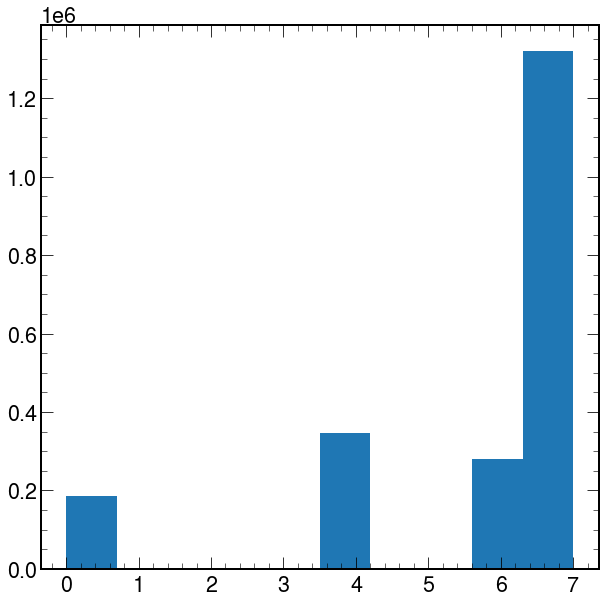

In [137]:
plt.hist(ak.flatten(jets.puId))

#  Testing the multivariations Coffea lib

In [9]:
from coffea.util import load

In [60]:
!ls ../output/sf_btag_checks_best

config.json  configurator.pkl  output_all.coffea  slurm_log


In [61]:
df = load("../output/sf_btag_checks_v77/output_all.coffea")
sample = "TTToSemiLeptonic"
year = "2018"
vars = df["variables"]

In [62]:
from pocket_coffea.utils.plot_utils import plot_shapes_comparison

In [63]:
df["variables"].keys()

dict_keys(['nJets', 'nBJets', 'nCJets_gen', 'nBJets_gen', 'jet_eta_1', 'jet_pt_1', 'jet_phi_1', 'jet_btagDeepFlavB_1', 'jet_eta_2', 'jet_pt_2', 'jet_phi_2', 'jet_btagDeepFlavB_2', 'jet_eta_3', 'jet_pt_3', 'jet_phi_3', 'jet_btagDeepFlavB_3', 'jet_eta_4', 'jet_pt_4', 'jet_phi_4', 'jet_btagDeepFlavB_4', 'jet_eta_5', 'jet_pt_5', 'jet_phi_5', 'jet_btagDeepFlavB_5', 'bjet_eta_1', 'bjet_pt_1', 'bjet_phi_1', 'bjet_btagDeepFlavB_1', 'bjet_eta_2', 'bjet_pt_2', 'bjet_phi_2', 'bjet_btagDeepFlavB_2', 'bjet_eta_3', 'bjet_pt_3', 'bjet_phi_3', 'bjet_btagDeepFlavB_3', 'bjet_eta_4', 'bjet_pt_4', 'bjet_phi_4', 'bjet_btagDeepFlavB_4', 'bjet_eta_5', 'bjet_pt_5', 'bjet_phi_5', 'bjet_btagDeepFlavB_5', 'jets_Ht', 'Njet_Ht', 'Njet_Ht_finerbins'])

TTToSemiLeptonic no_btagSF 2018 nominal
TTToSemiLeptonic btagSF 2018 nominal
TTToSemiLeptonic btagSF_calib 2018 nominal


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


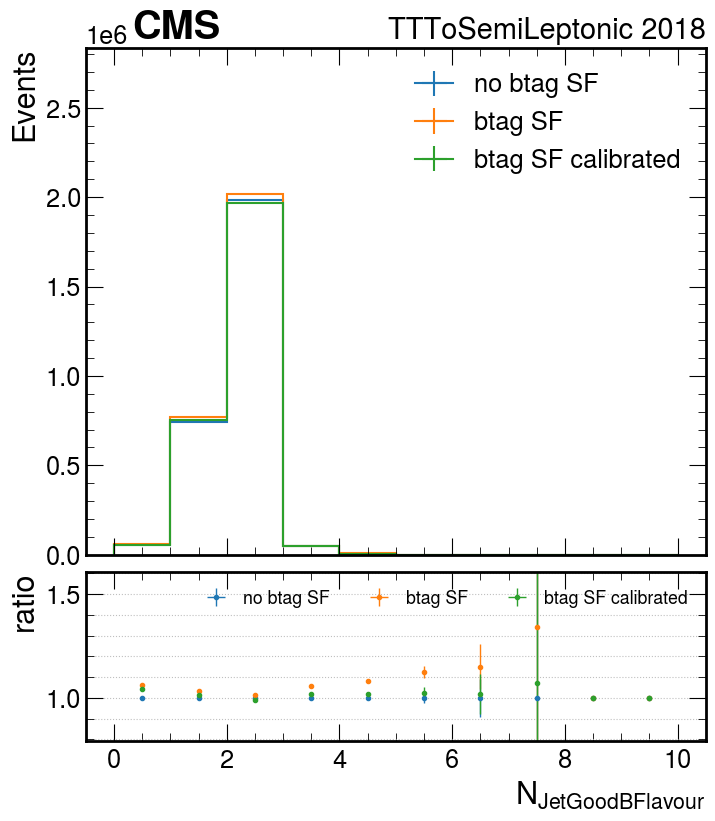

In [64]:
shapes = [
            (sample, 'no_btagSF', year, "nominal", "no btag SF"),
            (sample, 'btagSF', year, "nominal", "btag SF"),
            (sample, 'btagSF_calib', year, "nominal", "btag SF calibrated"),
        ]
_ = plot_shapes_comparison(df["variables"], "nBJets_gen", shapes, ylog=False,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic no_btagSF 2018 nominal
TTToSemiLeptonic btagSF 2018 nominal
TTToSemiLeptonic btagSF_calib 2018 nominal


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


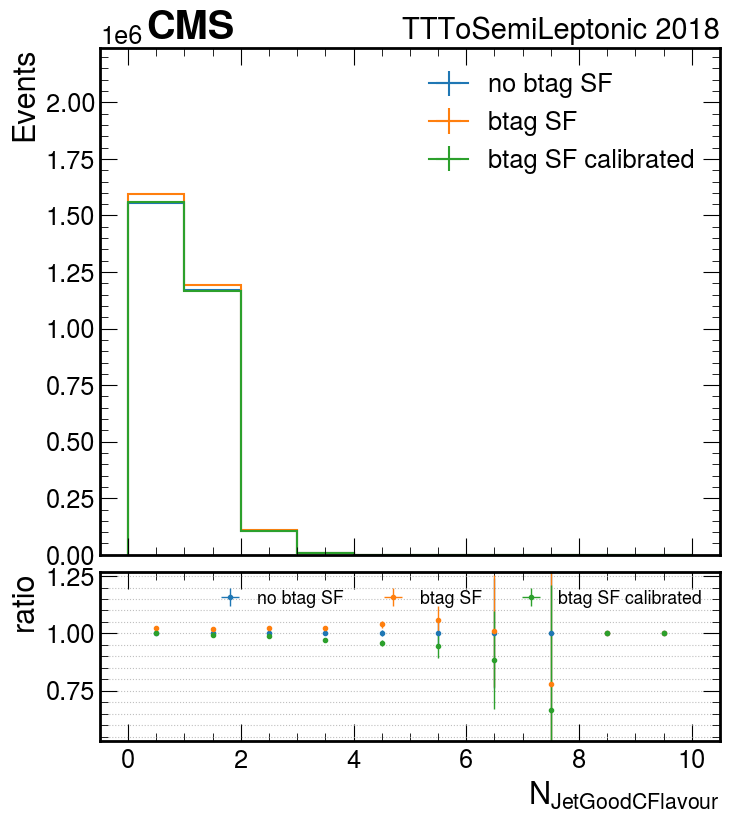

In [36]:
shapes = [
            (sample, 'no_btagSF', year, "nominal", "no btag SF"),
            (sample, 'btagSF', year, "nominal", "btag SF"),
            (sample, 'btagSF_calib', year, "nominal", "btag SF calibrated"),
        ]
_ = plot_shapes_comparison(df["variables"], "nCJets_gen", shapes, ylog=False,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic no_btagSF 2018 nominal
TTToSemiLeptonic btagSF 2018 nominal
TTToSemiLeptonic btagSF_calib 2018 nominal


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


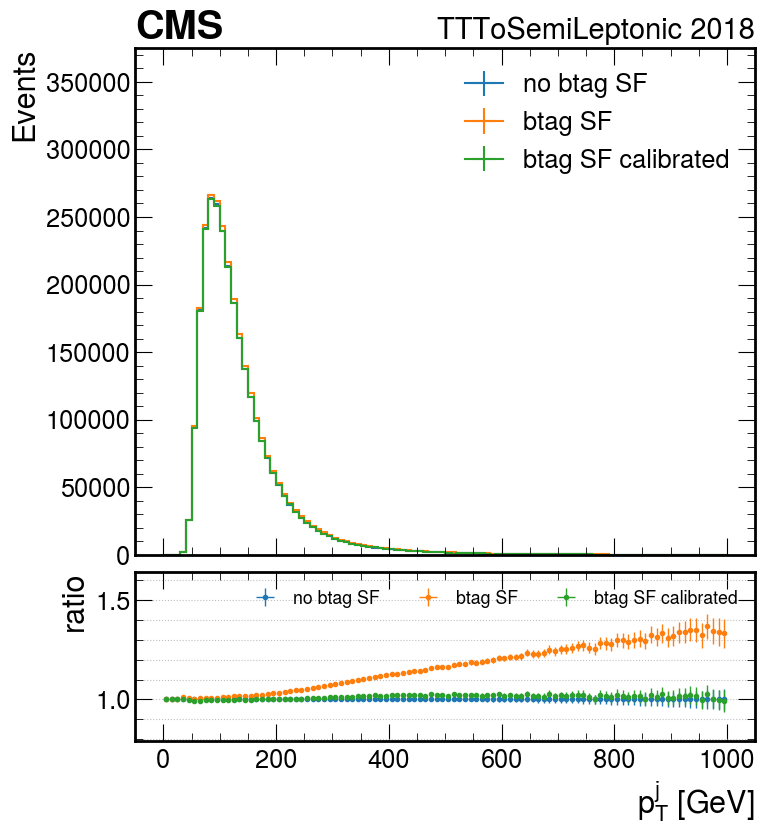

In [65]:
shapes = [
            (sample, 'no_btagSF', year, "nominal", "no btag SF"),
            (sample, 'btagSF', year, "nominal", "btag SF"),
            (sample, 'btagSF_calib', year, "nominal", "btag SF calibrated"),
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=False,
                               lumi_label=f"{sample} {year}",)


In [83]:
H

Hist(
  StrCategory(['1b', '1b_btagSF', '1b_btagSF_calib', '2b', '2b_btagSF', '2b_btagSF_calib', '3b', '3b_btagSF', '3b_btagSF_calib', '>=4b', '>=4b_btagSF', '>=4b_btagSF_calib', 'btagSF', 'btagSF_calib', 'no_btagSF'], name='cat', label='Category'),
  StrCategory(['nominal', 'JERDown', 'JERUp', 'JES_TotalDown', 'JES_TotalUp', 'sf_btag_cferr1Down', 'sf_btag_cferr1Up', 'sf_btag_cferr2Down', 'sf_btag_cferr2Up', 'sf_btag_hfDown', 'sf_btag_hfUp', 'sf_btag_hfstats1Down', 'sf_btag_hfstats1Up', 'sf_btag_hfstats2Down', 'sf_btag_hfstats2Up', 'sf_btag_lfDown', 'sf_btag_lfUp', 'sf_btag_lfstats1Down', 'sf_btag_lfstats1Up', 'sf_btag_lfstats2Down', 'sf_btag_lfstats2Up', 'sf_jet_puIdDown', 'sf_jet_puIdUp'], name='variation', label='Variation'),
  StrCategory(['2018'], name='year', label='Year'),
  Regular(100, 0, 1000, name='JetGood.pt', label='$p_{T}^{j}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=3.76593e+08, variance=1.76485e+07) (WeightedSum(value=3.76665e+08, variance=1.76527e+07) with

TTToSemiLeptonic 1b0c_btagSF_calib 2018 nominal
TTToSemiLeptonic 1b0c_btagSF_calib 2018 sf_btag_hfUp
TTToSemiLeptonic 1b0c_btagSF_calib 2018 sf_btag_hfDown


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


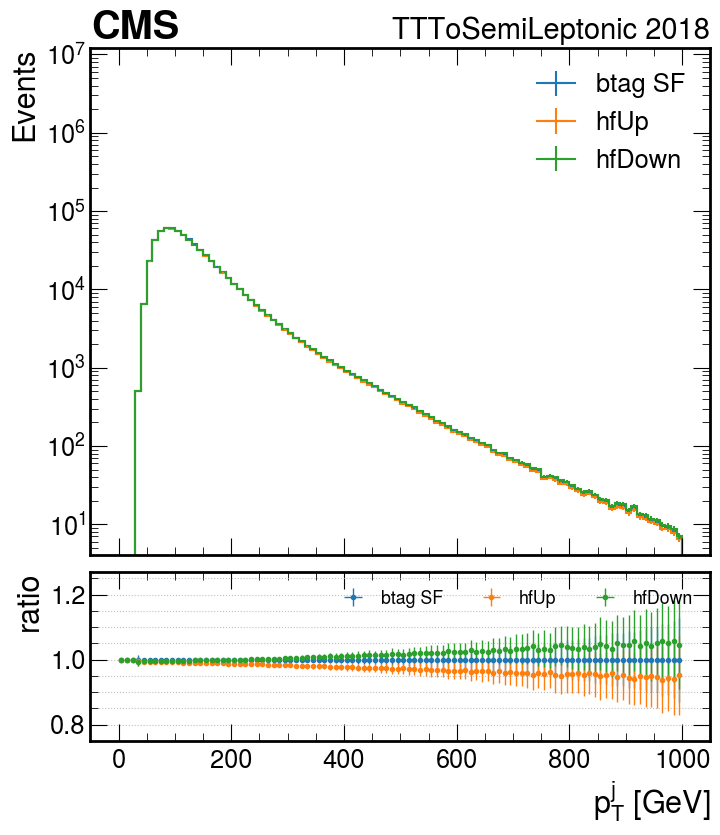

In [66]:
shapes = [
            (sample, '1b0c_btagSF_calib', year, "nominal", "btag SF"),
            #(sample, '1b0c_btagSF_calib', year, "sf_btag_cferr1Up", "cferr1Up"),
            #(sample, '1b0c_btagSF_calib', year, "sf_btag_cferr1Down", "cferr1Down"),
             (sample, '1b0c_btagSF_calib', year, "sf_btag_hfUp", "hfUp"),
             (sample, '1b0c_btagSF_calib', year, "sf_btag_hfDown", "hfDown"),
            # (sample, '3b_btagSF', year, "sf_btag_lfUp", "lfUp"),
            # (sample, '3b_btagSF', year, "sf_btag_lfDown", "lfDown"),
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=True,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 1b0c_btagSF 2018 nominal
TTToSemiLeptonic 1b0c_btagSF 2018 sf_btag_cferr1Up
TTToSemiLeptonic 1b0c_btagSF 2018 sf_btag_cferr1Down


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


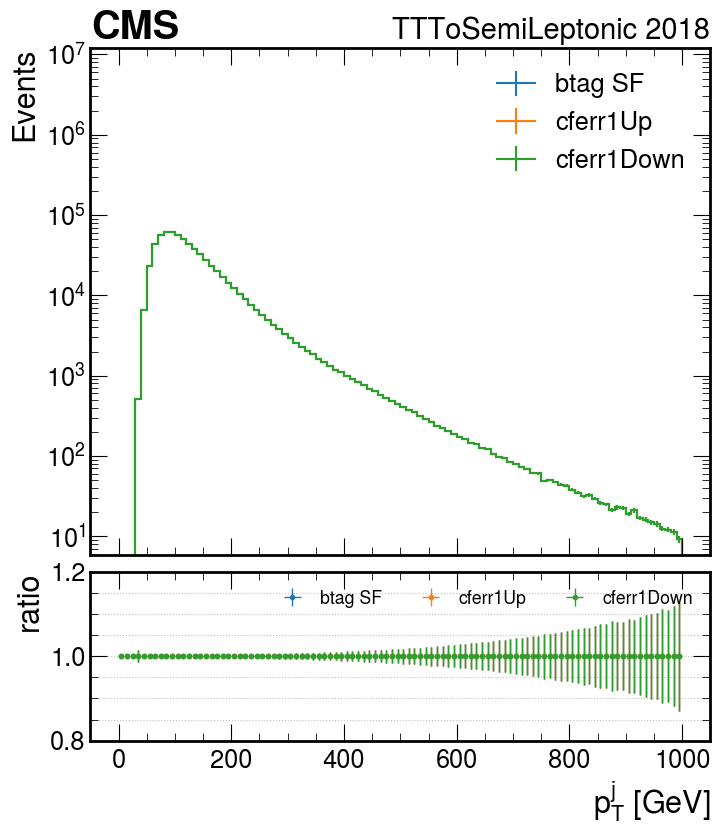

In [67]:
shapes = [
            (sample, '1b0c_btagSF', year, "nominal", "btag SF"),
            (sample, '1b0c_btagSF', year, "sf_btag_cferr1Up", "cferr1Up"),
            (sample, '1b0c_btagSF', year, "sf_btag_cferr1Down", "cferr1Down")
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=True,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 1b1c_btagSF 2018 nominal
TTToSemiLeptonic 1b1c_btagSF 2018 sf_btag_cferr1Up
TTToSemiLeptonic 1b1c_btagSF 2018 sf_btag_cferr1Down


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


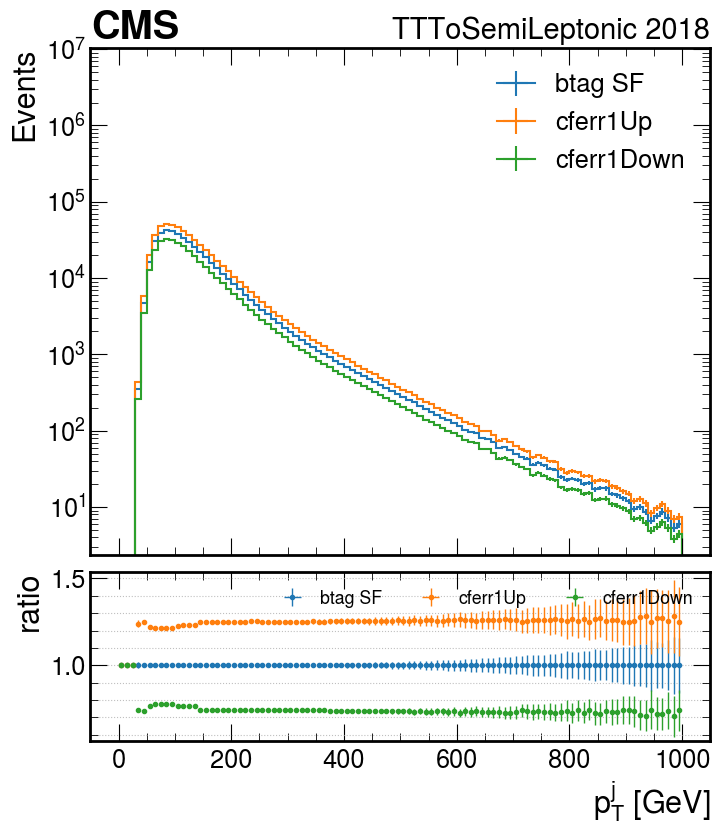

In [69]:
shapes = [
            (sample, '1b1c_btagSF', year, "nominal", "btag SF"),
            (sample, '1b1c_btagSF', year, "sf_btag_cferr1Up", "cferr1Up"),
            (sample, '1b1c_btagSF', year, "sf_btag_cferr1Down", "cferr1Down")
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=True,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 1b1c_btagSF_calib 2018 nominal
TTToSemiLeptonic 1b1c_btagSF_calib 2018 sf_btag_cferr1Up
TTToSemiLeptonic 1b1c_btagSF_calib 2018 sf_btag_cferr1Down


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


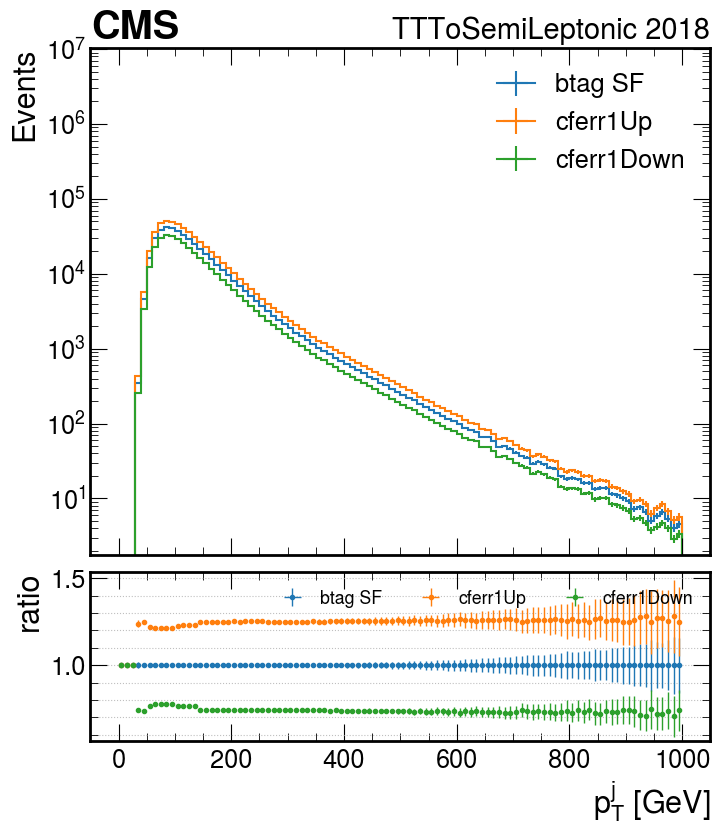

In [68]:
shapes = [
            (sample, '1b1c_btagSF_calib', year, "nominal", "btag SF"),
            (sample, '1b1c_btagSF_calib', year, "sf_btag_cferr1Up", "cferr1Up"),
            (sample, '1b1c_btagSF_calib', year, "sf_btag_cferr1Down", "cferr1Down")
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=True,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 1b2c_btagSF_calib 2018 nominal
TTToSemiLeptonic 1b2c_btagSF_calib 2018 sf_btag_cferr1Up
TTToSemiLeptonic 1b2c_btagSF_calib 2018 sf_btag_cferr1Down


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


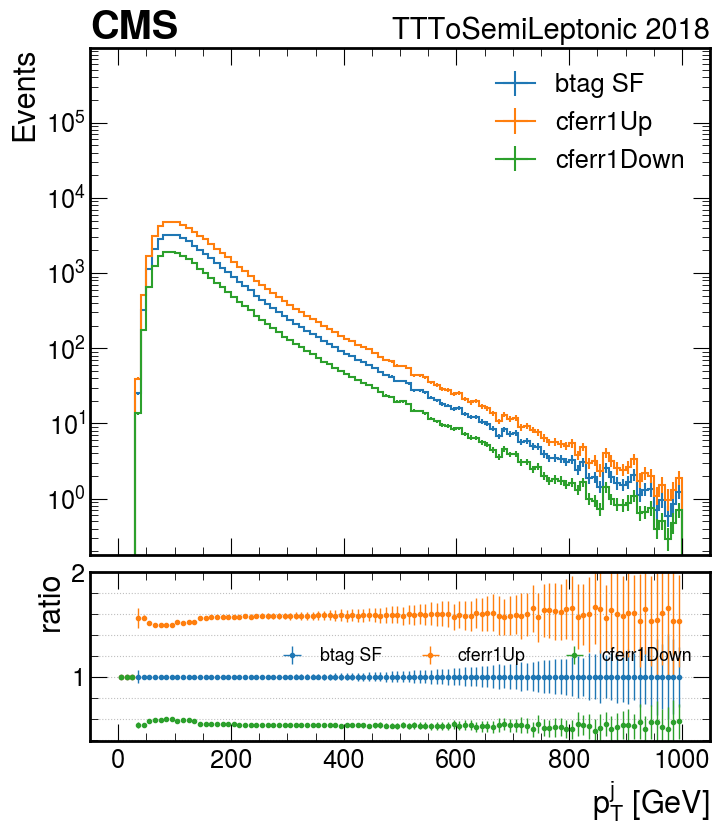

In [70]:
shapes = [
            (sample, '1b2c_btagSF_calib', year, "nominal", "btag SF"),
            (sample, '1b2c_btagSF_calib', year, "sf_btag_cferr1Up", "cferr1Up"),
            (sample, '1b2c_btagSF_calib', year, "sf_btag_cferr1Down", "cferr1Down"),
             #(sample, '1b0c_btagSF_calib', year, "sf_btag_hfUp", "hfUp"),
             #(sample, '1b0c_btagSF_calib', year, "sf_btag_hfDown", "hfDown"),
            # (sample, '3b_btagSF', year, "sf_btag_lfUp", "lfUp"),
            # (sample, '3b_btagSF', year, "sf_btag_lfDown", "lfDown"),
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=True,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 3b_btagSF_calib 2018 nominal
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_cferr1Up
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_cferr1Down


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


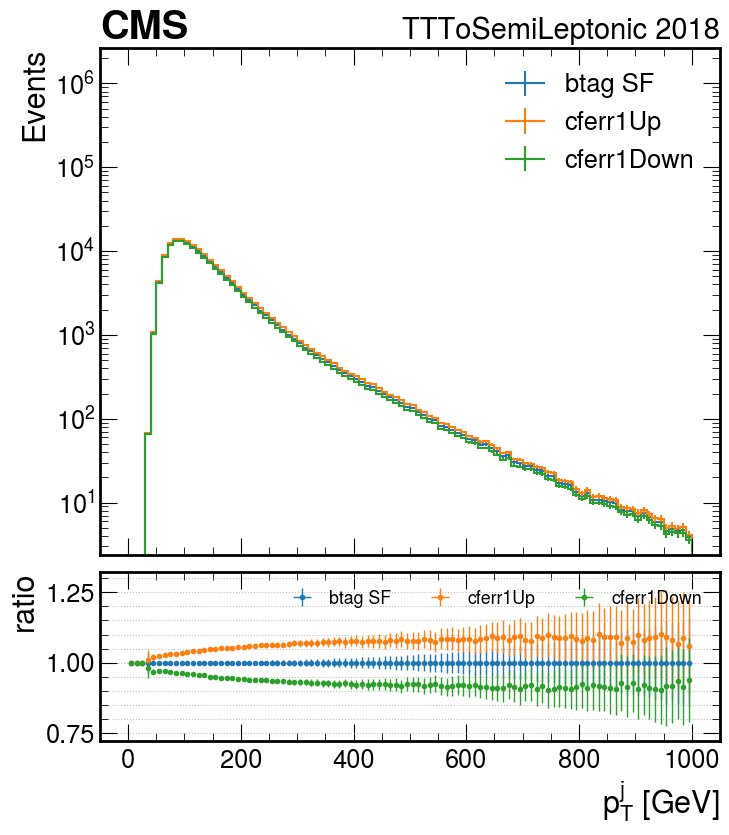

In [71]:
shapes = [
            (sample, '3b_btagSF_calib', year, "nominal", "btag SF"),
            (sample, '3b_btagSF_calib', year, "sf_btag_cferr1Up", "cferr1Up"),
            (sample, '3b_btagSF_calib', year, "sf_btag_cferr1Down", "cferr1Down"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_hfUp", "hfUp"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_hfDown", "hfDown"),
            # (sample, '3b_btagSF', year, "sf_btag_lfUp", "lfUp"),
            # (sample, '3b_btagSF', year, "sf_btag_lfDown", "lfDown"),
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=True,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 3b_btagSF 2018 nominal
TTToSemiLeptonic 3b_btagSF_calib 2018 nominal
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_cferr1Up
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_cferr1Down
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_hfUp
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_hfDown


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


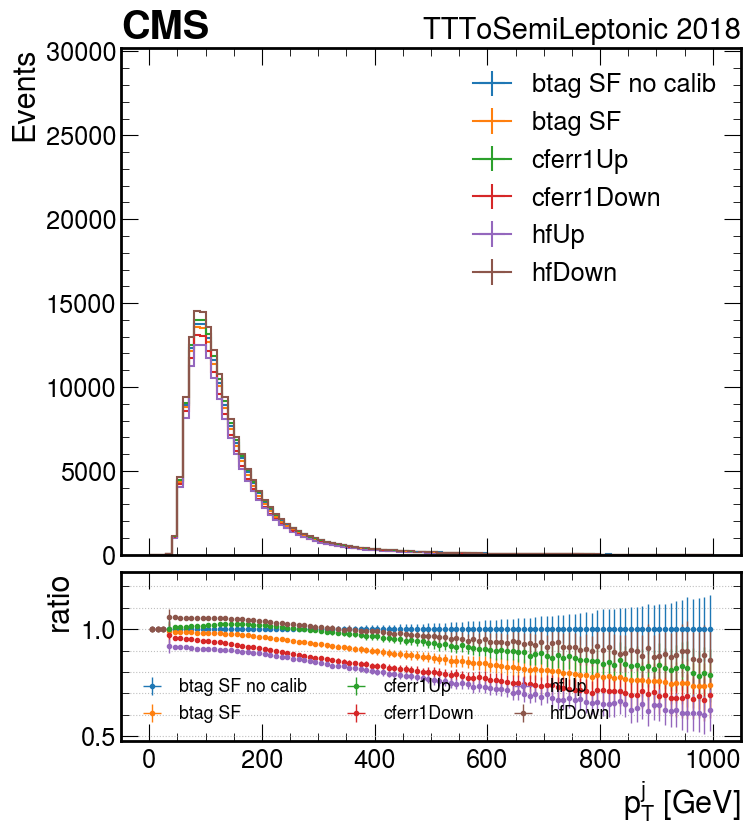

In [72]:
shapes = [
            (sample, '3b_btagSF', year, "nominal", "btag SF no calib"),        
            (sample, '3b_btagSF_calib', year, "nominal", "btag SF"),
            (sample, '3b_btagSF_calib', year, "sf_btag_cferr1Up", "cferr1Up"),
            (sample, '3b_btagSF_calib', year, "sf_btag_cferr1Down", "cferr1Down"),
            (sample, '3b_btagSF_calib', year, "sf_btag_hfUp", "hfUp"),
            (sample, '3b_btagSF_calib', year, "sf_btag_hfDown", "hfDown"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_lfUp", "lfUp"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_lfDown", "lfDown"),
        ]
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=False,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 3b_btagSF_calib 2018 nominal
TTToSemiLeptonic 3b_btagSF_calib 2018 JES_TotalUp
TTToSemiLeptonic 3b_btagSF_calib 2018 JES_TotalDown


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


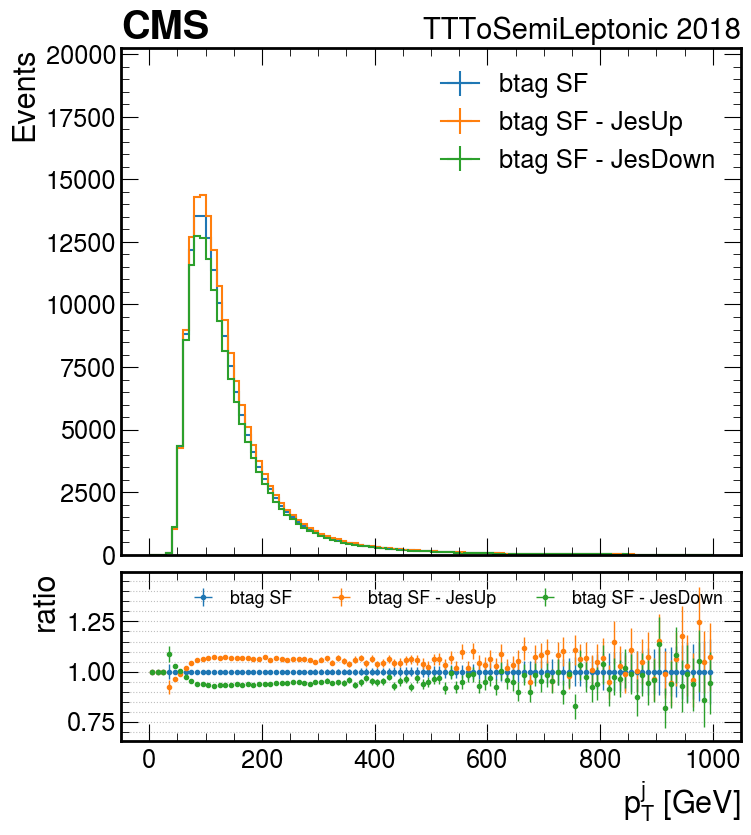

In [78]:
shapes = [        
            (sample, '3b_btagSF_calib', year, "nominal", "btag SF"),
            (sample, '3b_btagSF_calib', year, "JES_TotalUp", "btag SF - JesUp"),
            (sample, '3b_btagSF_calib', year, "JES_TotalDown", "btag SF - JesDown"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_cferr1Up", "cferr1Up"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_cferr1Down", "cferr1Down"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_hfUp", "hfUp"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_hfDown", "hfDown"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_lfUp", "lfUp"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_lfDown", "lfDown"),
        ]
        
_ = plot_shapes_comparison(df["variables"], "jet_pt_1", shapes, ylog=False,
                               lumi_label=f"{sample} {year}",)


TTToSemiLeptonic 3b_btagSF_calib 2018 nominal
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_cferr1Up
TTToSemiLeptonic 3b_btagSF_calib 2018 sf_btag_cferr1Down


/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: divide by zero encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in multiply
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:843: RuntimeWarning: invalid value encountered in divide
  (1 / nomvalues) ** 2 * h_sig2 + (h_val / nomvalues**2) ** 2 * nom_sig2
/work/dvalsecc/ttHbb/PocketCoffea/pocket_coffea/utils/plot_utils.py:845: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues > 0, h.values() / nomvalues, 1.0)


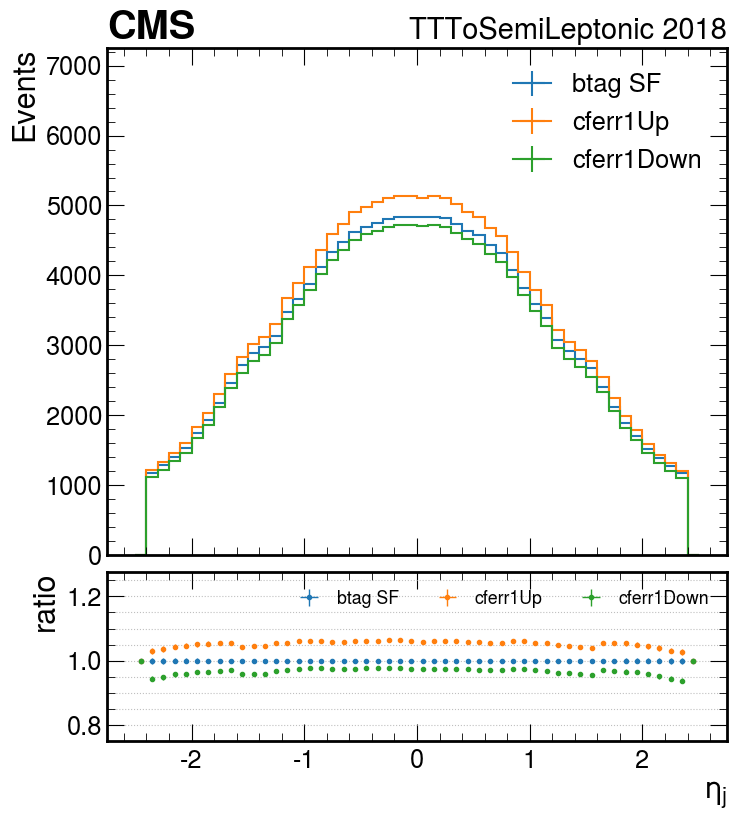

In [74]:
shapes = [        
            (sample, '3b_btagSF_calib', year, "nominal", "btag SF"),
            (sample, '3b_btagSF_calib', year, "sf_btag_cferr1Up", "cferr1Up"),
            (sample, '3b_btagSF_calib', year, "sf_btag_cferr1Down", "cferr1Down"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_hfUp", "hfUp"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_hfDown", "hfDown"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_lfUp", "lfUp"),
            #(sample, '3b_btagSF_calib', year, "sf_btag_lfDown", "lfDown"),
        ]
_ = plot_shapes_comparison(df["variables"], "jet_eta_3", shapes, ylog=False,
                               lumi_label=f"{sample} {year}",)


## Manual check of the computation

In [6]:
from pocket_coffea.lib.scale_factors import sf_btag

In [7]:
mask = (events.Jet.pt >= 30) & (abs(events.Jet.eta) < 2.5)

events["JetGood"] =  events.Jet[mask]


In [8]:
events.JetGood

<JetArray [[Jet, Jet, Jet], ... Jet, Jet, Jet]] type='300000 * var * jet'>

In [9]:
flavour = ak.to_numpy(ak.flatten(events.JetGood.hadronFlavour))
abseta = np.abs(ak.to_numpy(ak.flatten(events.JetGood.eta)))
pt = ak.to_numpy(ak.flatten(events.JetGood.pt))
discr = ak.to_numpy(ak.flatten(events.JetGood.btagDeepFlavB))
counts = ak.num(events.JetGood)

(array([669100.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 120668., 445294.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

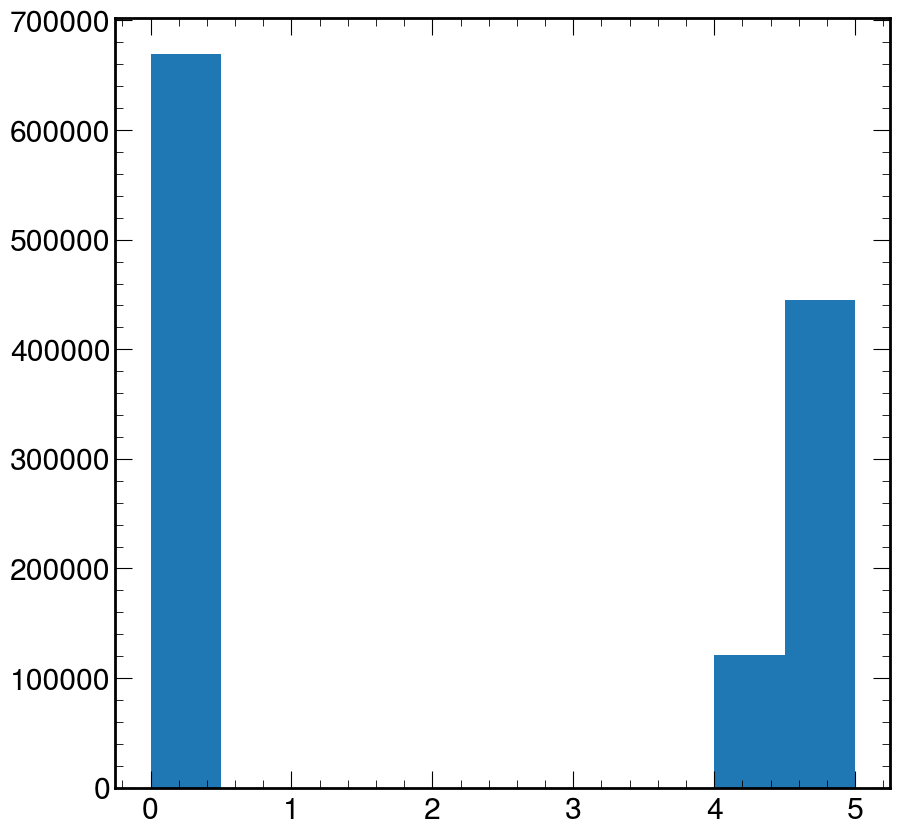

In [10]:
plt.hist(flavour)

In [11]:
from pocket_coffea.parameters.jet_scale_factors import btagSF
cset = correctionlib.CorrectionSet.from_file(btagSF["2018"])
corr = cset["deepJet_shape"]

In [12]:
nominal = corr.evaluate("central", flavour, abseta, pt, discr)

In [13]:
c_mask = flavour == 4
cferr = corr.evaluate("up_cferr1", flavour[c_mask], abseta[c_mask], pt[c_mask], discr[c_mask])

In [14]:
def _getsfwithmask(variation, mask):
    index = (np.indices(discr.shape)).flatten()[mask]
    sf = np.ones_like(discr, dtype=float)
    w = corr.evaluate(variation, flavour[mask], abseta[mask], pt[mask], discr[mask])
    sf[index] = w
    sf_out = ak.prod(ak.unflatten(sf, counts), axis=1)
    return sf_out

In [15]:
n_cflavour = ak.sum(events.JetGood.hadronFlavour==4, axis=1)

In [16]:
sf_cferr1up = _getsfwithmask("up_cferr1", c_mask)
sf_cferr1down = _getsfwithmask("down_cferr1", c_mask)

When we don't have cjets the SF variation is 0

In [17]:
sf_cferr1down[n_cflavour==0]

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='187420 * float64'>

Text(0, 1, 'btagSF cferr1 Down')

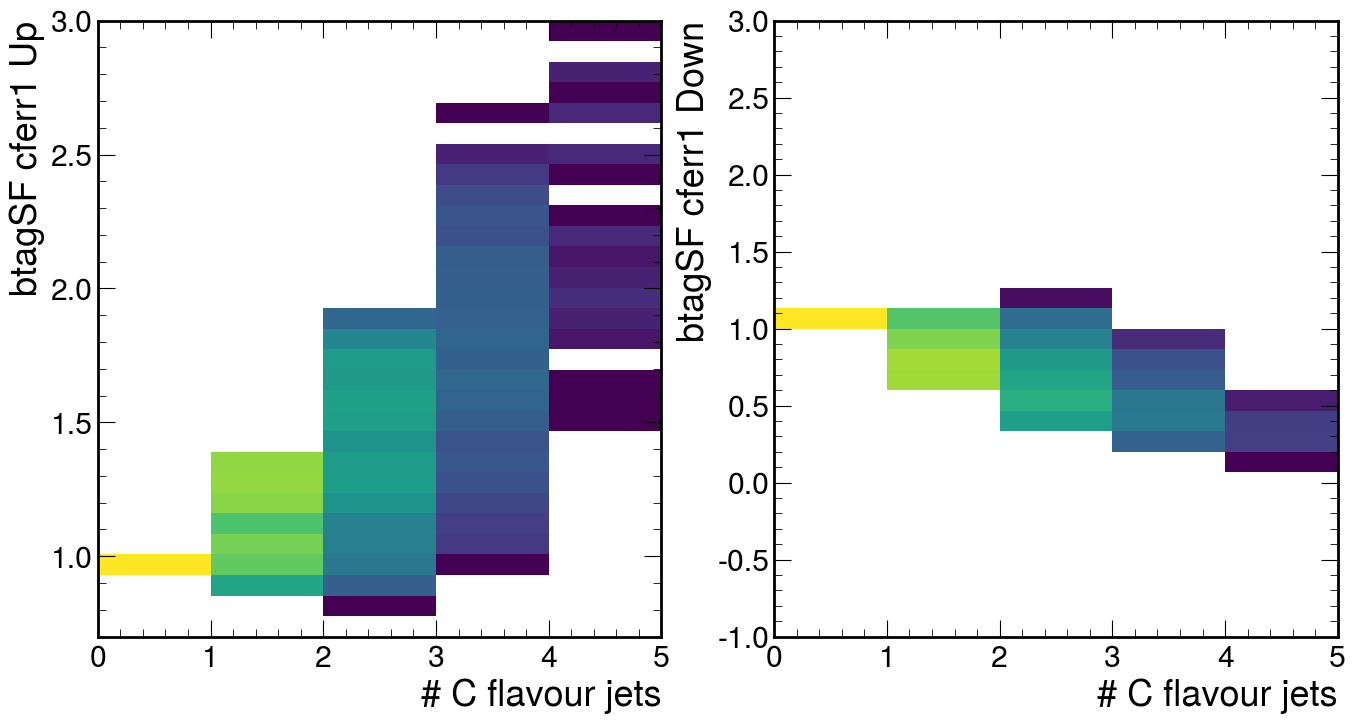

In [18]:
fig,(ax1,ax2)= plt.subplots(1, 2, figsize=(16,8))

ax1.hist2d( np.asarray(n_cflavour), np.asarray(sf_cferr1up), norm=LogNorm(),  range=((0,5), (0.7,3)), bins=(5, 30))
ax2.hist2d( np.asarray(n_cflavour), np.asarray(sf_cferr1down), norm=LogNorm(),  range=((0,5), (-1,3)), bins=(5, 30))

ax1.set_xlabel("# C flavour jets")
ax2.set_xlabel("# C flavour jets")
ax1.set_ylabel("btagSF cferr1 Up")
ax2.set_ylabel("btagSF cferr1 Down")

But the SF with Ncflavour=0 should not be 1! it should be the nominal SF of light flavour jets

In [19]:
nominal = np.ones(ak.num(counts, axis=0))

In [20]:
from pocket_coffea.lib.cut_definition import Cut
def get_c_flavour_cut(nc):
    return Cut(
        name = f"N{nc}jets_cflavour",
        params = {},
        function= lambda events, params, **kwargs: ak.sum(events.JetGood.hadronFlavour==4, axis=1) == nc
    )

jet_c0 = get_c_flavour_cut(0)
jet_c1 = get_c_flavour_cut(1)
jet_c2 = get_c_flavour_cut(2)
jet_c3 = get_c_flavour_cut(3)

In [21]:
mask_c = jet_c0.get_mask(events)

In [22]:
assert(ak.sum(jet_c0.get_mask(events) != (n_cflavour==0))==0)
assert(ak.sum(jet_c1.get_mask(events) != (n_cflavour==1))==0)
assert(ak.sum(jet_c2.get_mask(events) != (n_cflavour==2))==0)
assert(ak.sum(jet_c3.get_mask(events) != (n_cflavour==3))==0)

In [23]:
from pocket_coffea.parameters.btag import btag, btag_variations

In [49]:
btagsf = sf_btag(
    events.JetGood,
    btag["2018"]['btagging_algorithm'],
    "2018",
    variations=["central"] + ["cferr1","cferr2","lf"],
    njets=counts,
)

In [50]:
btagsf

{'central': [<Array [0.813, 1.19, 1.05, ... 1.06, 1.34] type='300000 * float64'>],
 'cferr1': [array([1., 1., 1., ..., 1., 1., 1.]),
  <Array [0.813, 1.19, 1.46, ... 1.4, 1.34] type='300000 * float64'>,
  <Array [0.813, 1.19, 0.633, ... 0.697, 1.34] type='300000 * float64'>],
 'cferr2': [array([1., 1., 1., ..., 1., 1., 1.]),
  <Array [0.813, 1.19, 1.27, ... 1.25, 1.34] type='300000 * float64'>,
  <Array [0.813, 1.19, 0.832, ... 0.85, 1.34] type='300000 * float64'>],
 'lf': [array([1., 1., 1., ..., 1., 1., 1.]),
  <Array [0.81, 1.22, 1.09, ... 0.831, 1.06, 1.4] type='300000 * float64'>,
  <Array [0.815, 1.16, 1, ... 0.761, 1.05, 1.27] type='300000 * float64'>]}

In [34]:
from copy import deepcopy

In [51]:
btagsf_scaled = deepcopy(btagsf)
for var in  ["cferr1","cferr2", "lf"]:
    # Rescale the up and down variation by the central one to
    # avoid double counting of the central SF when adding the weights
    # as separate entries in the Weights object.
    btagsf_scaled[var][1] = btagsf[var][1] / btagsf["central"][0]
    btagsf_scaled[var][2] = btagsf[var][2] / btagsf["central"][0]


In [36]:
btagsf_scaled

{'central': [<Array [0.813, 1.19, 1.05, ... 1.06, 1.34] type='300000 * float64'>],
 'cferr1': [array([1., 1., 1., ..., 1., 1., 1.]),
  <Array [1, 1, 1.38, 1, 1, ... 1, 1, 1, 1.32, 1] type='300000 * float64'>,
  <Array [1, 1, 0.6, 1, 1, ... 1, 1, 1, 0.659, 1] type='300000 * float64'>],
 'cferr2': [array([1., 1., 1., ..., 1., 1., 1.]),
  <Array [1, 1, 1.21, 1, 1, ... 1, 1, 1, 1.19, 1] type='300000 * float64'>,
  <Array [1, 1, 0.789, 1, 1, ... 1, 1, 0.803, 1] type='300000 * float64'>],
 'lf': [array([1., 1., 1., ..., 1., 1., 1.]),
  <Array [0.996, 1.02, 1.04, ... 1.04, 1, 1.05] type='300000 * float64'>,
  <Array [1, 0.972, 0.949, ... 0.997, 0.95] type='300000 * float64'>]}

In [118]:
(btagsf["cferr2"][2]*btagsf["central"][0])[n_cflavour==0]

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='187420 * float64'>

In [91]:
1500* 2430455055 / 1e9 

3645.6825825

In [38]:
mask = ak.num(events.JetGood, axis=1)>2

In [ ]:
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["central"][0][mask], bins=100, range=(0, 500), histtype="step", label="central")
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["lf"][1][mask], bins=100, range=(0, 500), histtype="step", label="lfUp")
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["lf"][2][mask], bins=100, range=(0, 500), histtype="step", label="lfDown");
plt.legend()

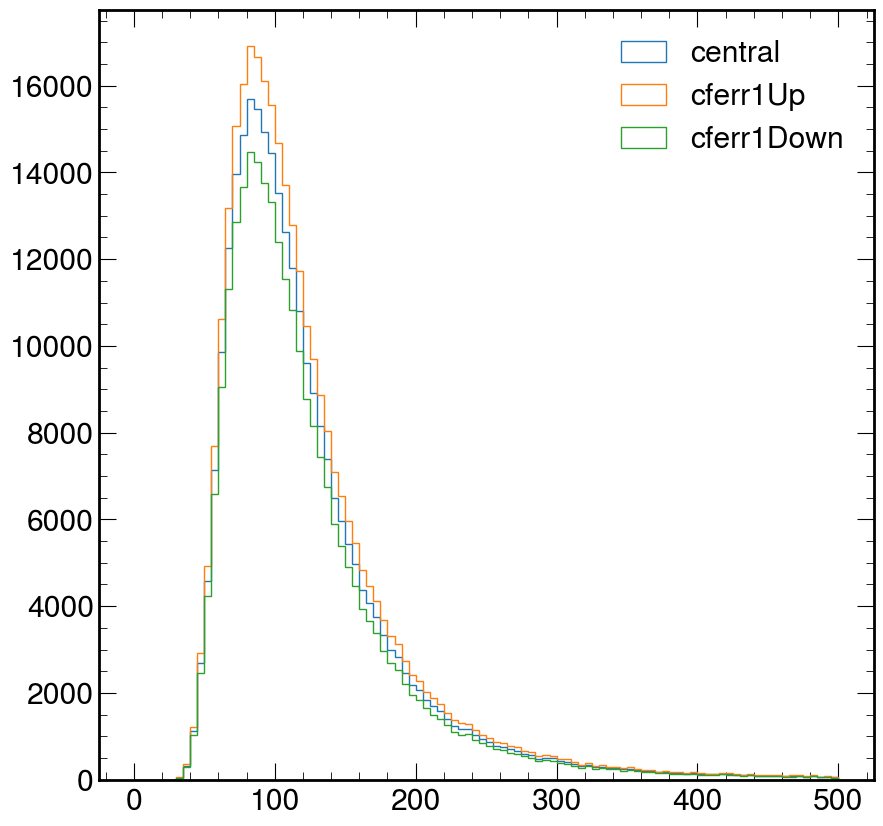

In [42]:
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["central"][0][mask], bins=100, range=(0, 500), histtype="step", label="central")
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["cferr1"][1][mask], bins=100, range=(0, 500), histtype="step", label="cferr1Up")
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["cferr1"][2][mask], bins=100, range=(0, 500), histtype="step", label="cferr1Down");
plt.legend()

In [52]:
mask_0c = mask & jet_c0.get_mask(events)
mask_1c = mask & jet_c1.get_mask(events)

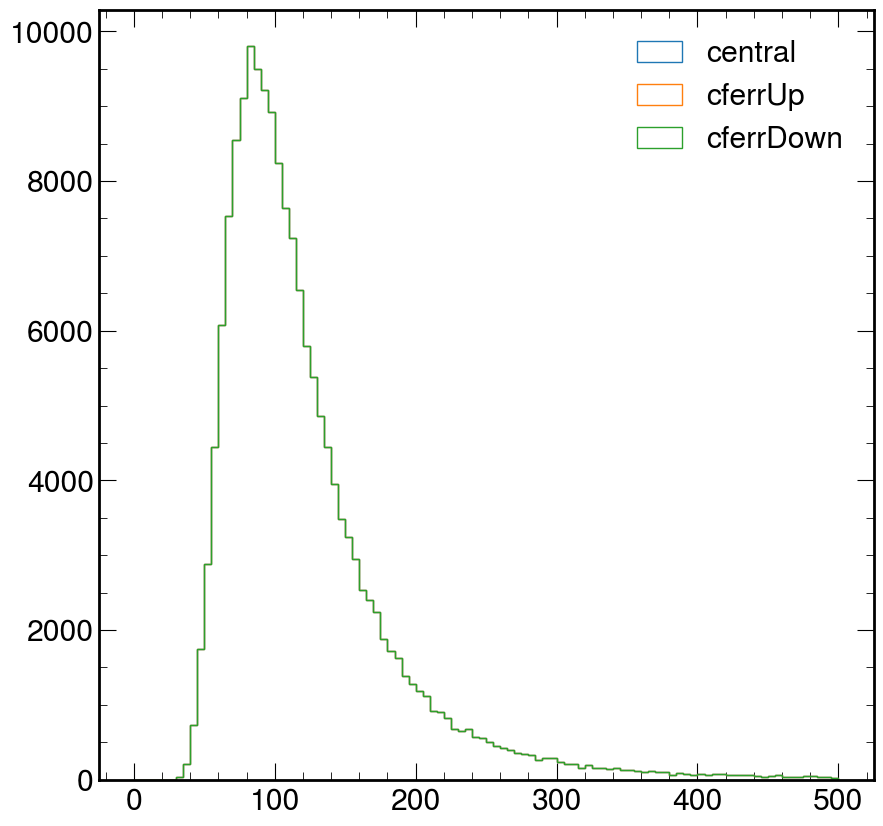

In [54]:
plt.hist(events.JetGood.pt[mask_0c][:,0], weights=btagsf["central"][0][mask_0c], bins=100, range=(0, 500), histtype="step", label="central")
plt.hist(events.JetGood.pt[mask_0c][:,0], weights=btagsf["cferr1"][1][mask_0c], bins=100, range=(0, 500), histtype="step", label="cferrUp")
plt.hist(events.JetGood.pt[mask_0c][:,0], weights=btagsf["cferr1"][2][mask_0c], bins=100, range=(0, 500), histtype="step", label="cferrDown");
plt.legend()

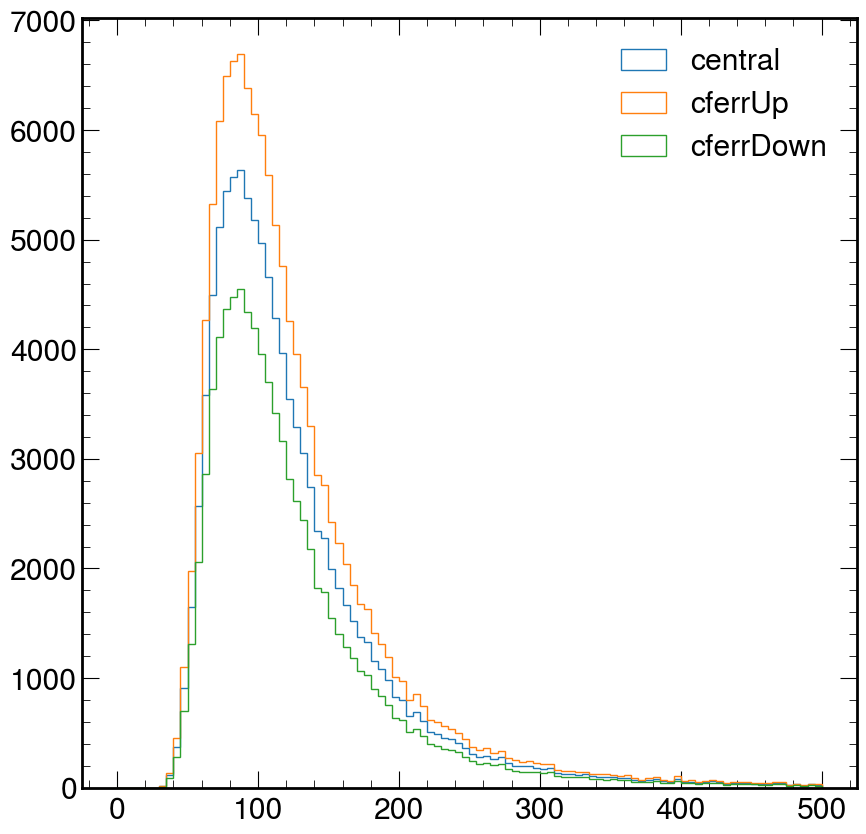

In [57]:
plt.hist(events.JetGood.pt[mask_1c][:,0], weights=btagsf["central"][0][mask_1c], bins=100, range=(0, 500), histtype="step", label="central")
plt.hist(events.JetGood.pt[mask_1c][:,0], weights=btagsf["cferr1"][1][mask_1c], bins=100, range=(0, 500), histtype="step", label="cferrUp")
plt.hist(events.JetGood.pt[mask_1c][:,0], weights=btagsf["cferr1"][2][mask_1c], bins=100, range=(0, 500), histtype="step", label="cferrDown");
plt.legend()

(0.0, 500.0)

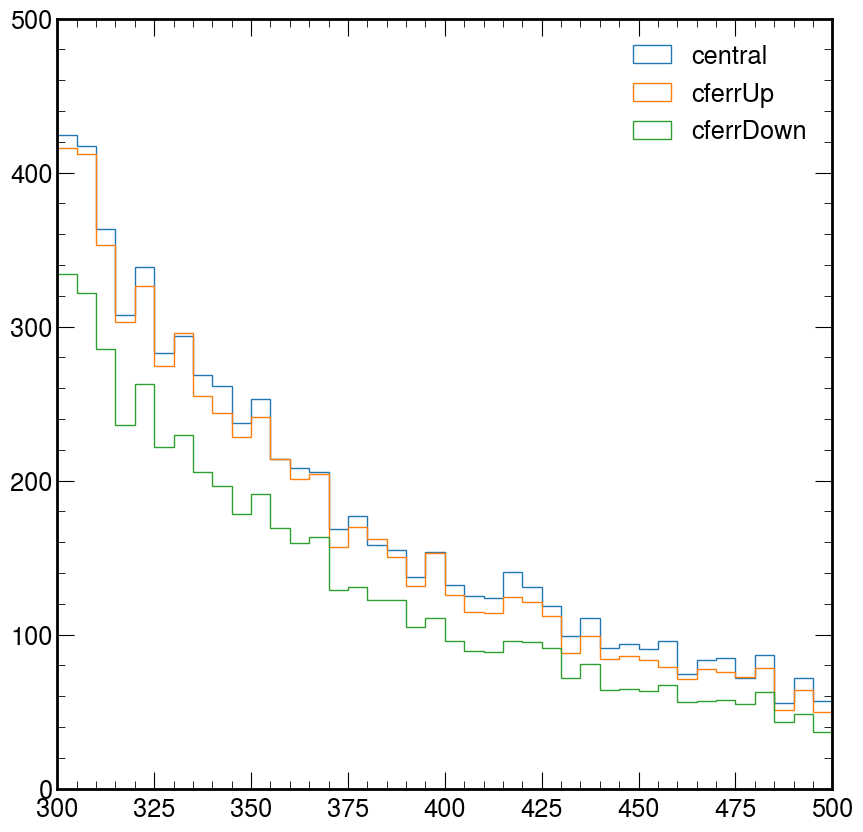

In [168]:
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["central"][0][mask], bins=100, range=(0, 500), histtype="step", label="central")
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["cferr1"][1][mask]*btagsf["central"][0][mask], bins=100, range=(0, 500), histtype="step", label="cferrUp")
plt.hist(events.JetGood.pt[mask][:,0], weights=btagsf["cferr1"][2][mask]*btagsf["central"][0][mask], bins=100, range=(0, 500), histtype="step", label="cferrDown");
plt.legend()
plt.xlim(300,500)
plt.ylim(0, 500)

(0.0, 200.0)

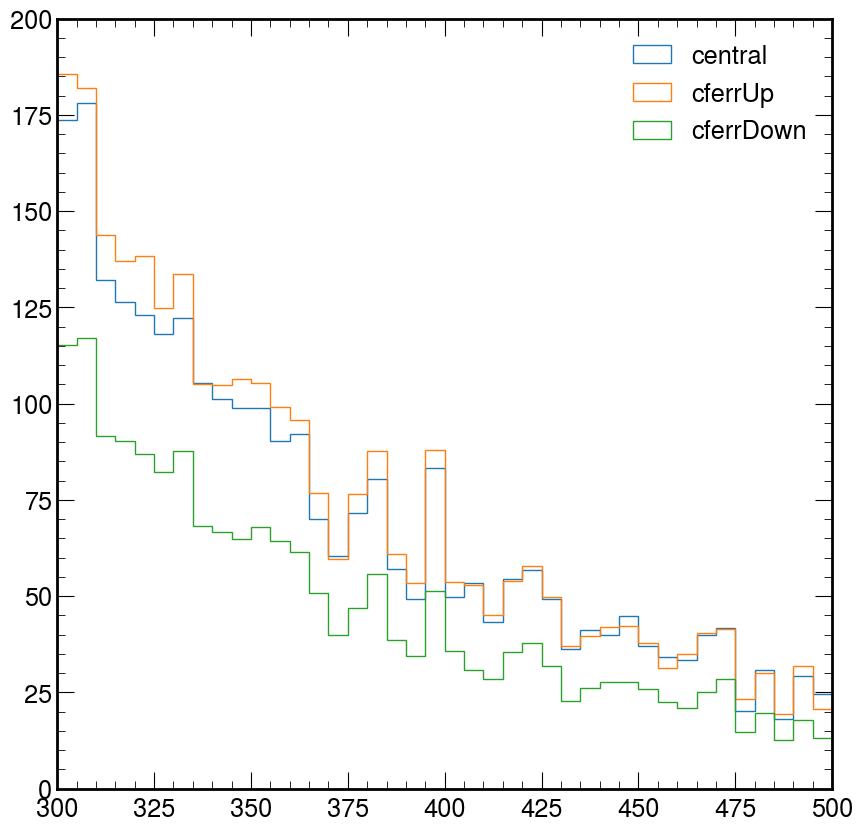

In [169]:
plt.hist(events.JetGood.pt[mask_1c][:,0], weights=btagsf["central"][0][mask_1c], bins=100, range=(0, 500), histtype="step", label="central")
plt.hist(events.JetGood.pt[mask_1c][:,0], weights=btagsf["cferr1"][1][mask_1c]*btagsf["central"][0][mask_1c], bins=100, range=(0, 500), histtype="step", label="cferrUp")
plt.hist(events.JetGood.pt[mask_1c][:,0], weights=btagsf["cferr1"][2][mask_1c]*btagsf["central"][0][mask_1c], bins=100, range=(0, 500), histtype="step", label="cferrDown");
plt.legend()
plt.xlim(300,500)
plt.ylim(0, 200)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
         26740., 160680.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

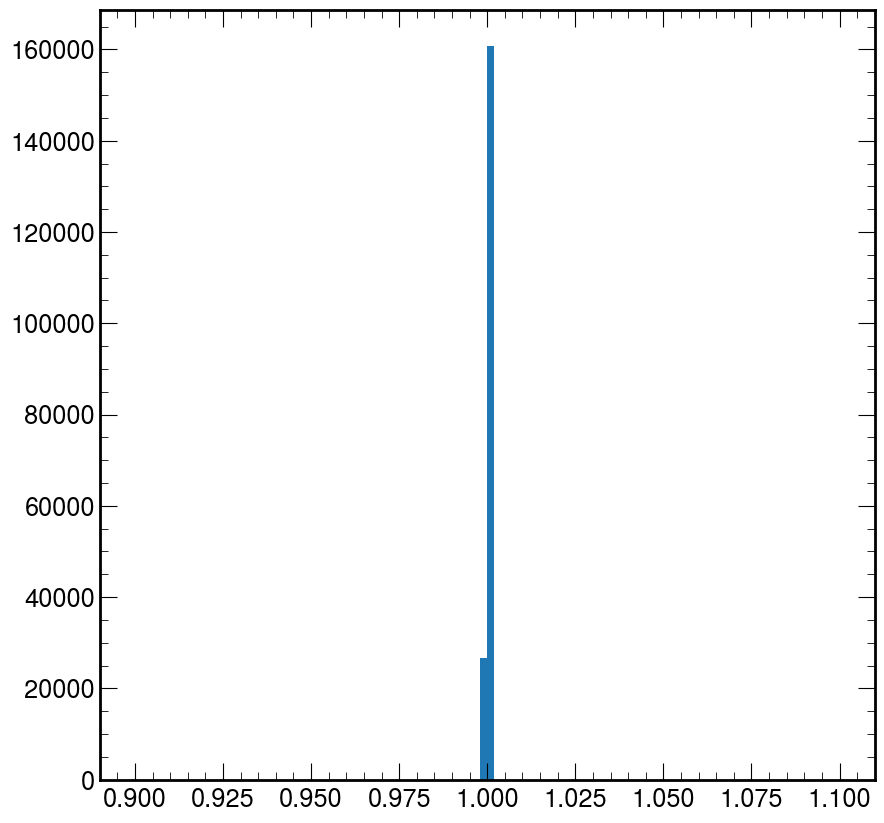

In [89]:
plt.hist(np.asarray((btagsf["cferr2"][2]*btagsf["central"][0])[n_cflavour==0]), bins=100, range=(0.9,1.1))
